In [260]:
from os.path import join
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
import scipy.stats as stats
#plt.style.use("apa.mplstyle") #custom matplotlib style

In [261]:
folder_path = "/data/NewsGuard/full-metadata/"
figures_path = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
tables_path = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

In [262]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    sns.despine(ax=ax)

# Dataset construction

In [263]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith(".csv")] 

df_total = pd.DataFrame()
for csv in csv_files: #taking all files in the folder
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    # taking name of file, removing the extension and "metadata-"
    df["file_date"]=csv.split(".")[0].split("-")[1]
    # converting file_date to datetime, with format YYYYMMDD00
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_total = pd.concat([df_total, df], axis=0)

In [264]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("1501.csv")] 
df_15 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_15 = pd.concat([df_15, df], axis=0)

In [265]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("0201.csv")] 
df_02 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_02 = pd.concat([df_02, df], axis=0)

In [266]:
df_recent = df_15[df_15["file_date"] == df_15["file_date"].max()]
df_first = df_15[df_15["file_date"] == df_15["file_date"].min()]

print(f'In the most recent file, there are {len(df_recent)} entries, '
      f'with {df_recent["UUID"].nunique()} rating IDs '
      f'and {df_recent["Domain"].nunique()} domains.')

print(f'In the first file, there are {len(df_first)} entries, '
      f'with {df_first["UUID"].nunique()} IDs '
      f'and {df_first["Domain"].nunique()} domains.')

In the most recent file, there are 11998 entries, with 6949 rating IDs and 10588 domains.
In the first file, there are 2647 entries, with 2647 IDs and 2641 domains.


Before 2024: In the most recent file, there are 11314 entries, with 6598 rating IDs and 9946 domains.

In [267]:
df_recent.columns

Index(['UUID', 'Domain', 'Parent Domain', 'Rating', 'Score', 'Last Updated',
       'Country', 'Language', 'Does not repeatedly publish false content',
       'Gathers and presents information responsibly',
       'Regularly corrects or clarifies errors',
       'Handles the difference between news and opinion responsibly',
       'Avoids deceptive headlines',
       'Website discloses ownership and financing',
       'Clearly labels advertising',
       'Reveals who's in charge, including any possible conflicts of interest',
       'The site provides names of content creators, along with either contact or biographical information',
       'Brand Name', 'Wikipedia', 'Type of Content', 'Medium',
       'Print Publications', 'Scope of Coverage', 'Designated Market Area',
       'Paywall', 'Opinion/Advocacy Journalism', 'Orientation', 'Owner',
       'Type of Owner', 'Facebook', 'Twitter', 'YouTube', 'Instagram',
       'Snapchat', 'LinkedIn', 'Pinterest', 'Main Point of Contact (name)',


In [268]:
rating_counts = df_recent.Rating\
    .value_counts(normalize=False)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Count"})

rating_countsp = df_recent.Rating\
    .value_counts(normalize=True)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Percent"})

ratings = pd.merge(rating_counts, rating_countsp, 
                   on="Rating")

rating_mean = df_recent\
    .groupby("Rating").Score\
    .mean()\
    .reset_index()\
    .rename(columns={"Score":"Mean"})

pd.merge(ratings, rating_mean, on="Rating")

Rating  Count   Percent       Mean
0      T   6778  0.564927  87.295441
1      N   4356  0.363061  24.930096
2     FL    731  0.060927        NaN
3      P     70  0.005834        NaN
4      S     63  0.005251        NaN

In [269]:
for rating in df_recent.Rating.unique():
    print(rating, df_recent[df_recent.Rating == rating].Domain.unique()[:3])

N ['thenevadannews.com' 'miamichron.com' 'american-freedom.org']
T ['thenightly.com.au' 'positivr.fr' 'farmweekly.com.au']
FL ['ts2.tech' 'fluffytamer.com' 'passfolk.com']
P ['openvaers.com' 'newsbreak.com' 'brighteon.com']
S ['theonion.com' 'elizabethwarren.co' 'alternative-science.com']


In [270]:
p_rating = df_recent[df_recent["Rating"] == "P"]
if not p_rating["Score"].isnull().all():
    mean_score = p_rating["Score"].mean(skipna=True)
    print(f"Mean score for rating P: {mean_score}")
else:
    print(f"No scores available for rating P.")

No scores available for rating P.


In [271]:
print(f'Number of rows without Score: {df_recent.Score.isna().sum()}')
print(f'Percentage: {round(df_recent.Score.isna().sum()/len(df_recent)*100,2)}%')

Number of rows without Score: 864
Percentage: 7.2%


In [272]:
print(f'Number of rows with Score: {len(df_recent) - df_recent.Score.isna().sum()}')

Number of rows with Score: 11134


## How volatile are trustworthiness ratings?

### Coverage

In [273]:
print(f'In the most recent df, there are {len(df_recent[df_recent["Score"].notnull()])} '
      f'rated domains while there are {len(df_first[df_first["Score"].notnull()])} '
      'in the first version of the database.')
print(f'The domains belong to {df_recent["Parent Domain"].nunique()} parent domains.')
print(f'The number of entries has grown by {round((len(df_recent)/len(df_first)-1)*100,2)}%')

In the most recent df, there are 11134 rated domains while there are 2615 in the first version of the database.
The domains belong to 433 parent domains.
The number of entries has grown by 353.27%


In [274]:
df_recent["Parent Domain"]\
    .notnull()\
    .value_counts()

False    6424
True     5574
Name: Parent Domain, dtype: int64

In [275]:
df_recent_p = df_recent[df_recent["Parent Domain"]\
                        .notnull()]\
                        .sort_values("Parent Domain")

In [276]:
df_recent_p.groupby("Parent Domain")\
    .Score\
    .nunique()\
    .value_counts()

1    420
0     13
Name: Score, dtype: int64

In [277]:
parent_domains_std = df_recent_p\
    .groupby("Parent Domain")\
    .Score.std()\
        .reset_index()\
        .rename(columns={"Score":"std"})

parent_domains_std

Parent Domain  std
0    100percentfedup.com  0.0
1       12onyourside.com  0.0
2        21alivenews.com  0.0
3          25newsnow.com  0.0
4              2news.com  0.0
..                   ...  ...
428    wyomingnewsnow.tv  0.0
429            yahoo.com  0.0
430     yourobserver.com  0.0
431          youtube.com  NaN
432         zeppfeed.com  0.0

[433 rows x 2 columns]

In [278]:
def filter_different_scores(df):
    #filter based on standard deviation
    score_std = df["Score"].std()
    if score_std != 0:
        return True
    else:
        return False

grouped = df_recent_p.groupby("Parent Domain")
different_scores_rows = grouped.filter(filter_different_scores)
different_scores_rows

UUID              Domain Parent Domain  \
8213   8758f4c5-701d-4520-aca3-0a1b7ae97d95             8ch.net       8ch.net   
8214   8758f4c5-701d-4520-aca3-0a1b7ae97d95            8kun.top       8ch.net   
11795  99869514-a719-4438-9943-f5324f9e3b0f       thedonald.win   america.win   
11794  99869514-a719-4438-9943-f5324f9e3b0f         america.win   america.win   
5157   0489fbd6-4f97-4eef-863e-3c1c680d4c38  1010wins.radio.com    audacy.com   
...                                     ...                 ...           ...   
4512   129d318f-0d9f-4119-9274-dd20a207948e         youtube.com   youtube.com   
10088  1241ed36-7b40-4d5e-b2c4-45f6e95d3f31         youtube.com   youtube.com   
4238   150bf589-d474-49d6-a3ac-ac79bcd7e4a0         youtube.com   youtube.com   
4239   150bf589-d474-49d6-a3ac-ac79bcd7e4a0            youtu.be   youtube.com   
7993   9c111a84-907e-447d-82e7-7b6f482a80ea            youtu.be   youtube.com   

      Rating  Score   Last Updated Country Language  \
8213       P    NaN  1682876174682      US       en   
8214       P    NaN  1682876174682      US       en   
11795      P    NaN  1641332857656      US       en   
11794      P    NaN  1641332857656      US       en   
5157       P    NaN  1697681345081      US       en   
...      ...    ...            ...     ...      ...   
4512       P    NaN  1702064052769      US       en   
10088      P    NaN  1672139882808      DE       de   
4238       P    NaN  1702901756788      FR       fr   
4239       P    NaN  1702901756788      FR       fr   
7993       P    NaN  1684170610366      IT       it   

      Does not repeatedly publish false content  \
8213                                        NaN   
8214                                        NaN   
11795                                       NaN   
11794                                       NaN   
5157                                        NaN   
...                                         ...   
4512                                        NaN   
10088                                       NaN   
4238                                        NaN   
4239                                        NaN   
7993                                        NaN   

      Gathers and presents information responsibly  ... LINKEDIN IOSAPP  \
8213                                           NaN  ...      NaN    NaN   
8214                                           NaN  ...      NaN    NaN   
11795                                          NaN  ...      NaN    NaN   
11794                                          NaN  ...      NaN    NaN   
5157                                           NaN  ...      NaN    NaN   
...                                            ...  ...      ...    ...   
4512                                           NaN  ...      NaN    NaN   
10088                                          NaN  ...      NaN    NaN   
4238                                           NaN  ...      NaN    NaN   
4239                                           NaN  ...      NaN    NaN   
7993                                           NaN  ...      NaN    NaN   

      ANDROIDAPP OTHER Contact Mail Form URL.1 Communities Served  \
8213         NaN   NaN                     NaN                NaN   
8214         NaN   NaN                     NaN                NaN   
11795        NaN   NaN                     NaN                NaN   
11794        NaN   NaN                     NaN                NaN   
5157         NaN   NaN                     NaN                NaN   
...          ...   ...                     ...                ...   
4512         NaN   NaN                     NaN                NaN   
10088        NaN   NaN                     NaN                NaN   
4238         NaN   NaN                     NaN                NaN   
4239         NaN   NaN                     NaN                NaN   
7993         NaN   NaN                     NaN                NaN   

      BrandGuard Segments                                   Fa

In [279]:
different_scores_rows\
    .Rating\
        .value_counts()


FL    40
P     32
S      6
Name: Rating, dtype: int64

In [280]:
#counting number of ratings for sampling mid-month
counts_15 = df_15.groupby(df_15.file_date)\
    .size()\
    .reset_index(name="Counts")

#counting number of ratings for sampling beginning of month
counts_02 = df_02.groupby(df_02.file_date)\
    .size()\
    .reset_index(name="Counts")

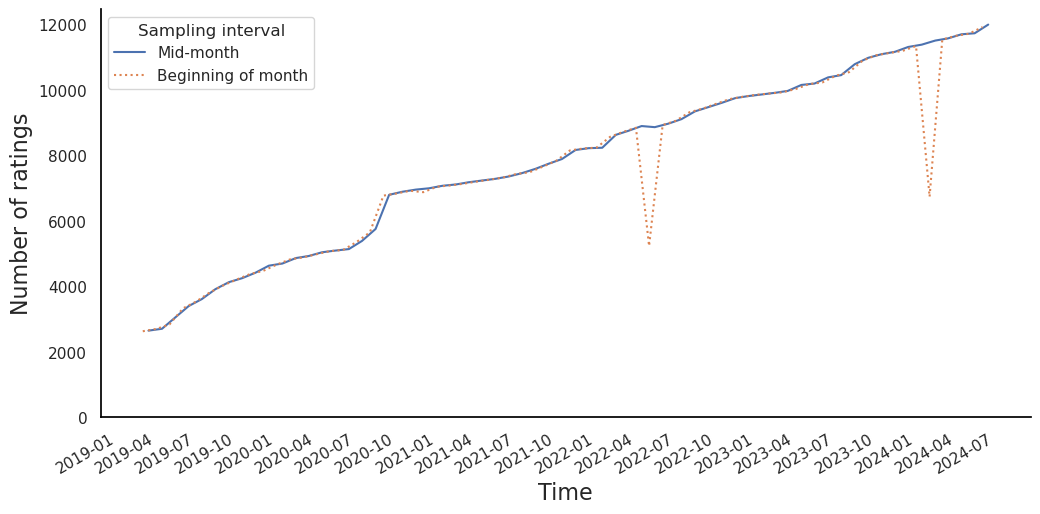

In [281]:
plt.figure(figsize=(12,6))
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Mid-month"
             )

sns.lineplot(data=counts_02, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Beginning of month", 
             linestyle="dotted")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate()

plt.ylim(0)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Number of ratings", fontsize=16)
plt.legend(title="Sampling interval")
custom_plots()

plt.show()

### Added and removed sources

In [282]:
domain_changes = {}
#getting list of unique months to iterate through
unique_months = df_15.sort_values("file_date")["file_date"]\
                    .unique()

for i in range(1, len(unique_months)): #iterate through months
    current_month = unique_months[i] #set as current months
    previous_month = unique_months[i - 1] #set month minus one as previous month
    
    #compare domains from current month to previous month
    added_month = set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())
    removed_month = set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())
    domain_changes[current_month] = added_month, removed_month

In [283]:
data = []
for date, (added, removed) in domain_changes.items():
    data.append({"Date": date, 
                 "Added": len(added), 
                 "Removed": len(removed)})

domain_changes_df = pd.DataFrame(data)

In [284]:
print(f'Total number of added sources: {domain_changes_df["Added"].sum()}')
print(f'Total number of removed sources: {domain_changes_df["Removed"].sum()}')

Total number of added sources: 8616
Total number of removed sources: 669


In [285]:
print(f'Average number of added sources per month: {domain_changes_df["Added"].mean()}')
print(f'Average number of removed sources per month: {domain_changes_df["Removed"].mean()}')

Average number of added sources per month: 138.96774193548387
Average number of removed sources per month: 10.790322580645162


### Duplicates

In [286]:
#extracting duplicated domains
dup_domains = \
    df_recent[df_recent\
                .duplicated(subset="Domain", 
                            keep=False)]

#looking at only relevant columns
dup_domains[["Domain", "Country", "Language", "Score"]]\
    .head(10)

Domain Country Language  Score
209           tekpolis.fr     ALL       en   59.5
715           positivr.fr      FR       fr   87.5
716           positivr.fr     ALL       en   87.5
727     lereveildumidi.fr      FR       fr   82.5
728     lereveildumidi.fr     ALL       en   82.5
734  landdergesundheit.de      DE       de   82.5
735  landdergesundheit.de     ALL       en   82.5
737             quarks.de     ALL       en   87.5
738             quarks.de      DE       de   87.5
740          20minutes.fr     ALL       en  100.0

In [287]:
#counting if the score is the same for domains
dup_domains \
    .groupby("Domain").Score \
    .nunique() \
    .reset_index(name="nunique") \
    .sort_values(by="nunique", 
                 ascending=False)

Domain  nunique
1             2020news.de        2
840               msn.com        2
1312             vice.com        2
0     100giornidaleoni.it        1
923           oekotest.de        1
...                   ...      ...
242     der-postillon.com        0
389      franchetvinfo.fr        0
163       charliehebdo.fr        0
712             lercio.it        0
921            odysee.com        0

[1395 rows x 2 columns]

In [288]:
dup_domains[dup_domains["Domain"] == "2020news.de"]

UUID       Domain Parent Domain Rating  \
4573  c8f696fa-6e0d-425a-be84-65c6ae026053  2020news.de           NaN      N   
4574  7bcdfe35-404d-4527-806e-42fb886489c3  2020news.de           NaN      N   
8170  c5430307-1bac-4f1c-8ec8-78d865773536  2020news.de           NaN      N   

      Score   Last Updated Country Language  \
4573    7.5  1701773991583      DE       de   
4574    7.5  1701773961717     ALL       en   
8170   20.0  1683124183492      IT       it   

     Does not repeatedly publish false content  \
4573                                       NaN   
4574                                       NaN   
8170                                       NaN   

     Gathers and presents information responsibly  ... LINKEDIN IOSAPP  \
4573                                           No  ...      NaN    NaN   
4574                                           No  ...      NaN    NaN   
8170                                           No  ...      NaN    NaN   

     ANDROIDAPP OTHER Contact Mail Form URL.1 Communities Served  \
4573        NaN   NaN                     NaN                NaN   
4574        NaN   NaN                     NaN                NaN   
8170        NaN   NaN                     NaN                NaN   

                                    BrandGuard Segments  \
4573  Exclusion - Maximum Safety,Exclusion - High Sa...   
4574  Exclusion - Maximum Safety,Exclusion - High Sa...   
8170  Exclusion - Maximum Safety,Exclusion - High Sa...   

                                       False Narratives  \
4573  70a816f2-b3e9-4c19-9015-a43b1e2da217,5e81b612-...   
4574  70a816f2-b3e9-4c19-9015-a43b1e2da217,5e81b612-...   
8170  70a816f2-b3e9-4c19-9015-a43b1e2da217,dc2cb70a-...   

     Does not repeatedly publish false or egregiously misleading content  \
4573                                                 No                    
4574                                                 No                    
8170                                                 No                    

     Has effective practices for correcting errors  
4573                                            No  
4574                                            No  
8170                                            No  

[3 rows x 65 columns]

In [289]:
dup_domains[dup_domains["Domain"] == "msn.com"]

UUID   Domain Parent Domain Rating  \
9073  ee1b3891-9f91-4ed9-965a-30e2cfa9d570  msn.com           NaN      T   
9074  f843fc63-c821-4109-b5f7-59c71c30bee8  msn.com           NaN      T   
9083  e20511ee-a5de-4f75-9440-fc0b7fef4d21  msn.com           NaN      T   
9203  6b89eb7a-2a98-432a-8a34-9ea06136fe25  msn.com           NaN      T   

      Score   Last Updated Country Language  \
9073  100.0  1678197839246     ALL       en   
9074  100.0  1678197834039      FR       fr   
9083   87.5  1678179477035      IT       it   
9203  100.0  1677518755548      US       en   

     Does not repeatedly publish false content  \
9073                                       NaN   
9074                                       NaN   
9083                                       NaN   
9203                                       NaN   

     Gathers and presents information responsibly  ... LINKEDIN IOSAPP  \
9073                                          Yes  ...      NaN    NaN   
9074                                          Yes  ...      NaN    NaN   
9083                                          Yes  ...      NaN    NaN   
9203                                          Yes  ...      NaN    NaN   

     ANDROIDAPP OTHER Contact Mail Form URL.1 Communities Served  \
9073        NaN   NaN                     NaN                NaN   
9074        NaN   NaN                     NaN                NaN   
9083        NaN   NaN                     NaN                NaN   
9203        NaN   NaN                     NaN                NaN   

                                    BrandGuard Segments  \
9073  Inclusion - Maximum Safety,Inclusion - High Sa...   
9074  Inclusion - Maximum Safety,Inclusion - High Sa...   
9083  Inclusion - Basic Safety,Exclusion - Maximum S...   
9203  Inclusion - Maximum Safety,Inclusion - High Sa...   

                                       False Narratives  \
9073  9b371100-40f7-41be-9f2b-f2c33b37c79c,059dec67-...   
9074  9b371100-40f7-41be-9f2b-f2c33b37c79c,059dec67-...   
9083  ea56a9d9-62a5-4eb2-b1cc-ea6874f745da,72cc7934-...   
9203  9b371100-40f7-41be-9f2b-f2c33b37c79c,059dec67-...   

     Does not repeatedly publish false or egregiously misleading content  \
9073                                                Yes                    
9074                                                Yes                    
9083                                                Yes                    
9203                                                Yes                    

     Has effective practices for correcting errors  
9073                                           Yes  
9074                                           Yes  
9083                                           Yes  
9203                                           Yes  

[4 rows x 65 columns]

## Trustworthiness distribution

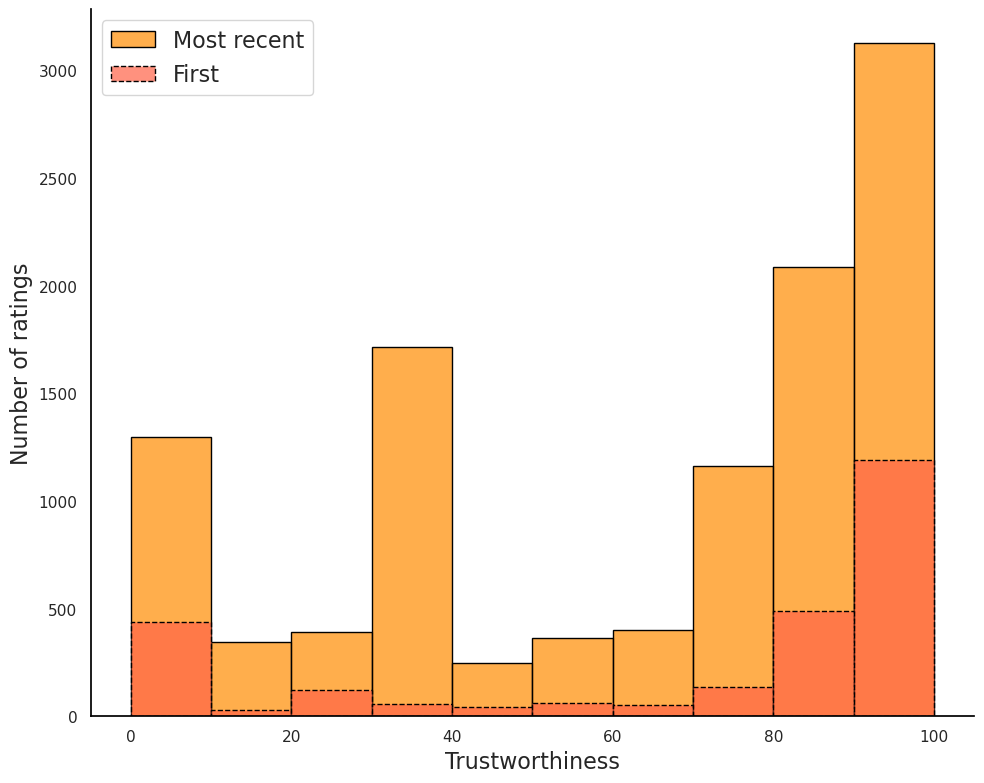

In [290]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_recent, 
             x="Score", 
             bins=10, 
             alpha=0.7,
             color="darkorange",
             edgecolor="black",
             label="Most recent")

sns.histplot(data=df_first,  
             x="Score",        
             bins=10,          
             edgecolor="black",  
             alpha=0.7,
             color="tomato",
             linestyle="dashed",
             label="First")

plt.xlabel("Trustworthiness", fontsize=16)
plt.ylabel("Number of ratings", fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
custom_plots()

plt.show()

In [291]:
df_15["file_year"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("Y")
df_15["file_month"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("M")

In [292]:
year_scores = df_15\
    .groupby("file_year")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
print(year_scores)

  file_year       mean        std  min    max
0      2019  71.767972  33.287474  0.0  100.0
1      2020  66.001125  34.087030  0.0  100.0
2      2021  63.692641  33.858325  0.0  100.0
3      2022  65.200969  33.158941  0.0  100.0
4      2023  64.532554  32.412332  0.0  100.0
5      2024  63.989626  32.477148  0.0  100.0


In [293]:
month_scores = df_15\
    .groupby("file_month")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
#print first and last entry
print(month_scores.head(1))
print(month_scores.tail(1))

  file_month       mean        std  min    max
0    2019-03  70.786424  35.328616  0.0  100.0
   file_month       mean        std  min    max
62    2024-06  62.895994  33.082188  0.0  100.0


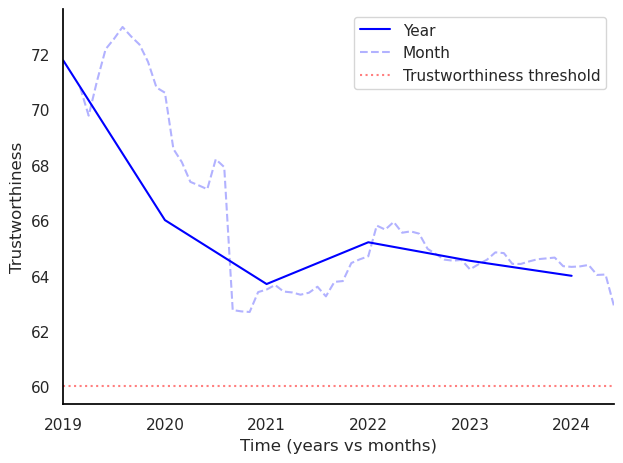

In [294]:
df_15.groupby(df_15.file_year).Score\
    .mean()\
    .plot(color="blue", label="Year")
df_15.groupby(df_15.file_month).Score\
    .mean()\
    .plot(color="blue", label="Month",
            alpha=0.3, linestyle="--")
plt.xlabel("Time (years vs months)")
plt.ylabel("Trustworthiness")
plt.axhline(y=60, 
            color= "red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.legend()
custom_plots()
plt.tight_layout()

plt.show()

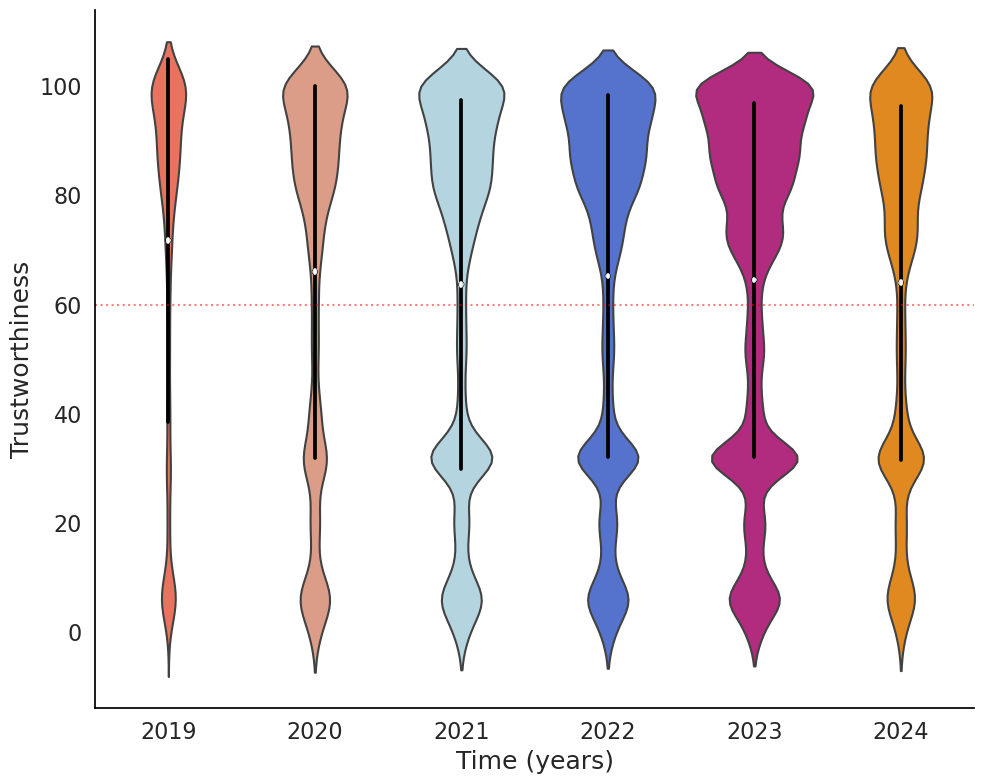

In [295]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 8))

#selected_ratings = ["T", "N"]
#df_selected_ratings = df_15[df_15["Rating"].isin(selected_ratings)]
year_colors = ["tomato", "darksalmon", "lightblue", "royalblue", "mediumvioletred", "darkorange"]

sns.violinplot(x="file_year", 
               y="Score",
               scale="count",
               data=df_15,
               inner=None,
               palette=year_colors)

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    errorbar="sd",   
    color="black",
    scale=0.5,
    join=False) 

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    color="white",  #white
    join=False,  
    markers="o",
    scale=0.4) 

plt.axhline(y=60, color="red", 
            linestyle="dotted",
            alpha=0.5, 
            label="Trustworthiness threshold")

plt.xlabel("Time (years)", fontsize=18)
plt.ylabel("Trustworthiness", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
custom_plots()

plt.show()

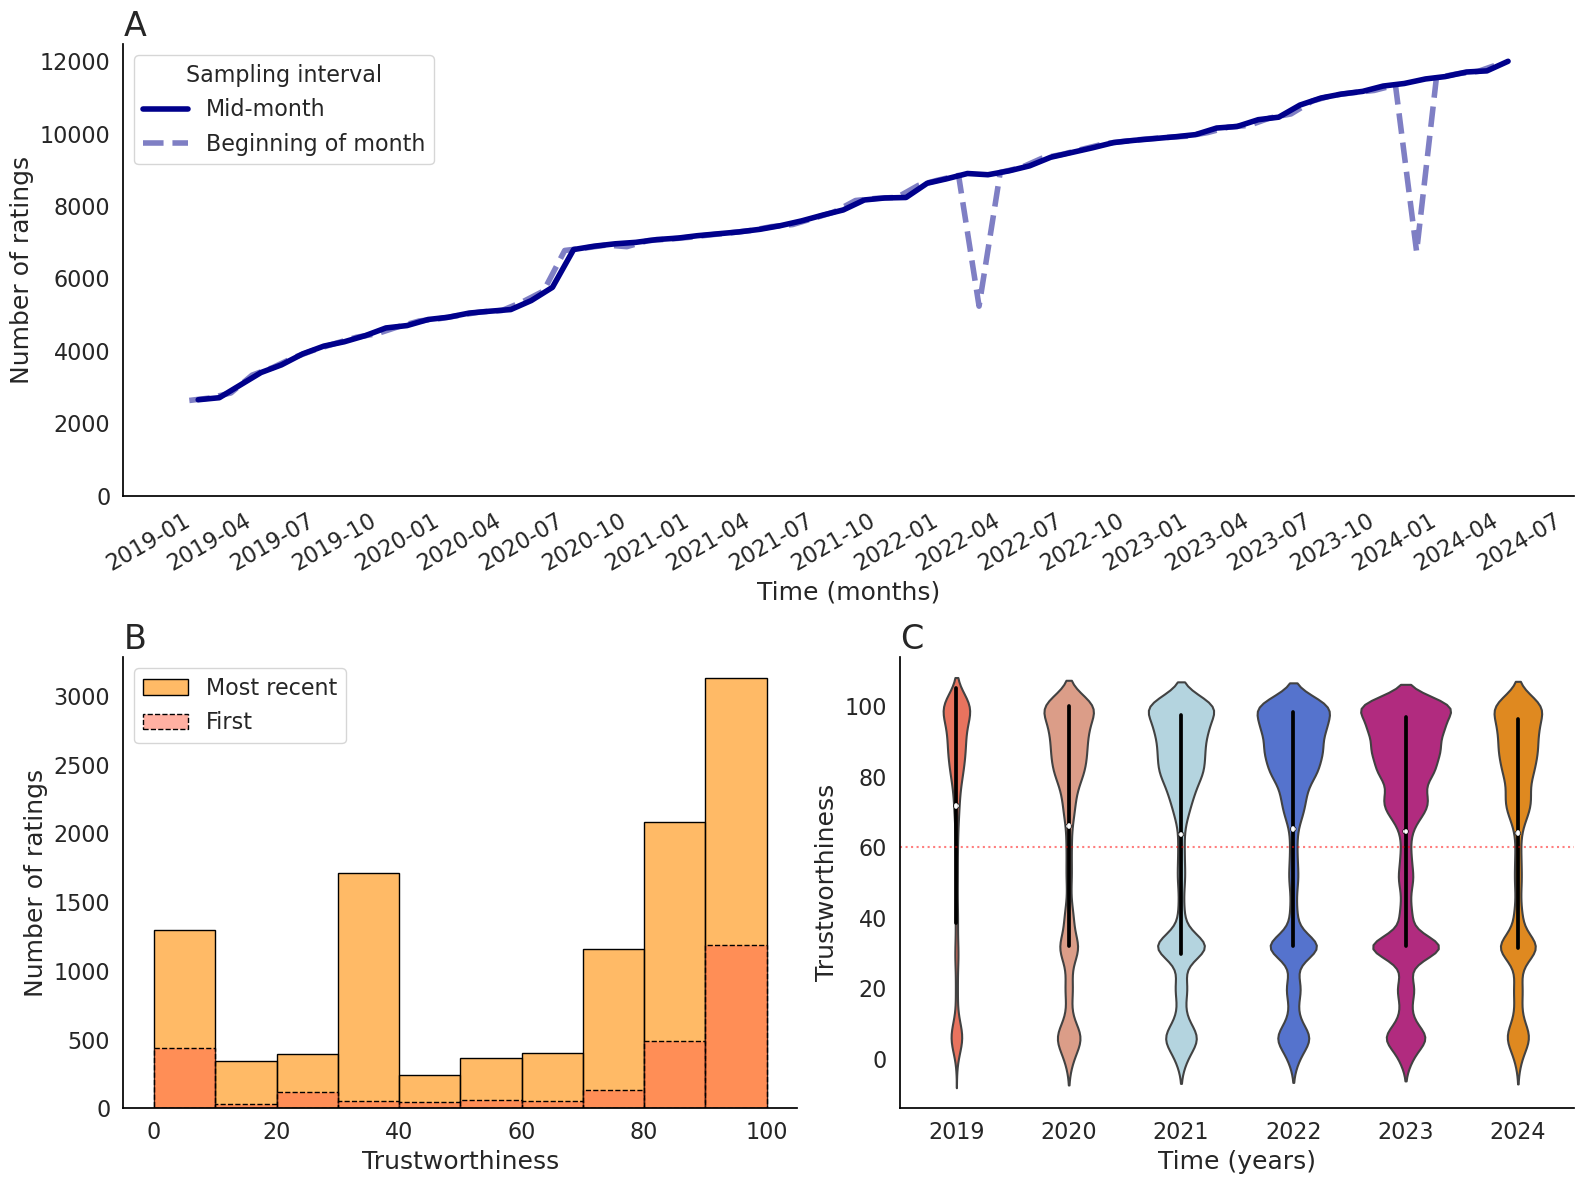

In [296]:
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, height_ratios=[2, 2])


ax1 = fig.add_subplot(gs[0, :])
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             color="darkblue",
             alpha=1,
             linewidth=4,
             label="Mid-month",
             ax=ax1)

sns.lineplot(data=counts_02, 
             x="file_date", 
             y="Counts", 
             color="darkblue",
             alpha=0.5,
             linewidth=4,
             linestyle="dashed",
             label="Beginning of month", 
             ax=ax1)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.tick_params(axis="x", labelsize=16, rotation=30)
ax1.tick_params(axis="y", labelsize=16)
ax1.set_ylim(0)
ax1.set_title("A", fontsize=24, loc="left")
ax1.set_xlabel("Time (months)", fontsize=18)
ax1.set_ylabel("Number of ratings", fontsize=18)
ax1.legend(title="Sampling interval", fontsize=16,
           title_fontsize=16)
custom_plots(ax=ax1)

ax2 = fig.add_subplot(gs[1, 0]) 
sns.histplot(data=df_recent, 
             x="Score", 
             bins=10, 
             alpha=0.6,
             edgecolor="black",
             color=year_colors[5],
             label="Most recent",
             ax=ax2)

sns.histplot(data=df_first,  
             x="Score",        
             bins=10,          
             edgecolor="black",
             color=year_colors[0],
             alpha=0.5,
             linestyle="dashed",
             label="First",
             ax=ax2)

ax2.set_xlabel("Trustworthiness", fontsize=18)
ax2.set_ylabel("Number of ratings", fontsize=18)
ax2.legend(fontsize=16)
ax2.set_title("B", fontsize=24, loc="left")
ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=16) 
custom_plots(ax=ax2)

ax3 = fig.add_subplot(gs[1, 1])
sns.violinplot(x="file_year", 
               y="Score",
               scale="count",
               data=df_15,
               inner=None,
               palette=year_colors,
               ax=ax3)

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    errorbar="sd",   
    color="black",
    scale=0.5,
    join=False,
    ax=ax3) 

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    color="white", 
    join=False,  
    markers="o",
    scale=0.4,
    ax=ax3) 

ax3.axhline(y=60, color="red", 
               linestyle="dotted",
               alpha=0.5, 
               label="Trustworthiness threshold")

ax3.set_xlabel("Time (years)", fontsize=18)
ax3.set_ylabel("Trustworthiness", fontsize=18)
ax3.set_title("C", fontsize=24, loc="left")
ax3.tick_params(axis="x", labelsize=16)
ax3.tick_params(axis="y", labelsize=16) 
custom_plots(ax=ax3)

plt.tight_layout()

plt.show()

### By added vs. removed sources

In [297]:
domain_changes_df_long = \
    domain_changes_df\
        .melt(id_vars="Date",
              value_vars=["Added", "Removed"],
              var_name="Change",
              value_name="Count")

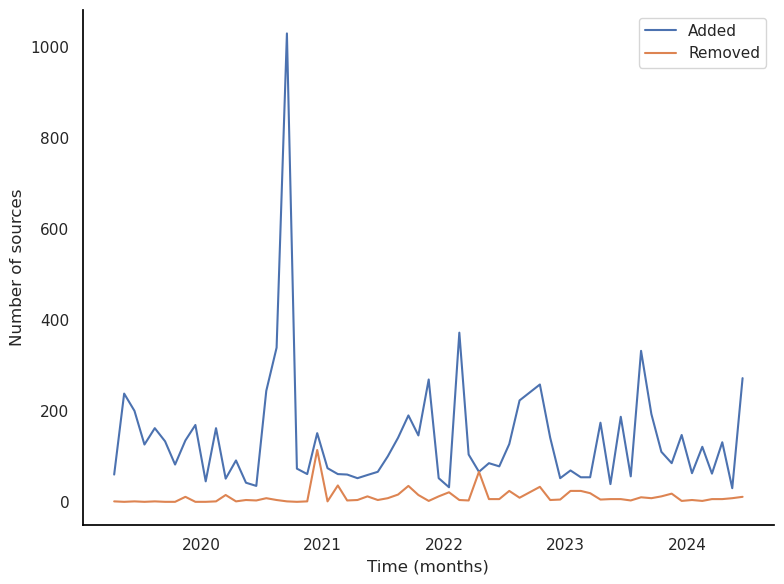

In [298]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=domain_changes_df_long,
             x="Date",
             y="Count",
             hue="Change")

plt.xlabel("Time (months)")
plt.ylabel("Number of sources") 
plt.legend()
custom_plots()
plt.tight_layout()
plt.savefig(join(figures_path,
                 "n_sources_added_removed.png"), 
                 dpi=300)                 
plt.show()

In [299]:
added_means = []
removed_means = []
added_sds = []
removed_sds = []
months = []

for date in domain_changes.keys():
    added_sources = df_15[df_15.Domain.isin(domain_changes[date][0])]
    removed_sources = df_15[df_15.Domain.isin(domain_changes[date][1])]

    added_mean = added_sources["Score"].mean()
    removed_mean = removed_sources["Score"].mean()
    added_sd = added_sources["Score"].std()
    removed_sd = removed_sources["Score"].std()

    added_means.append(added_mean)
    removed_means.append(removed_mean)
    added_sds.append(added_sd)
    removed_sds.append(removed_sd)
    months.append(date)

added_df = pd.DataFrame({
    "Date": months,
    "Added_Mean": added_means,
    "Added_SD": added_sds})

removed_df = pd.DataFrame({
    "Date": months,
    "Removed_Mean": removed_means,
    "Removed_SD": removed_sds})

added_df["Change"] = "Added"
added_df = added_df\
            .rename(
                columns={
                    "Added_Mean": "Mean", 
                    "Added_SD": "SD"})

removed_df["Change"] = "Removed"
removed_df = removed_df\
            .rename(
                columns={
                    "Removed_Mean": "Mean", 
                    "Removed_SD": "SD"})

averages_df = pd.concat([added_df, removed_df])

domain_changes_df_long = \
    domain_changes_df_long\
        .merge(averages_df, 
               on=["Date", "Change"])

In [300]:
domain_changes_df_long[domain_changes_df_long["Change"] == "Added"]\
    .sort_values(by="Count", 
                 ascending=False)\
    .head(3)

Date Change  Count       Mean         SD
17 2020-09-15 01:00:00  Added   1030  35.313857  14.187769
34 2022-02-15 01:00:00  Added    372  88.258903  15.658978
16 2020-08-15 01:00:00  Added    339  60.637473  35.697066

In [301]:
print(f'Added sources: '
        f'Mean={round(added_df["Mean"].mean(), 2)}, '
        f'SD={round(added_df["SD"].mean(), 2)}')
print(f'Removed sources: '
        f'Mean={round(removed_df["Mean"].mean(), 2)}, '
        f'SD={round(removed_df["SD"].mean(), 2)}')

Added sources: Mean=60.16, SD=27.52
Removed sources: Mean=54.54, SD=19.12


In [302]:
date_means = df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"file_date": "Date"})


domain_changes_df = date_means\
    .merge(domain_changes_df, 
           on="Date")

#calculate difference in subsequent dates in score
domain_changes_df = domain_changes_df.sort_values("Date")
domain_changes_df["Score_diff"] = domain_changes_df["Score"].diff()

In [303]:
top_changes = \
    domain_changes_df.reindex(domain_changes_df['Score_diff']\
                              .abs()\
                                .sort_values(ascending=False)\
                                    .index)\
                                    .head(5)
top_changes

Date      Score  Added  Removed  Score_diff
17 2020-09-15 01:00:00  62.753501   1030        1   -5.162048
10 2020-02-15 01:00:00  68.570712    162        1   -2.031907
1  2019-05-15 01:00:00  71.042249    238        0    1.268653
61 2024-06-15 01:00:00  62.895994    272       11   -1.140367
2  2019-06-15 01:00:00  72.173881    200        1    1.131632

### By country

In [304]:
list(domain_changes.keys())[17]

numpy.datetime64('2020-09-15T01:00:00.000000000')

In [305]:
#extract list of domains added
added_20200915 = \
    domain_changes[list(domain_changes.keys())[17]][0]

df_2015 = \
    df_15[df_15["file_date"] == list(
        domain_changes.keys())[17]]

df_2015_added = \
    df_2015[df_2015["Domain"]\
            .isin(added_20200915)][["Domain", "Country"]]

df_2015_added.Country.value_counts()

US     1015
ALL      15
IT        6
DE        5
FR        4
Name: Country, dtype: int64

In [306]:
country_count = df_15\
    .groupby("file_date")\
        .agg(
            Count=("Country", 
                   "nunique"),
            Score=("Score", 
                   "mean"),
            SD=("Score", 
                "std"),
            Countries=("Country", lambda x: ", ".join(sorted(x.unique())))
            )\
    .reset_index()

In [307]:
#remove something from strings
country_count["Added_Countries"] = country_count["Countries"]\
    .str.replace("ALL, GB, IT, US", "ALL, IT")\
    .str.replace("ALL, DE, FR, GB, IT, US", "DE, FR")\
    .str.replace("ALL, CA, DE, FR, GB, IT, US", "CA")\
    .str.replace("ALL, AU, CA, DE, FR, GB, IT, US", "AU")\
    .str.replace("ALL, AT, AU, CA, DE, FR, GB, IT, US", "AT")\
    .str.replace("ALL, AT, AU, CA, DE, FR, GB, IT, NZ, US", "NZ")

In [308]:
#from df_15, calculate the number of rows per country per file_date
country_size = df_15\
    .groupby(["file_date", "Country"])\
        .size()\
    .reset_index(name="Size")

#keep only the first ones
added_countries_size = country_size\
    .drop_duplicates(subset="Country", 
                     keep="first")

#per date, calculate sum of Size
added_countries_size = added_countries_size\
    .groupby("file_date")\
        .Size\
        .sum()\
        .reset_index(name="Added_Countries_Size")

In [309]:
#keep only dates with changes
country_change = \
    country_count[country_count["Count"].diff() != 0]

country_change = country_count\
    .merge(added_countries_size, 
           on="file_date")

In [310]:
#extract file_date and countries as dictionary
country_change_dict = country_change\
    .set_index("file_date")\
    .to_dict()["Added_Countries"]

#remove ALL
country_change_dict = {k: v.replace("ALL, ", "") for k, v in country_change_dict.items()}
country_change_dict

{Timestamp('2019-03-15 01:00:00'): 'GB, US',
 Timestamp('2019-05-15 01:00:00'): 'IT',
 Timestamp('2019-06-15 01:00:00'): 'DE, FR',
 Timestamp('2021-10-15 01:00:00'): 'CA',
 Timestamp('2022-07-15 01:00:00'): 'AU',
 Timestamp('2022-10-15 01:00:00'): 'AT',
 Timestamp('2023-01-15 01:00:00'): 'NZ'}

In [311]:
import emoji
#print list of codes for emojis
countries_split = country_change["Added_Countries"]\
    .str.split(", ")\
    .explode()\
    .unique()
countries_split = countries_split[countries_split != "ALL"]

#lower string
countries = [country.lower() for country in countries_split]

#ca to canada
countries = [country.replace("ca", "canada") for country in countries]
countries = [country.replace("au", "australia") for country in countries]
countries = [country.replace("at", "austria") for country in countries]
countries = [country.replace("nz", "new_zealand") for country in countries]

def get_flag(countries):
    return emoji.emojize(f':{countries}:', language='alias')

for country in countries:
    print(f'{country} {get_flag(country)}')

gb 🇬🇧
us 🇺🇸
it 🇮🇹
de 🇩🇪
fr 🇫🇷
canada 🇨🇦
australia 🇦🇺
austria 🇦🇹
new_zealand 🇳🇿


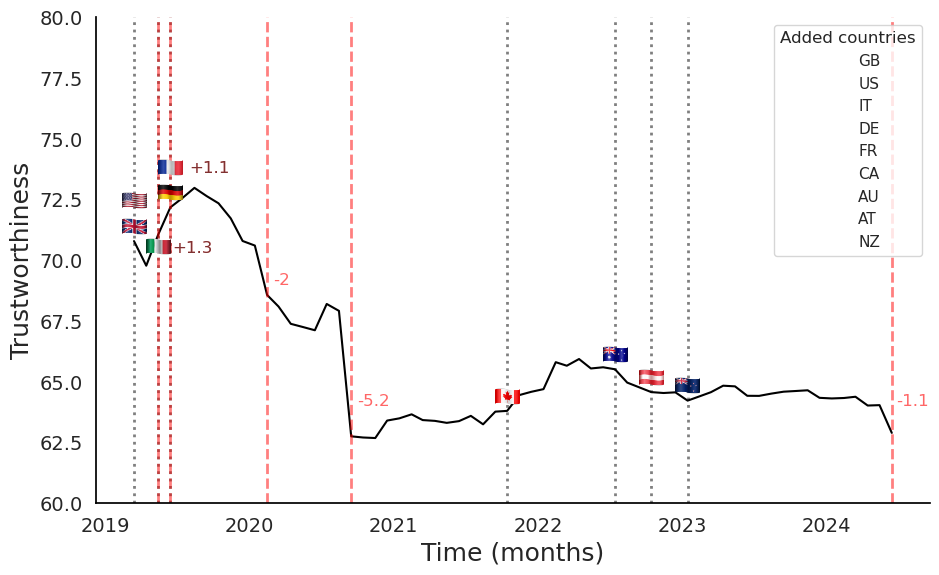

In [312]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=country_count, 
             x="file_date", 
             y="Score", 
             color="black",
             ax=ax)

#add sd as errorband
#ax.fill_between(country_count["file_date"], 
#                country_count["Score"] - (country_count["SD"]/2), 
#                country_count["Score"] + (country_count["SD"]/2), 
#                color="grey", 
#                alpha=0.2)

#add vertical lines 
norm = Normalize(vmin=0, vmax=len(country_change["file_date"]))
cmap = cm.viridis

#highlight country changes
for i, date in enumerate(country_change["file_date"]):
    color = cmap(norm(i))
    ax.axvline(pd.to_datetime(date), color="black", 
               alpha=0.5, linestyle=":", linewidth=2)

for i, date in enumerate(top_changes["Date"]):
    color = cmap(norm(i))
    ax.axvline(pd.to_datetime(date), color="red", 
               alpha=0.5, linestyle="--", linewidth=2)

#legend based on color
legend_elements = [Line2D([0], [0], color="black",
                            linestyle=":", 
                            label="Country changes"),
                     Line2D([0], [0], color="red",
                            linestyle="--", 
                            label="Top changes")]

ax.legend(handles=legend_elements,
          loc="upper left")

#add emoji flags
y_positions = {}
for date, countries in country_change_dict.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"

        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue

        flag = plt.imread(flag_path)
        country_x = pd.to_datetime(date)
        country_score = country_count.loc[
            country_count["file_date"] == date, 
                "Score"].iloc[0]

        if country == "IT":
            y_position = country_score + idx - 0.5
        else:
            if date in y_positions:
                y_position = country_score + idx + 0.65
            else:
                y_position = country_score + idx + 0.6
        
        imagebox = OffsetImage(flag, zoom=0.4) 
        ab = AnnotationBbox(imagebox, (country_x, y_position), 
                            frameon=False)
        ax.add_artist(ab)
        
        if date not in y_positions:
            y_positions[date] = [y_position]
        else:
            y_positions[date].append(y_position)

#add legend with flag emojis
legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax.plot([], [], 
                                       linestyle="none", 
                                       label=c)[0])

#only text
ax.annotate("-5.2",
            xy=(pd.to_datetime("2020-10-01"), 66), 
            xytext=(pd.to_datetime("2020-10-01"), 64),
            #arrowprops=dict(facecolor="black"),
            color="red", alpha=0.6,
            fontsize=12)

ax.annotate("-2", 
            xy=(pd.to_datetime("2020-03-01"), 69.5), 
            xytext=(pd.to_datetime("2020-03-01"), 69),
            #arrowprops=dict(facecolor="black"),
            color="red", alpha=0.6,
            fontsize=12)

ax.annotate("-1.1", 
            xy=(pd.to_datetime("2024-03-01"), 63.5), 
            xytext=(pd.to_datetime("2024-06-25"), 64),
            #arrowprops=dict(facecolor="black"),
            color="red", alpha=0.6,
            fontsize=12)

ax.annotate("+1.3", 
            xy=(pd.to_datetime("2019-05-15"), 71), 
            xytext=(pd.to_datetime("2019-06-20"), 70.3),
            #arrowprops=dict(facecolor="black"),
            color="red", alpha=0.6,
            fontsize=12)

ax.annotate("+1.3", 
            xy=(pd.to_datetime("2019-05-15"), 71), 
            xytext=(pd.to_datetime("2019-06-20"), 70.3),
            #arrowprops=dict(facecolor="black"),
            color="black", alpha=0.5,
            fontsize=12)

ax.annotate("+1.1", 
            xy=(pd.to_datetime("2019-06-15"), 63.5), 
            xytext=(pd.to_datetime("2019-08-01"), 73.6),
            #arrowprops=dict(facecolor="black"),
            color="red", alpha=0.6,
            fontsize=12)

ax.annotate("+1.1", 
            xy=(pd.to_datetime("2019-06-15"), 63.5), 
            xytext=(pd.to_datetime("2019-08-01"), 73.6),
            #arrowprops=dict(facecolor="black"),
            color="black", alpha=0.5,
            fontsize=12)


ax.legend(handles=legend_elements, 
          title="Added countries",
          loc="upper right",
          )
#dotted legend frame
#ax.get_legend().get_frame().set_linestyle(":")
#ax.get_legend().get_frame().set_edgecolor("black")

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(60,80)
ax.set_xlabel("Time (months)", fontsize=18)
ax.set_ylabel("Trustworthiness", fontsize=18)
custom_plots(ax=ax)
plt.tight_layout()

plt.show()

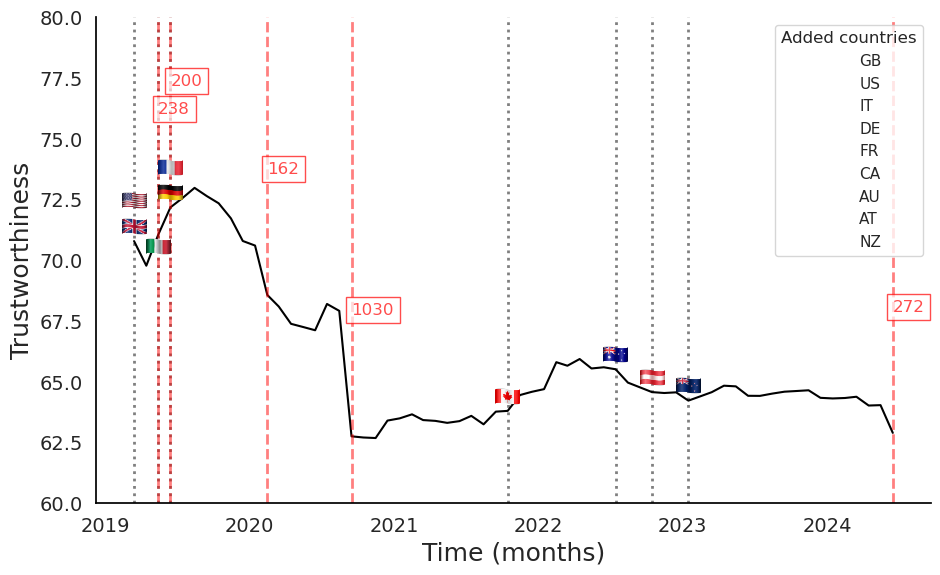

In [313]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=country_count, 
             x="file_date", 
             y="Score", 
             color="black",
             ax=ax)

#highlight country changes and add text with countries
for i, date in enumerate(country_change["file_date"]):
    ax.axvline(pd.to_datetime(date), color="black", 
               alpha=0.5, linestyle=":", linewidth=2)

for i, date in enumerate(top_changes["Date"]):
    ax.axvline(pd.to_datetime(date), color="red", 
               alpha=0.5, linestyle="--", linewidth=2)

#add text
for i, date in enumerate(top_changes["Date"]):
    ax.text(pd.to_datetime(date), 
            top_changes["Score"].iloc[i] + 5, 
            top_changes["Added"].iloc[i], 
            fontsize=12, 
            alpha=0.7,
            bbox=dict(facecolor='white',
                        alpha=0.7, 
                        edgecolor="red"),
            color="red")
    
#legend based on color
legend_elements = [Line2D([0], [0], color="black",
                            linestyle=":", 
                            label="Country changes"),
                     Line2D([0], [0], color="red",
                            linestyle="--", 
                            label="Top changes")]

ax.legend(handles=legend_elements,
          loc="upper left")

#add emoji flags
y_positions = {}
for date, countries in country_change_dict.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"

        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue

        flag = plt.imread(flag_path)
        country_x = pd.to_datetime(date)
        country_score = country_count.loc[
            country_count["file_date"] == date, 
                "Score"].iloc[0]

        if country == "IT":
            y_position = country_score + idx - 0.5
        else:
            if date in y_positions:
                y_position = country_score + idx + 0.65
            else:
                y_position = country_score + idx + 0.6
        
        imagebox = OffsetImage(flag, zoom=0.4) 
        ab = AnnotationBbox(imagebox, (country_x, y_position), 
                            frameon=False)
        ax.add_artist(ab)
        
        if date not in y_positions:
            y_positions[date] = [y_position]
        else:
            y_positions[date].append(y_position)

#add legend with flag emojis
legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax.plot([], [], 
                                       linestyle="none", 
                                       label=c)[0])

#only text
'''
ax.annotate("-5.2",
            xy=(pd.to_datetime("2020-06-15"), 64),
            #arrowprops=dict(facecolor="black"),
            color="black",
            fontsize=10)

ax.annotate("-2", 
            xy=(pd.to_datetime("2019-12-15"), 69.5), 
            color="black",
            fontsize=10)

ax.annotate("-1.1", 
            xy=(pd.to_datetime("2024-03-15"), 63), 
            color="black", 
            fontsize=10)

ax.annotate("+1.3", 
            xy=(pd.to_datetime("2019-06-15"), 70.4), 
            color="black", 
            fontsize=10)


ax.annotate("+1.1", 
            xy=(pd.to_datetime("2019-07-15"), 73.6), 
            color="black",
            fontsize=10)'''


ax.legend(handles=legend_elements, 
          title="Added countries",
          loc="upper right",
          )
#dotted legend frame
#ax.get_legend().get_frame().set_linestyle(":")
#ax.get_legend().get_frame().set_edgecolor("black")

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(60,80)
ax.set_xlabel("Time (months)", fontsize=18)
ax.set_ylabel("Trustworthiness", fontsize=18)
custom_plots(ax=ax)
plt.tight_layout()

#plt.savefig(join(figures_path,
#                    "score_change_countries_added.png"), 
#                    dpi=300)

plt.show()

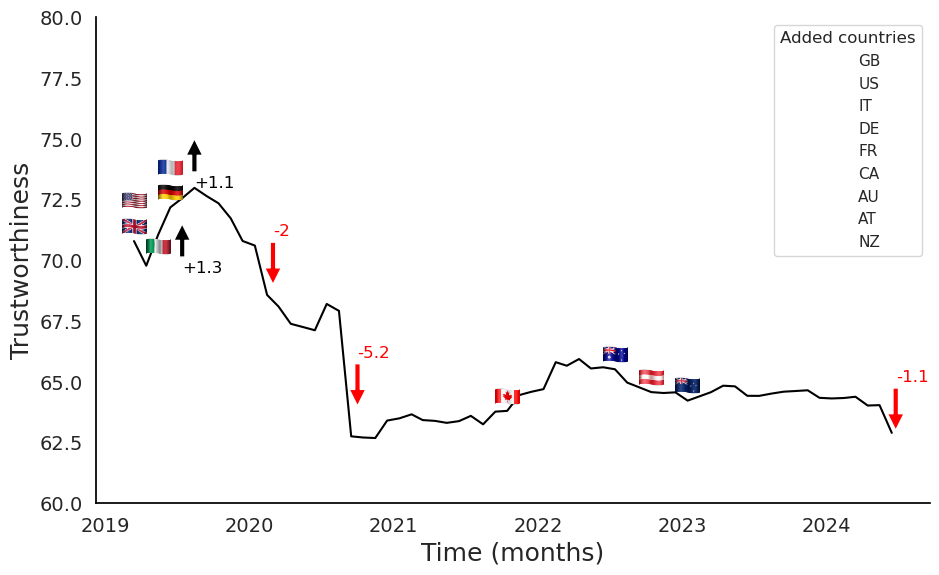

In [314]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=country_count, 
             x="file_date", 
             y="Score", 
             color="black",
             ax=ax)

#add emoji flags
y_positions = {}
for date, countries in country_change_dict.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"

        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue

        flag = plt.imread(flag_path)
        country_x = pd.to_datetime(date)
        country_score = country_count.loc[
            country_count["file_date"] == date, 
                "Score"].iloc[0]

        if country == "IT":
            y_position = country_score + idx - 0.5
        else:
            if date in y_positions:
                y_position = country_score + idx + 0.65
            else:
                y_position = country_score + idx + 0.6
        
        imagebox = OffsetImage(flag, zoom=0.4) 
        ab = AnnotationBbox(imagebox, (country_x, y_position), 
                            frameon=False)
        ax.add_artist(ab)
        
        if date not in y_positions:
            y_positions[date] = [y_position]
        else:
            y_positions[date].append(y_position)

#add legend with flag emojis
legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax.plot([], [], 
                                       linestyle="none", 
                                       label=c)[0])

#only text
ax.annotate("-5.2",
            xy=(pd.to_datetime("2020-10-01"), 64), 
            xytext=(pd.to_datetime("2020-10-01"), 66),
            arrowprops=dict(facecolor="red"),
            color="red", #alpha=0.6,
            fontsize=12)

ax.annotate("-2", 
            xy=(pd.to_datetime("2020-03-01"), 69), 
            xytext=(pd.to_datetime("2020-03-01"), 71),
            arrowprops=dict(facecolor="red"),
            color="red", #alpha=0.6,
            fontsize=12)

ax.annotate("-1.1", 
            xy=(pd.to_datetime("2024-06-25"), 63), 
            xytext=(pd.to_datetime("2024-06-25"), 65),
            arrowprops=dict(facecolor="red"),
            color="red", #alpha=0.6,
            fontsize=12)

ax.annotate("+1.3", 
            xy=(pd.to_datetime("2019-07-15"),71.5), 
            xytext=(pd.to_datetime("2019-07-15"), 69.5),
            arrowprops=dict(facecolor="black"),
            color="black", 
            fontsize=12)


ax.annotate("+1.1", 
            xy=(pd.to_datetime("2019-08-15"), 75), 
            xytext=(pd.to_datetime("2019-08-15"), 73),
            arrowprops=dict(facecolor="black"),
            color="black", 
            fontsize=12)


ax.legend(handles=legend_elements, 
          title="Added countries",
          loc="upper right",
          )
#dotted legend frame
#ax.get_legend().get_frame().set_linestyle(":")
#ax.get_legend().get_frame().set_edgecolor("black")

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(60,80)
ax.set_xlabel("Time (months)", fontsize=18)
ax.set_ylabel("Trustworthiness", fontsize=18)
custom_plots(ax=ax)
plt.tight_layout()


plt.show()

/tmp/ipykernel_2344688/3840449479.py:246: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


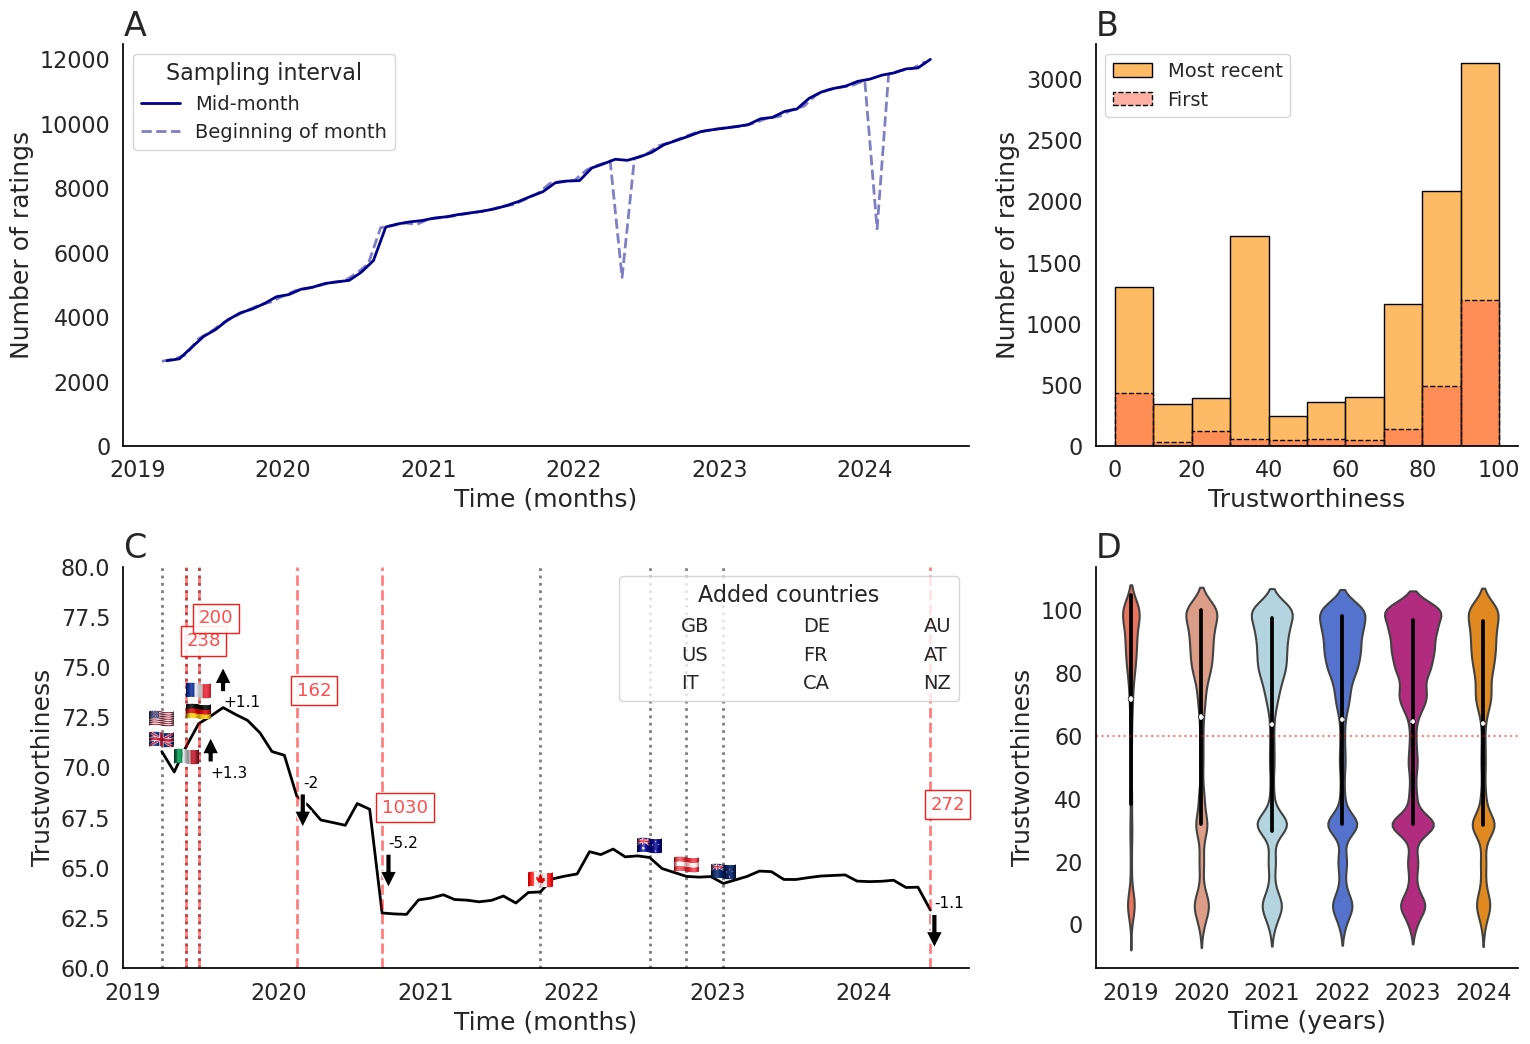

In [315]:
##adding everything together as one panel 
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, width_ratios=[2, 1], 
              #height_ratios=[2, 1], 
              #wspace=0.2, 
              hspace=0.3
              )

''' SUBPLOT A '''
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             color="darkblue",
             alpha=1,
             linewidth=2,
             label="Mid-month",
             ax=ax1)

sns.lineplot(data=counts_02,
                x="file_date",
                y="Counts",
                color="darkblue",
                alpha=0.5,
                linewidth=2,
                linestyle="dashed",
                label="Beginning of month",
                ax=ax1)

#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.tick_params(axis="x", labelsize=16, )
ax1.tick_params(axis="y", labelsize=16)
ax1.set_ylim(0)
ax1.set_title("A", fontsize=24, loc="left")
ax1.set_xlabel("Time (months)", fontsize=18)
ax1.set_ylabel("Number of ratings", fontsize=18)
ax1.legend(title="Sampling interval", fontsize=14,
           title_fontsize=16)
custom_plots(ax=ax1)

''' SUBPLOT B '''
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data=df_recent,
             x="Score",
             bins=10,
             alpha=0.6,
             edgecolor="black",
             color=year_colors[5],
             label="Most recent",
             ax=ax2)

sns.histplot(data=df_first,
                x="Score",
                bins=10,
                edgecolor="black",
                color=year_colors[0],
                alpha=0.5,
                linestyle="dashed",
                label="First",
                ax=ax2)

ax2.set_xlabel("Trustworthiness", fontsize=18)
ax2.set_ylabel("Number of ratings", fontsize=18)
ax2.legend(fontsize=14)
ax2.set_title("B", fontsize=24, loc="left")
ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=16)
custom_plots(ax=ax2)

''' SUBPLOT D'''
ax3 = fig.add_subplot(gs[1, 1])
sns.violinplot(x="file_year",
               y="Score",
               scale="count",
               data=df_15,
               inner=None,
               palette=year_colors,
               ax=ax3)

sns.pointplot(
    data=df_15,
    y="Score",
    x="file_year",
    estimator="mean",
    errorbar="sd",
    color="black",
    scale=0.5,
    join=False,
    ax=ax3)

sns.pointplot(
    data=df_15,
    y="Score",
    x="file_year",
    estimator="mean",
    color="white",
    join=False,
    markers="o",
    scale=0.4,
    ax=ax3)

ax3.axhline(y=60, color="red",
                linestyle="dotted",
                alpha=0.5,
                label="Trustworthiness threshold")

ax3.set_xlabel("Time (years)", fontsize=18)
ax3.set_ylabel("Trustworthiness", fontsize=18)
ax3.set_title("D", fontsize=24, loc="left")
ax3.tick_params(axis="x", labelsize=16)
ax3.tick_params(axis="y", labelsize=16)
custom_plots(ax=ax3)


''' SUBPLOT C '''
ax4 = fig.add_subplot(gs[1, 0])
sns.lineplot(data=country_count,
             x="file_date",
             y="Score",
             color="black",
             linewidth=2,
             ax=ax4)

#highlight country changes and add text with countries
for i, date in enumerate(country_change["file_date"]):
    ax4.axvline(pd.to_datetime(date), color="black", 
               alpha=0.5, linestyle=":", linewidth=2)

for i, date in enumerate(top_changes["Date"]):
    ax4.axvline(pd.to_datetime(date), color="red", 
               alpha=0.5, linestyle="--", linewidth=2)

#add text
for i, date in enumerate(top_changes["Date"]):
    ax4.text(pd.to_datetime(date), 
            top_changes["Score"].iloc[i] + 5, 
            top_changes["Added"].iloc[i], 
            fontsize=13, 
            alpha=0.7,
            bbox=dict(facecolor='white',
                        alpha=0.9, 
                        edgecolor="red"),
            color="red")
    

#add emoji flags
y_positions = {}
for date, countries in country_change_dict.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"

        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue

        flag = plt.imread(flag_path)
        country_x = pd.to_datetime(date)
        country_score = country_count.loc[
            country_count["file_date"] == date, 
                "Score"].iloc[0]

        if country == "IT":
            y_position = country_score + idx - 0.5
        else:
            if date in y_positions:
                y_position = country_score + idx + 0.65
            else:
                y_position = country_score + idx + 0.6
        
        imagebox = OffsetImage(flag, zoom=0.4) 
        ab = AnnotationBbox(imagebox, (country_x, y_position), 
                            frameon=False)
        ax4.add_artist(ab)
        
        if date not in y_positions:
            y_positions[date] = [y_position]
        else:
            y_positions[date].append(y_position)

#add legend with flag emojis
legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax4.plot([], [], 
                                       linestyle="none", 
                                       label=c)[0])
        
ax4.legend(handles=legend_elements,
              title="Added countries",
              loc="upper right",
              fontsize=14,
              ncol=3,
              title_fontsize=16)


ax4.annotate("-5.2",
            xy=(pd.to_datetime("2020-10-01"), 64), 
            xytext=(pd.to_datetime("2020-10-01"), 66),
            arrowprops=dict(facecolor="black"),
            color="black", #alpha=0.6,
            fontsize=11)

ax4.annotate("-2", 
            xy=(pd.to_datetime("2020-03-01"), 67), 
            xytext=(pd.to_datetime("2020-03-01"), 69),
            arrowprops=dict(facecolor="black"),
            color="black", #alpha=0.6,
            fontsize=11)

ax4.annotate("-1.1", 
            xy=(pd.to_datetime("2024-06-25"), 61), 
            xytext=(pd.to_datetime("2024-06-25"), 63),
            arrowprops=dict(facecolor="black"),
            color="black", #alpha=0.6,
            fontsize=11)

ax4.annotate("+1.3", 
            xy=(pd.to_datetime("2019-07-15"),71.5), 
            xytext=(pd.to_datetime("2019-07-15"), 69.5),
            arrowprops=dict(facecolor="black"),
            color="black", 
            fontsize=11)


ax4.annotate("+1.1", 
            xy=(pd.to_datetime("2019-08-15"), 75), 
            xytext=(pd.to_datetime("2019-08-15"), 73),
            arrowprops=dict(facecolor="black"),
            color="black", 
            fontsize=11)

ax4.set_title("C", fontsize=24, loc="left")
ax4.tick_params(axis="x", labelsize=16)
ax4.tick_params(axis="y", labelsize=16)
ax4.set_ylim(60,80)
ax4.set_xlabel("Time (months)", fontsize=18)
ax4.set_ylabel("Trustworthiness", fontsize=18)
custom_plots(ax=ax4)

plt.tight_layout()
plt.savefig(join(figures_path, "f1-panel.png"), dpi=300)
plt.show()

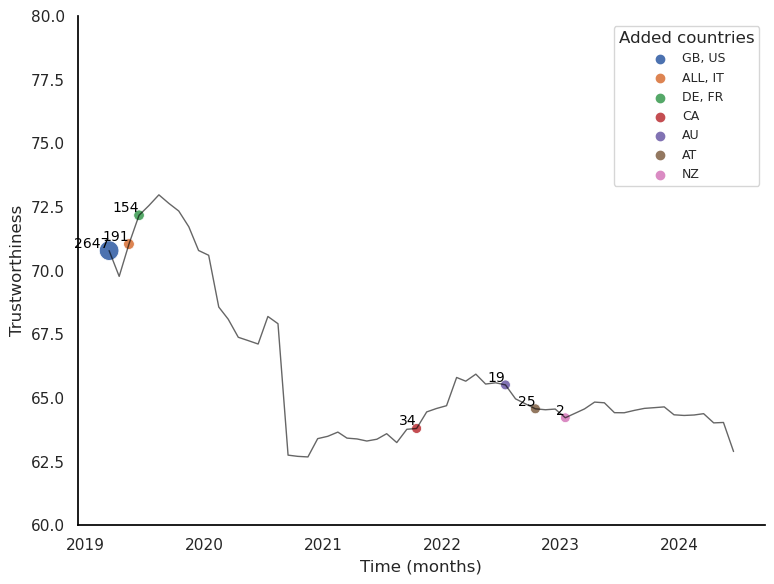

In [316]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=country_count, 
    x="file_date", 
    y="Score", 
    errorbar="sd",
    color="black", 
    estimator="mean",
    linestyle="-", 
    linewidth=1,
    alpha=0.6
    )

ax=sns.scatterplot(data=country_change, 
                x="file_date", 
                y="Score",
                hue="Added_Countries",
                size="Added_Countries_Size",
                sizes=(50, 200),
                )

#add size as text
for line in range(0,country_change.shape[0]):
    ax.text(country_change.file_date.iloc[line], 
            country_change.Score.iloc[line], 
            country_change.Added_Countries_Size.iloc[line], 
            horizontalalignment="right", 
            verticalalignment="bottom",
            size="small", 
            color="black")

h, l = ax.get_legend_handles_labels()
ax.legend(h[1:8], l[1:8], 
          bbox_to_anchor=(0.78, 0.98), 
          loc=2, 
          borderaxespad=0., 
          fontsize=9,
          title="Added countries")

plt.xlabel("Time (months)")
plt.ylabel("Trustworthiness")
plt.ylim(60, 80)
custom_plots()

plt.tight_layout()

plt.show()

### Updates

In [317]:
df_15["Last Updated"]=pd.to_datetime(df_15["Last Updated"],unit="ms")
df_15["Last Updated"].head(3)

0   2018-07-20 14:03:17.020
1   2018-07-20 14:03:21.115
2   2018-07-20 14:03:25.883
Name: Last Updated, dtype: datetime64[ns]

In [318]:
#inspect the duplicates
df_dups = \
    df_recent[df_recent\
              .duplicated(
                  subset="UUID",
                  keep=False)]

df_dups[["UUID", "Domain", 
            "Parent Domain", "Country", 
            "Language", "Score"]]\
            .sort_values(by="UUID")\
            .head(5)

UUID  \
3128  0136ea76-696e-4d21-8e56-e19192b37f70   
3125  0136ea76-696e-4d21-8e56-e19192b37f70   
3127  0136ea76-696e-4d21-8e56-e19192b37f70   
3126  0136ea76-696e-4d21-8e56-e19192b37f70   
1480  01a17c37-0de4-4f94-b50b-000c78497ee4   

                                    Domain        Parent Domain Country  \
3128     video.gazzettadireggio.gelocal.it  gazzettadireggio.it      IT   
3125                   gazzettadireggio.it  gazzettadireggio.it      IT   
3127           gazzettadireggio.gelocal.it  gazzettadireggio.it      IT   
3126  elezioni.gazzettadireggio.gelocal.it  gazzettadireggio.it      IT   
1480                      fr.news-front.su     fr.news-front.su      FR   

     Language  Score  
3128       it   82.5  
3125       it   82.5  
3127       it   82.5  
3126       it   82.5  
1480       fr    7.5

In [319]:
df_15_UUID = \
    df_15.drop_duplicates(
        subset=["UUID", "Domain"], 
        keep="first")

print(f'Without UUID length = {len(df_15)}, '
      f'with UUID = {len(df_15_UUID)}.')

Without UUID length = 491774, with UUID = 57486.


In [320]:
df_dups[df_dups.duplicated(keep=False)] #only 2 are identical

UUID        Domain Parent Domain Rating  \
4078  b20d2da1-f2a3-4152-bee9-266682ed0d1c  rubikon.news  rubikon.news      N   
4079  b20d2da1-f2a3-4152-bee9-266682ed0d1c  rubikon.news  rubikon.news      N   
4080  51a17041-a8db-48ce-a5ba-a8c5028de963  rubikon.news  rubikon.news      N   
4081  51a17041-a8db-48ce-a5ba-a8c5028de963  rubikon.news  rubikon.news      N   

      Score   Last Updated Country Language  \
4078   35.0  1704292105369     ALL       en   
4079   35.0  1704292105369     ALL       en   
4080   35.0  1704292100290      DE       de   
4081   35.0  1704292100290      DE       de   

     Does not repeatedly publish false content  \
4078                                       NaN   
4079                                       NaN   
4080                                       NaN   
4081                                       NaN   

     Gathers and presents information responsibly  ... LINKEDIN IOSAPP  \
4078                                           No  ...      NaN    NaN   
4079                                           No  ...      NaN    NaN   
4080                                           No  ...      NaN    NaN   
4081                                           No  ...      NaN    NaN   

     ANDROIDAPP OTHER Contact Mail Form URL.1 Communities Served  \
4078        NaN   NaN                     NaN                NaN   
4079        NaN   NaN                     NaN                NaN   
4080        NaN   NaN                     NaN                NaN   
4081        NaN   NaN                     NaN                NaN   

                                    BrandGuard Segments  \
4078  Exclusion - Maximum Safety,Exclusion - High Sa...   
4079  Exclusion - Maximum Safety,Exclusion - High Sa...   
4080  Exclusion - Maximum Safety,Exclusion - High Sa...   
4081  Exclusion - Maximum Safety,Exclusion - High Sa...   

                                       False Narratives  \
4078  cfedb324-e47a-4a7f-b533-6c0dc5ed543c,7e70934d-...   
4079  cfedb324-e47a-4a7f-b533-6c0dc5ed543c,7e70934d-...   
4080  cfedb324-e47a-4a7f-b533-6c0dc5ed543c,7e70934d-...   
4081  cfedb324-e47a-4a7f-b533-6c0dc5ed543c,7e70934d-...   

     Does not repeatedly publish false or egregiously misleading content  \
4078                                                 No                    
4079                                                 No                    
4080                                                 No                    
4081                                                 No                    

     Has effective practices for correcting errors  
4078                                            No  
4079                                            No  
4080                                            No  
4081                                            No  

[4 rows x 65 columns]

In [321]:
df_15_sorted = \
    df_15.groupby(["Domain", "Country", "Language"],
                    group_keys=False)\
            .apply(lambda x: x\
            .sort_values("file_date",
                            ascending=True))\
            .reset_index(drop=True)

df_15_updates = \
    df_15_sorted[[
        "Domain", "Parent Domain", "Country", 
        "Language", "file_date", "Last Updated", 
        "Score", 
        "Does not repeatedly publish false content",
        "Does not repeatedly publish false or egregiously misleading content",
        "Gathers and presents information responsibly",
        "Regularly corrects or clarifies errors",
        "Has effective practices for correcting errors",
        "Handles the difference between news and opinion responsibly",
        "Avoids deceptive headlines",
        "Website discloses ownership and financing",
        "Clearly labels advertising",
        "Reveals who's in charge, including any possible conflicts of interest",
        "The site provides names of content creators, along with either contact or biographical information"]]

df_15_updates

Domain Parent Domain Country Language           file_date  \
0             0372.ua           NaN      US       en 2024-06-15 01:00:00   
1       1000logos.net           NaN      US       en 2023-10-15 01:00:00   
2       1000logos.net           NaN      US       en 2023-11-15 01:00:00   
3       1000logos.net           NaN      US       en 2023-12-15 01:00:00   
4       1000logos.net           NaN      US       en 2024-01-15 01:00:00   
...               ...           ...     ...      ...                 ...   
491769         zvw.de           NaN      DE       de 2024-02-15 01:00:00   
491770         zvw.de           NaN      DE       de 2024-03-15 01:00:00   
491771         zvw.de           NaN      DE       de 2024-04-15 01:00:00   
491772         zvw.de           NaN      DE       de 2024-05-15 01:00:00   
491773         zvw.de           NaN      DE       de 2024-06-15 01:00:00   

                  Last Updated  Score  \
0      2024-05-26 19:52:03.271   80.0   
1      2023-09-27 04:25:20.721    NaN   
2      2023-09-27 04:25:20.721    NaN   
3      2023-09-27 04:25:20.721    NaN   
4      2023-09-27 04:25:20.721    NaN   
...                        ...    ...   
491769 2022-12-27 10:52:01.602  100.0   
491770 2022-12-27 10:52:01.602  100.0   
491771 2022-12-27 10:52:01.602  100.0   
491772 2022-12-27 10:52:01.602  100.0   
491773 2022-12-27 10:52:01.602  100.0   

       Does not repeatedly publish false content  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
491769                                       NaN   
491770                                       NaN   
491771                                       NaN   
491772                                       NaN   
491773                                       NaN   

       Does not repeatedly publish false or egregiously misleading content  \
0                                                     Yes                    
1                                                     NaN                    
2                                                     NaN                    
3                                                     NaN                    
4                                                     NaN                    
...                                                   ...                    
491769                                                Yes                    
491770                                                Yes                    
491771                                                Yes                    
491772                                                Yes                    
491773                                                Yes                    

       Gathers and presents information responsibly  \
0                                               Yes   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
...                                             ...   
491769                                          Yes   
491770                                          Yes   
491771                                          Yes   
491772                                          Yes   
491773                                          Yes   

       Regularly corrects or clarifies errors  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
...                                       ...   
491769                                    N

In [322]:
#size of each date
updates_summary = df_15_updates\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_All")

#add means 
updates_means = df_15_updates \
    .groupby("file_date")["Score"]\
        .mean()\
    .reset_index(name="Mean_All")

#merge
updates_summary = updates_summary\
    .merge(updates_means, 
           on="file_date")   

updates_summary.head(3)

file_date  Count_All   Mean_All
0 2019-03-15 01:00:00       2647  70.786424
1 2019-04-15 01:00:00       2704  69.773596
2 2019-05-15 01:00:00       3047  71.042249

In [323]:
#differences in updated and score
df_15_updates["Score_diff"] = \
    df_15_updates.groupby(["Domain", "Country", "Language"])["Score"].diff()

df_15_updates["Updated_diff"] = \
    df_15_updates.groupby(["Domain", "Country", "Language"])["Last Updated"].diff()

df_15_updates.head(10)

/tmp/ipykernel_2344688/3341911698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15_updates["Score_diff"] = \
/tmp/ipykernel_2344688/3341911698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15_updates["Updated_diff"] = \


Domain Parent Domain Country Language           file_date  \
0        0372.ua           NaN      US       en 2024-06-15 01:00:00   
1  1000logos.net           NaN      US       en 2023-10-15 01:00:00   
2  1000logos.net           NaN      US       en 2023-11-15 01:00:00   
3  1000logos.net           NaN      US       en 2023-12-15 01:00:00   
4  1000logos.net           NaN      US       en 2024-01-15 01:00:00   
5  1000logos.net           NaN      US       en 2024-02-15 01:00:00   
6  1000logos.net           NaN      US       en 2024-03-15 01:00:00   
7  1000logos.net           NaN      US       en 2024-04-15 01:00:00   
8  1000logos.net           NaN      US       en 2024-05-15 01:00:00   
9  1000logos.net           NaN      US       en 2024-06-15 01:00:00   

             Last Updated  Score Does not repeatedly publish false content  \
0 2024-05-26 19:52:03.271   80.0                                       NaN   
1 2023-09-27 04:25:20.721    NaN                                       NaN   
2 2023-09-27 04:25:20.721    NaN                                       NaN   
3 2023-09-27 04:25:20.721    NaN                                       NaN   
4 2023-09-27 04:25:20.721    NaN                                       NaN   
5 2023-09-27 04:25:20.721    NaN                                       NaN   
6 2023-09-27 04:25:20.721    NaN                                       NaN   
7 2023-09-27 04:25:20.721    NaN                                       NaN   
8 2023-09-27 04:25:20.721    NaN                                       NaN   
9 2023-09-27 04:25:20.721    NaN                                       NaN   

  Does not repeatedly publish false or egregiously misleading content  \
0                                                Yes                    
1                                                NaN                    
2                                                NaN                    
3                                                NaN                    
4                                                NaN                    
5                                                NaN                    
6                                                NaN                    
7                                                NaN                    
8                                                NaN                    
9                                                NaN                    

  Gathers and presents information responsibly  \
0                                          Yes   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
5                                          NaN   
6                                          NaN   
7                                          NaN   
8                                          NaN   
9                                          NaN   

  Regularly corrects or clarifies errors  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                                    NaN   
6                                    NaN   
7                                    NaN   
8                                    NaN   
9                                    NaN   

  Has effective practices for correcting errors  \
0                                            No   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   
5                                           NaN   
6                                           NaN   
7                                           NaN   
8                                           NaN   
9                  

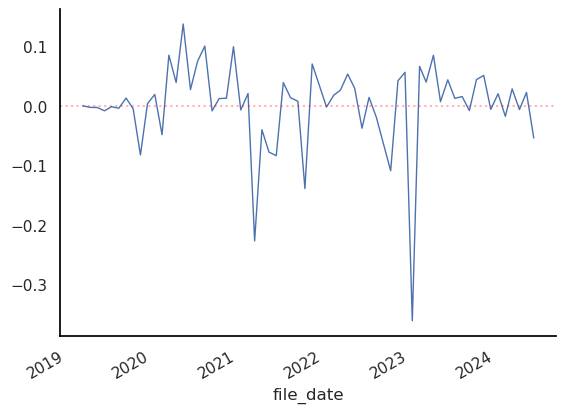

In [324]:
#when were the biggest changes?
df_15_updates\
    .groupby(df_15_updates["file_date"])["Score_diff"]\
    .mean()\
    .plot(linewidth=1)
plt.axhline(0, color="red", linestyle=":", alpha=0.3)
custom_plots()

In [325]:
#filter out the ones that have never been updated
df_15_updates["Added"] = \
    df_15_updates\
        .apply(lambda row: pd.isna(row["Updated_diff"]), axis=1) #where there is no prior date to compare to
df_15_updates

/tmp/ipykernel_2344688/1395840444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15_updates["Added"] = \


Domain Parent Domain Country Language           file_date  \
0             0372.ua           NaN      US       en 2024-06-15 01:00:00   
1       1000logos.net           NaN      US       en 2023-10-15 01:00:00   
2       1000logos.net           NaN      US       en 2023-11-15 01:00:00   
3       1000logos.net           NaN      US       en 2023-12-15 01:00:00   
4       1000logos.net           NaN      US       en 2024-01-15 01:00:00   
...               ...           ...     ...      ...                 ...   
491769         zvw.de           NaN      DE       de 2024-02-15 01:00:00   
491770         zvw.de           NaN      DE       de 2024-03-15 01:00:00   
491771         zvw.de           NaN      DE       de 2024-04-15 01:00:00   
491772         zvw.de           NaN      DE       de 2024-05-15 01:00:00   
491773         zvw.de           NaN      DE       de 2024-06-15 01:00:00   

                  Last Updated  Score  \
0      2024-05-26 19:52:03.271   80.0   
1      2023-09-27 04:25:20.721    NaN   
2      2023-09-27 04:25:20.721    NaN   
3      2023-09-27 04:25:20.721    NaN   
4      2023-09-27 04:25:20.721    NaN   
...                        ...    ...   
491769 2022-12-27 10:52:01.602  100.0   
491770 2022-12-27 10:52:01.602  100.0   
491771 2022-12-27 10:52:01.602  100.0   
491772 2022-12-27 10:52:01.602  100.0   
491773 2022-12-27 10:52:01.602  100.0   

       Does not repeatedly publish false content  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
491769                                       NaN   
491770                                       NaN   
491771                                       NaN   
491772                                       NaN   
491773                                       NaN   

       Does not repeatedly publish false or egregiously misleading content  \
0                                                     Yes                    
1                                                     NaN                    
2                                                     NaN                    
3                                                     NaN                    
4                                                     NaN                    
...                                                   ...                    
491769                                                Yes                    
491770                                                Yes                    
491771                                                Yes                    
491772                                                Yes                    
491773                                                Yes                    

       Gathers and presents information responsibly  ...  \
0                                               Yes  ...   
1                                               NaN  ...   
2                                               NaN  ...   
3                                               NaN  ...   
4                                               NaN  ...   
...                                             ...  ...   
491769                                          Yes  ...   
491770                                          Yes  ...   
491771                                          Yes  ...   
491772                                          Yes  ...   
491773                                          Yes  ...   

       Has effective practices for correcting errors  \
0                                                 No   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                             

In [326]:
#Updated == True when time_diff is not 0 or not NaN
df_15_updates["Updated"] = \
    df_15_updates\
        .apply(lambda row: 
               not pd.isna(row["Updated_diff"]) and #added
               row["Updated_diff"] != pd.Timedelta(0), axis=1) #actual time difference

df_15_updates.head(5)

/tmp/ipykernel_2344688/1902542659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15_updates["Updated"] = \


Domain Parent Domain Country Language           file_date  \
0        0372.ua           NaN      US       en 2024-06-15 01:00:00   
1  1000logos.net           NaN      US       en 2023-10-15 01:00:00   
2  1000logos.net           NaN      US       en 2023-11-15 01:00:00   
3  1000logos.net           NaN      US       en 2023-12-15 01:00:00   
4  1000logos.net           NaN      US       en 2024-01-15 01:00:00   

             Last Updated  Score Does not repeatedly publish false content  \
0 2024-05-26 19:52:03.271   80.0                                       NaN   
1 2023-09-27 04:25:20.721    NaN                                       NaN   
2 2023-09-27 04:25:20.721    NaN                                       NaN   
3 2023-09-27 04:25:20.721    NaN                                       NaN   
4 2023-09-27 04:25:20.721    NaN                                       NaN   

  Does not repeatedly publish false or egregiously misleading content  \
0                                                Yes                    
1                                                NaN                    
2                                                NaN                    
3                                                NaN                    
4                                                NaN                    

  Gathers and presents information responsibly  ...  \
0                                          Yes  ...   
1                                          NaN  ...   
2                                          NaN  ...   
3                                          NaN  ...   
4                                          NaN  ...   

  Handles the difference between news and opinion responsibly  \
0                                                Yes            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

  Avoids deceptive headlines Website discloses ownership and financing  \
0                        Yes                                       Yes   
1                        NaN                                       NaN   
2                        NaN                                       NaN   
3                        NaN                                       NaN   
4                        NaN                                       NaN   

  Clearly labels advertising  \
0                         No   
1                        NaN   
2                        NaN   
3                        NaN   
4                        NaN   

  Reveals who's in charge, including any possible conflicts of interest  \
0                                                Yes                      
1                                                NaN                      
2                                                NaN                      
3                                                NaN                      
4                                                NaN                      

  The site provides names of content creators, along with either contact or biographical information  \
0                                                Yes                                                   
1                                                NaN                                                   
2                                                NaN                                                   
3                                                NaN                                                   
4                                                NaN                                                   

  Score_diff Updated_diff  Added Updated  
0        NaN          NaT   True   False  
1        NaN          NaT   True   False  
2        NaN       0 days  False   False  
3        NaN       0 days  False   False  
4        NaN       0 day

In [327]:
added_df_15 = df_15_updates[df_15_updates["Added"] == True] #only the freshly added ones 

added_counts = added_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Added")

added_means = added_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Added"})

updates_summary = \
    updates_summary\
        .merge(added_counts, 
               on="file_date", 
               how="left")\
        .merge(added_means, 
               on="file_date", 
               how="left")

updates_summary

file_date  Count_All   Mean_All  Count_Added  Mean_Added
0  2019-03-15 01:00:00       2647  70.786424         2645   70.800421
1  2019-04-15 01:00:00       2704  69.773596           61   25.144068
2  2019-05-15 01:00:00       3047  71.042249          334   81.140673
3  2019-06-15 01:00:00       3399  72.173881          365   82.238095
4  2019-07-15 01:00:00       3611  72.550352          212   78.726829
..                 ...        ...        ...          ...         ...
58 2024-02-15 01:00:00      11510  64.330446          127   73.939024
59 2024-03-15 01:00:00      11576  64.382001           71   67.242857
60 2024-04-15 01:00:00      11702  64.020407          130   20.307692
61 2024-05-15 01:00:00      11733  64.036361           35   60.857143
62 2024-06-15 01:00:00      11998  62.895994          274   17.357414

[63 rows x 5 columns]

In [328]:
#only the ones that were already in the database
included_df_15 = df_15_updates[df_15_updates["Added"] == False]

included_counts = included_df_15 \
    .groupby("file_date") \
        .size() \
    .reset_index(name="Count_Included")

included_means = included_df_15 \
    .groupby("file_date")["Score"] \
    .mean() \
    .reset_index() \
    .rename(columns={"Score": "Mean_Included"})

updates_summary = \
    updates_summary \
        .merge(included_counts, 
               on="file_date", 
               how="left") \
        .merge(included_means, 
               on="file_date", 
               how="left")

In [329]:
#updated/checked sources
updated_df_15 = df_15_updates[df_15_updates["Updated"] == True]

updated_counts = updated_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Updated")

updated_means = updated_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Updated"})

updates_summary = \
    updates_summary\
        .merge(updated_counts, 
               on="file_date", 
               how="left")\
        .merge(updated_means, 
               on="file_date", 
               how="left")

In [330]:
#included but not updated
not_updated_df_15 = included_df_15[included_df_15["Updated"] == False]

not_updated_counts = not_updated_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Not_Updated")

not_updated_means = not_updated_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Not_Updated"})

updates_summary = \
    updates_summary\
        .merge(not_updated_counts, 
               on="file_date", 
               how="left")\
        .merge(not_updated_means, 
               on="file_date", 
               how="left")

In [331]:
df_15_updates["Changed"] = df_15_updates\
    .apply(lambda row: 
           row["Score_diff"] != 0 and not pd.isna(row["Score_diff"]),
             axis=1)

changed_df_15 = df_15_updates[df_15_updates["Changed"] == True]


changed_counts = changed_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Changed")

changed_means = changed_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Changed"})

updates_summary = \
    updates_summary\
        .merge(changed_counts, 
               on="file_date", 
               how="left")\
        .merge(changed_means, 
               on="file_date", 
               how="left")

/tmp/ipykernel_2344688/3152053846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15_updates["Changed"] = df_15_updates\


In [332]:
stable_df_15 = df_15_updates[(df_15_updates["Changed"] == False) & (df_15_updates["Updated"] == True)] #updated but never changed

#count number of sources per date
stable_counts = stable_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Stable")

stable_means = stable_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Stable"})

updates_summary = \
    updates_summary\
        .merge(stable_counts, 
               on="file_date", 
               how="left")\
        .merge(stable_means, 
               on="file_date", 
               how="left")
updates_summary

file_date  Count_All   Mean_All  Count_Added  Mean_Added  \
0  2019-03-15 01:00:00       2647  70.786424         2645   70.800421   
1  2019-04-15 01:00:00       2704  69.773596           61   25.144068   
2  2019-05-15 01:00:00       3047  71.042249          334   81.140673   
3  2019-06-15 01:00:00       3399  72.173881          365   82.238095   
4  2019-07-15 01:00:00       3611  72.550352          212   78.726829   
..                 ...        ...        ...          ...         ...   
58 2024-02-15 01:00:00      11510  64.330446          127   73.939024   
59 2024-03-15 01:00:00      11576  64.382001           71   67.242857   
60 2024-04-15 01:00:00      11702  64.020407          130   20.307692   
61 2024-05-15 01:00:00      11733  64.036361           35   60.857143   
62 2024-06-15 01:00:00      11998  62.895994          274   17.357414   

    Count_Included  Mean_Included  Count_Updated  Mean_Updated  \
0                2      52.500000              2     52.500000   
1             2643      70.782076            287     16.036842   
2             2713      69.809630            109     57.899083   
3             3034      70.973438            116     62.813043   
4             3399      72.172388             89     83.687500   
..             ...            ...            ...           ...   
58           11383      64.293614            361     58.199438   
59           11505      64.372671           1405     40.577006   
60           11572      64.389993           1425     39.089185   
61           11698      64.044566            652     57.795349   
62           11724      63.997700            921     25.818281   

    Count_Not_Updated  Mean_Not_Updated  Count_Changed  Mean_Changed  \
0                 NaN               NaN            NaN           NaN   
1              2356.0         77.489897           16.0     68.343750   
2              2604.0         70.314786            5.0     83.400000   
3              2918.0         71.299514           20.0     75.950000   
4              3310.0         71.861741           36.0     87.625000   
..                ...               ...            ...           ...   
58            11022.0         64.503433           75.0     66.020000   
59            10100.0         67.930805           66.0     69.636364   
60            10147.0         68.247832           83.0     75.066265   
61            11046.0         64.439583           79.0     60.778481   
62            10803.0         67.523312          118.0     47.389831   

    Count_Stable  Mean_Stable  
0              2    52.500000  
1            271    12.925651  
2            104    56.673077  
3             96    60.047368  
4             53    80.961538  
..           ...          ...  
58           286    56.112100  
59          1339    39.134962  
60          1342    36.862416  
61           573    57.378975  
62           803    22.640449  

[63 rows x 15 columns]

In [333]:
#for each domain, what is the average time to get an update?
updated_time_means = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Updated_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Updated_diff": "Updated_mean"})

updated_time_means["Updated_mean"].describe()

count                          10802
mean     248 days 19:17:43.760109536
std      107 days 06:11:16.963900900
min                -1 days +19:00:00
25%         162 days 03:23:33.342400
50%         255 days 11:18:48.189750
75%      332 days 18:45:13.694237500
max         790 days 14:27:07.865000
Name: Updated_mean, dtype: object

In [334]:
#for each domain, what is the average change in score?
updated_means = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Score_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score_diff": "Updated_mean"})

updated_means["Updated_mean"].describe()

count    10679.000000
mean        -0.051753
std          3.382137
min        -50.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.000000
Name: Updated_mean, dtype: float64

In [335]:
#per domain, what is the number of times the score has actually changed?
score_changes = df_15_updates\
    .groupby(["Domain", "Country", "Language"])["Changed"]\
    .sum()\
    .reset_index()\
    .rename(columns={"Changed": "Score_changes_count"})

score_changes["Score_changes_count"].describe()

count    12777.000000
mean         0.625264
std          0.937285
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          7.000000
Name: Score_changes_count, dtype: float64

In [336]:
#what is the time difference between actual score changes? 
actual_changes = df_15_updates[(df_15_updates["Changed"] == True) | (df_15_updates["Added"] == True)]

#difference in time
actual_changes["Actual_Updated_diff"] = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Last Updated"]\
    .diff()

#calculate the average time between updates per domain
actual_updated_means = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Actual_Updated_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Actual_Updated_diff": "Actual_Updated_mean"})

actual_updated_means["Actual_Updated_mean"].describe()

/tmp/ipykernel_2344688/60467421.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_changes["Actual_Updated_diff"] = actual_changes\


count                           4999
mean     572 days 21:40:25.884244112
std      299 days 12:58:51.738509708
min           6 days 04:14:43.022000
25%         398 days 21:39:37.221000
50%      476 days 10:14:14.639333336
75%         673 days 09:25:19.139250
max        1969 days 21:59:24.252000
Name: Actual_Updated_mean, dtype: object

In [337]:
#show me the row with the highest value in Score_diff
actual_changes[actual_changes["Score_diff"] == actual_changes["Score_diff"].min()]

Domain Parent Domain Country Language  \
77297  conservativedailynews.com           NaN      US       en   

                file_date            Last Updated  Score  \
77297 2020-12-15 01:00:00 2020-11-23 21:39:32.187   20.0   

      Does not repeatedly publish false content  \
77297                                        No   

      Does not repeatedly publish false or egregiously misleading content  \
77297                                                NaN                    

      Gathers and presents information responsibly  ...  \
77297                                           No  ...   

      Website discloses ownership and financing Clearly labels advertising  \
77297                                       Yes                         No   

      Reveals who's in charge, including any possible conflicts of interest  \
77297                                                 No                      

      The site provides names of content creators, along with either contact or biographical information  \
77297                                                 No                                                   

      Score_diff             Updated_diff  Added Updated  Changed  \
77297      -80.0 140 days 05:22:29.191000  False    True     True   

           Actual_Updated_diff  
77297 140 days 05:22:29.191000  

[1 rows x 24 columns]

In [338]:
#make a bar chart with percentage of added vs updated and their mean score
updates_changed = updates_summary[["file_date", "Count_Added", "Mean_Added", "Count_Changed", "Mean_Changed"]]

#turn NaN into 0
updates_changed.fillna(0, inplace=True)
updates_changed["Count_All"] = updates_changed["Count_Added"] + updates_changed["Count_Changed"]
updates_changed["Mean_All"] = (updates_changed["Mean_Added"] + updates_changed["Mean_Changed"]) / 2
updates_changed["Percentage_Added"] = updates_changed["Count_Added"] / updates_changed["Count_All"]
updates_changed["Percentage_Changed"] = updates_changed["Count_Changed"] / updates_changed["Count_All"]
updates_changed

/tmp/ipykernel_2344688/3788906086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updates_changed.fillna(0, inplace=True)
/tmp/ipykernel_2344688/3788906086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updates_changed["Count_All"] = updates_changed["Count_Added"] + updates_changed["Count_Changed"]
/tmp/ipykernel_2344688/3788906086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

file_date  Count_Added  Mean_Added  Count_Changed  Mean_Changed  \
0  2019-03-15 01:00:00         2645   70.800421            0.0      0.000000   
1  2019-04-15 01:00:00           61   25.144068           16.0     68.343750   
2  2019-05-15 01:00:00          334   81.140673            5.0     83.400000   
3  2019-06-15 01:00:00          365   82.238095           20.0     75.950000   
4  2019-07-15 01:00:00          212   78.726829           36.0     87.625000   
..                 ...          ...         ...            ...           ...   
58 2024-02-15 01:00:00          127   73.939024           75.0     66.020000   
59 2024-03-15 01:00:00           71   67.242857           66.0     69.636364   
60 2024-04-15 01:00:00          130   20.307692           83.0     75.066265   
61 2024-05-15 01:00:00           35   60.857143           79.0     60.778481   
62 2024-06-15 01:00:00          274   17.357414          118.0     47.389831   

    Count_All   Mean_All  Percentage_Added  Percentage_Changed  
0      2645.0  35.400210          1.000000            0.000000  
1        77.0  46.743909          0.792208            0.207792  
2       339.0  82.270336          0.985251            0.014749  
3       385.0  79.094048          0.948052            0.051948  
4       248.0  83.175915          0.854839            0.145161  
..        ...        ...               ...                 ...  
58      202.0  69.979512          0.628713            0.371287  
59      137.0  68.439610          0.518248            0.481752  
60      213.0  47.686979          0.610329            0.389671  
61      114.0  60.817812          0.307018            0.692982  
62      392.0  32.373622          0.698980            0.301020  

[63 rows x 9 columns]

In [339]:
count_values = pd.melt(updates_changed, id_vars='file_date', 
                       value_vars=['Count_Added', 'Count_Changed'], 
                       var_name='Count_Type', value_name='Count')
count_values["Count_Type"] = count_values["Count_Type"].str.replace("Count_", "")

count_values = count_values.rename(columns={"Count_Type": "Type"})
mean_values = pd.melt(updates_changed, id_vars='file_date', 
                      value_vars=['Mean_Added', 'Mean_Changed'], 
                      var_name='Mean_Type', value_name='Mean')
mean_values["Mean_Type"] = mean_values["Mean_Type"].str.replace("Mean_", "")
mean_values = mean_values.rename(columns={"Mean_Type": "Type"})

perc_values = pd.melt(updates_changed, id_vars='file_date',
                        value_vars=['Percentage_Added', 'Percentage_Changed'],
                        var_name='Percentage_Type', value_name='Percentage')
perc_values["Percentage_Type"] = perc_values["Percentage_Type"].str.replace("Percentage_", "")
perc_values = perc_values.rename(columns={"Percentage_Type": "Type"})


In [340]:
updates_long = pd.merge(count_values, mean_values, 
                        on=["file_date", "Type"], 
                        how='left')

updates_long = pd.merge(updates_long, perc_values,
                        on=["file_date", "Type"],
                        how='left')
updates_long.sort_values(by="file_date", inplace=True)
updates_long.head(4)

file_date     Type   Count       Mean  Percentage
0  2019-03-15 01:00:00    Added  2645.0  70.800421    1.000000
63 2019-03-15 01:00:00  Changed     0.0   0.000000    0.000000
1  2019-04-15 01:00:00    Added    61.0  25.144068    0.792208
64 2019-04-15 01:00:00  Changed    16.0  68.343750    0.207792

In [341]:
#turn into quartal
updates_long["file_quartal"] = updates_long["file_date"].dt.to_period("Q")

updates_quartal = updates_long\
    .groupby(["file_quartal", "Type"])\
    .mean()\
    .reset_index()

updates_quartal.head(4)

/tmp/ipykernel_2344688/1881952052.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_quartal = updates_long\


file_quartal     Type        Count       Mean  Percentage
0       2019Q1    Added  2645.000000  70.800421    1.000000
1       2019Q1  Changed     0.000000   0.000000    0.000000
2       2019Q2    Added   253.333333  62.840945    0.908503
3       2019Q2  Changed    13.666667  75.897917    0.091497

In [342]:
#turn into quartal form 
updates_changed["file_quartal"] = updates_changed["file_date"].dt.to_period("Q")
updates_changed_q = updates_changed.groupby("file_quartal").mean().reset_index()
#remove first quartal
#updates_changed_q = updates_changed_q.iloc[1:]

/tmp/ipykernel_2344688/2836462372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updates_changed["file_quartal"] = updates_changed["file_date"].dt.to_period("Q")
/tmp/ipykernel_2344688/2836462372.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_changed_q = updates_changed.groupby("file_quartal").mean().reset_index()


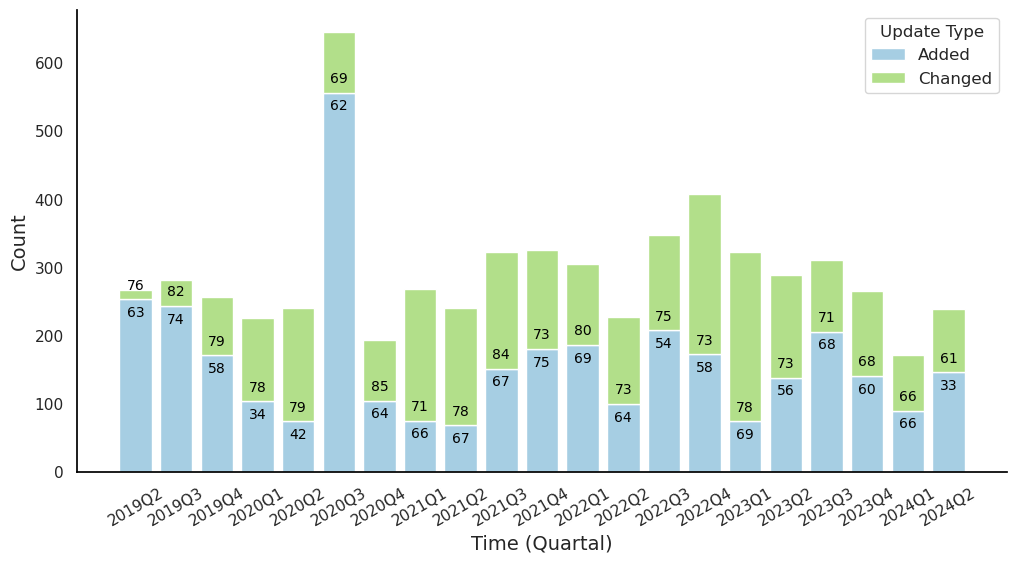

In [343]:
plt.figure(figsize=(12, 6))

#as string
updates_changed_q["file_quartal_str"] = updates_changed_q["file_quartal"].astype(str)

#remove first quartal 
updates_changed_w1 = updates_changed_q.iloc[1:]
# Initialize bottom position to zero
bottom = [0] * len(updates_changed_q)

# Plot the "Count_Added" bars
bars1 = plt.bar(updates_changed_w1["file_quartal_str"], 
                updates_changed_w1["Count_Added"], 
                color="#a6cee3", 
                label="Added")

# Plot the "Count_Changed" bars on top of "Count_Added"
bars2 = plt.bar(updates_changed_w1["file_quartal_str"], 
                updates_changed_w1["Count_Changed"], 
                bottom=updates_changed_w1["Count_Added"], 
                color="#b2df8a", 
                label="Changed")


#add text annotations for Mean_Added and Mean_Changed
for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + bottom[i] - 20, 
             f'{updates_changed_w1["Mean_Added"].iloc[i]:.0f}', 
             ha="center", va="center", color="black", fontsize=10)
    
for i, bar in enumerate(bars1):
    #if this value is lower than 
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + bottom[i] + 20, 
             f'{updates_changed_w1["Mean_Changed"].iloc[i]:.0f}', 
             ha="center", va="center", color="black", fontsize=10)


#add legend
plt.legend(title="Update Type", fontsize=12)
plt.xlabel("Time (Quartal)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=30)

custom_plots()

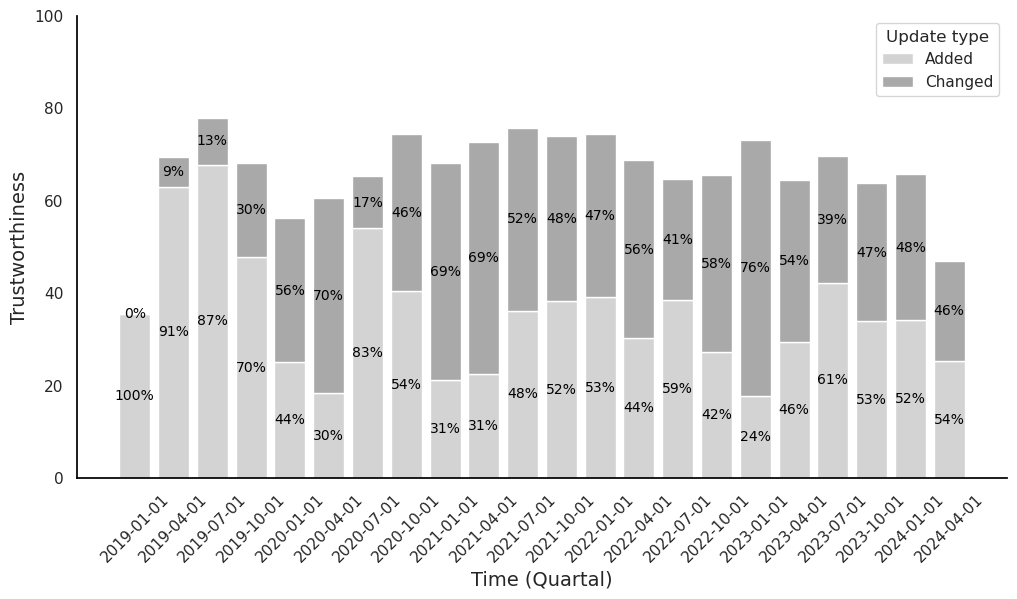

In [344]:
plt.figure(figsize=(12, 6))
colors = ["lightgrey", "darkgrey"]

updates_changed_q["file_quartal_dt"] = updates_changed_q["file_quartal"].dt.to_timestamp()
updates_changed_q['file_quartal_dt_str'] = updates_changed_q['file_quartal_dt'].dt.strftime('%Y-%m-%d')

bottom = np.zeros(len(updates_changed_q))  
for i, (date, mean, pct1, pct2) in enumerate(zip(updates_changed_q["file_quartal_dt_str"], updates_changed_q["Mean_All"], updates_changed_q["Percentage_Added"], updates_changed_q["Percentage_Changed"])):
    plt.bar(date, mean * pct1, bottom=bottom[i], color=colors[0], alpha=1, width=0.8, label="Added" if i == 0 else None)
    plt.text(date, mean * pct1 / 2 + bottom[i], f"{pct1 * 100:.0f}%", ha="center", va="center", color="black", fontsize=10)
    bottom[i] += mean  * pct1
    plt.bar(date, mean * pct2, bottom=bottom[i], color=colors[1], width=0.8, label="Changed" if i == 0 else None)
    plt.text(date, mean * pct2 / 2 + bottom[i], f"{pct2 * 100:.0f}%", ha="center", va="center", color="black", fontsize=10)
    bottom[i] += mean 

plt.xlabel("Time (Quartal)", fontsize=14)
plt.ylabel("Trustworthiness", fontsize=14)
plt.xticks(updates_changed_q["file_quartal_dt_str"], rotation=45)
plt.ylim(0, 100) 
custom_plots()

plt.legend(["Added", "Changed"], title="Update type", loc="upper right")

plt.show()

In [345]:
updates_changed_q["Mean_Added_Percentage"] = updates_changed_q["Mean_All"] * updates_changed_q["Percentage_Added"]

In [347]:
country_count["file_date_month"] = country_count["file_date"].dt.strftime('%Y-%m').astype(str)

In [348]:
updates_changed_q["file_quartal_dt"] = updates_changed_q["file_quartal_dt"] + pd.DateOffset(months=2)
updates_changed_q["file_quartal_dt_month"] = updates_changed_q["file_quartal_dt"].dt.strftime('%Y-%m').astype(str)

In [349]:
updates_changed_q["file_quartal_dt_month"].dtype == country_count["file_date_month"].dtype

True

In [350]:
print("country_count date range:", country_count["file_date_month"].min(), "to", country_count["file_date_month"].max())
print("updates_changed_q date range:", updates_changed_q["file_quartal_dt_month"].min(), "to", updates_changed_q["file_quartal_dt_month"].max())

country_count date range: 2019-03 to 2024-06
updates_changed_q date range: 2019-03 to 2024-06


/tmp/ipykernel_2344688/3746278840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updates_changed["file_date_month"] = \
/tmp/ipykernel_2344688/3746278840.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updates_changed["Mean_Added_Percentage"] = \


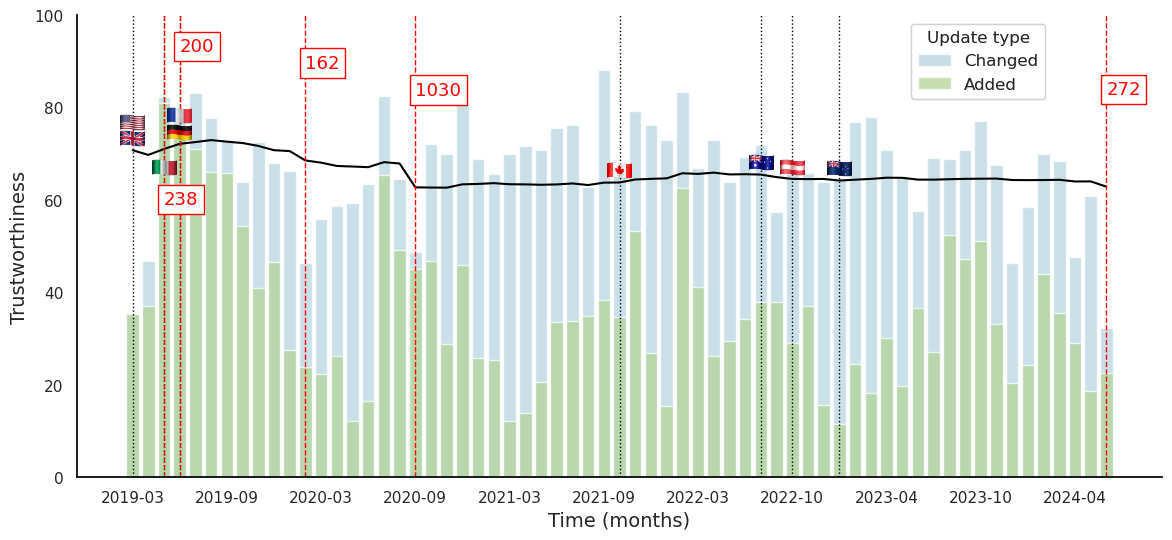

In [439]:
fig, ax = plt.subplots(figsize=(14, 6))

#change into month
updates_changed["file_date_month"] = \
    updates_changed["file_date"].dt\
        .strftime("%Y-%m")\
            .astype(str)

country_change_dict_str = \
    {pd.to_datetime(key)\
     .strftime("%Y-%m"): value for key, value in country_change_dict.items()}

sns.lineplot(data=country_count, 
             x="file_date_month", 
             y="Score", 
             color="black",
             ax=ax)

country_change["file_date_month"] = \
    country_change["file_date"].dt\
        .strftime("%Y-%m")\
            .astype(str)

top_changes["Date_month"] = \
    top_changes["Date"].dt\
        .strftime("%Y-%m")\
            .astype(str)

#highlight country changes and add text with countries
for i, date in enumerate(country_change["file_date_month"]):
    ax.axvline(date, color="black", 
               #alpha=0.3, 
               linestyle=":", linewidth=1)

for i, date in enumerate(top_changes["Date_month"]):
    ax.axvline(date, color="red", 
               #alpha=0.3, 
               linestyle="--", linewidth=1)
    

#add barplots
updates_changed["Mean_Added_Percentage"] = \
    updates_changed["Mean_All"] * updates_changed["Percentage_Added"]

sns.barplot(data=updates_changed, 
                    x="file_date_month", 
                    y="Mean_All", 
                    color="lightblue", 
                    label="Changed", 
                    alpha=0.7,
                    ax=ax)

sns.barplot(data=updates_changed, 
            x="file_date_month", 
            y="Mean_Added_Percentage", 
            color="#b2df8a", 
            alpha=0.7, 
            label="Added",
            ax=ax)

#add text annotations
for i, date in enumerate(top_changes["Date_month"]):
    if i == 2:
        ax.text(date,
                top_changes["Score"].iloc[i] - 12, 
                top_changes["Added"].iloc[i], 
                fontsize=13, 
                bbox=dict(facecolor="white",
                            edgecolor="red"),
                color="red")
    else:
        ax.text(date, 
            top_changes["Score"].iloc[i] + 20, 
            top_changes["Added"].iloc[i], 
            fontsize=13, 
            bbox=dict(facecolor="white",
                        edgecolor="red"),
            color="red")


#add flags of country additions
y_positions = {}
for date, countries in country_change_dict_str.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"

        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue

        flag = plt.imread(flag_path)
        country_x = date
        country_score = country_count.loc[
            country_count["file_date_month"] == date, 
                "Score"].iloc[0]

        if country == "IT":
            y_position = country_score + idx - 4
        else:
            if date in y_positions:
                y_position = country_score + idx + 5
            else:
                y_position = country_score + idx + 2.5
        
        imagebox = OffsetImage(flag, zoom=0.4) 
        ab = AnnotationBbox(imagebox, (country_x, y_position), 
                            frameon=False)
        ax.add_artist(ab)
        
        if date not in y_positions:
            y_positions[date] = [y_position]
        else:
            y_positions[date].append(y_position)

#add legend with flag emojis
legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax.plot([], [], 
                                       linestyle="none", 
                                       label=c)[0])
        
legends_flags = ax.legend(handles=legend_elements,
                    loc="lower center",
                    bbox_to_anchor=(0.5, -0.25),
                    fontsize=12,
                    ncol=9,
                    title_fontsize=14)
ax.add_artist(legends_flags)

#add legend with update type
handles, labels = ax.get_legend_handles_labels()
added_changed_legend = plt.legend(handles[9:12], labels[9:12],
                                  loc="upper right",
                                  bbox_to_anchor=(0.9, 1),
                                  title="Update type",
                                  fontsize=12)

ax.add_artist(added_changed_legend)

#custom plot
ax.set_xticks(ax.get_xticks()[::6])
ax.set_xlabel("Time (months)", fontsize=14)
ax.set_ylabel("Trustworthiness", fontsize=14)
ax.set_ylim(0, 100)
custom_plots(ax=ax)

plt.show()

# MERGE WITH PANEL

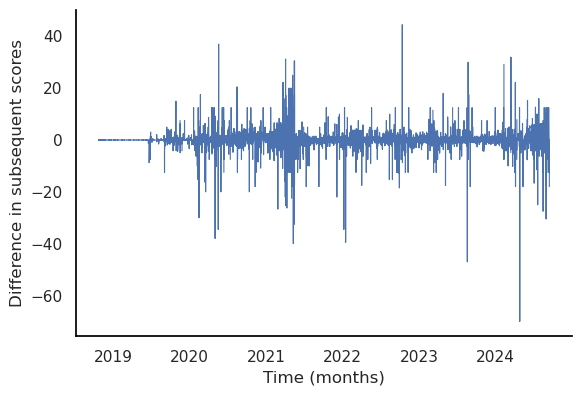

In [86]:
df_15_sorted\
    .groupby(["Last Updated"]).Score_diff\
    .mean()\
    .plot(linewidth=0.8)

plt.figsize=(8, 6)
plt.ylabel("Difference in subsequent scores")
plt.xlabel("Time (months)")
plt.xticks(rotation=0)
custom_plots()

plt.savefig(join(figures_path, "fa2-score_updates.png"), 
            dpi=300)
plt.show()

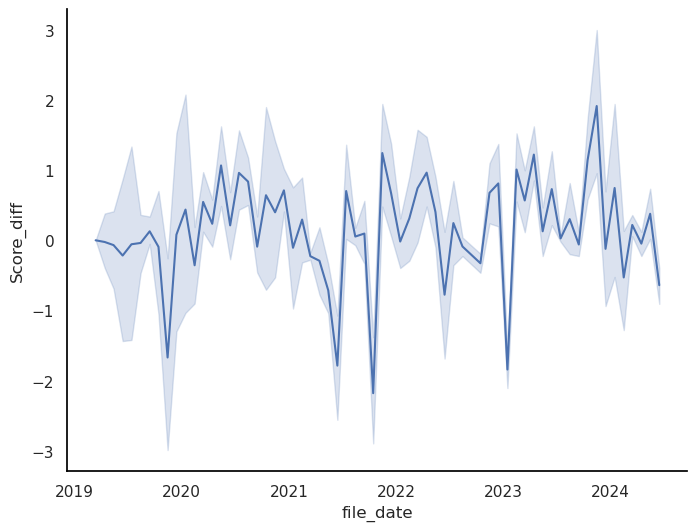

In [87]:
#plot Score_diff
plt.figure(figsize=(8, 6))

sns.lineplot(data=updated_df_15,
                x="file_date",
                y="Score_diff")

custom_plots()

In [88]:
updated_df_15\
        .sort_values(
            "Score_diff", ascending=True)\
                [["Domain", "Score_diff", "Last Updated"]]\
        .head(5)

Domain  Score_diff            Last Updated
77297   conservativedailynews.com       -80.0 2020-11-23 21:39:32.187
282556              newsbreak.com       -70.0 2024-01-24 15:53:41.404
412132          thefederalist.com       -62.5 2019-10-10 17:21:38.137
419855       theragingpatriot.com       -53.0 2021-10-15 12:19:44.207
418512            theohiostar.com       -52.5 2021-01-05 22:53:34.221

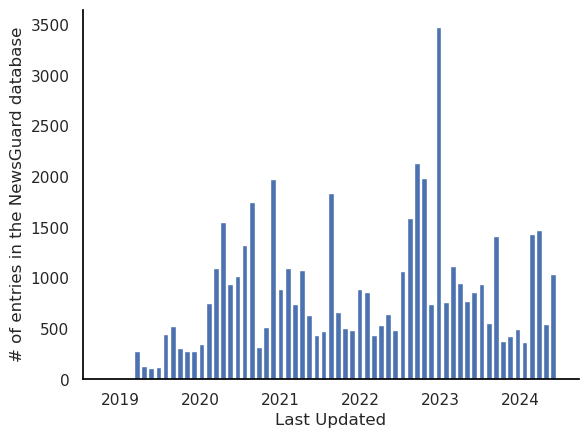

In [89]:
updated_df_15["Last Updated"].hist(bins=updated_df_15["file_date"].nunique(), 
                               #color="blue", 
                               rwidth=0.8,
                               grid=False)

custom_plots()
plt.xlabel("Last Updated")
plt.ylabel("# of entries in the NewsGuard database")
#plt.savefig(join(figures_path, "last_updated_distribution.png"), dpi=300)
plt.show()

In [90]:
#how many times do parent domains get updates?
parent_df_changes = actual_changes[actual_changes["Parent Domain"].notna()]

parent_df_changes["Parent_Update_diff"] = parent_df_changes\
    .groupby(["Parent Domain"])["Last Updated"]\
    .diff()

#calculate the average time between updates per domain
parent_changes = parent_df_changes\
    .groupby(["Parent Domain", "Country", "Language"])["Parent_Update_diff"]\
    .mean()\
    .reset_index()

parent_changes["Parent_Update_diff"].describe()

/tmp/ipykernel_2136231/3583239577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent_df_changes["Parent_Update_diff"] = parent_df_changes\


count                            286
mean      32 days 07:30:32.283562645
std       95 days 20:19:23.697170530
min       -655 days +22:33:21.767000
25%                  0 days 00:00:00
50%        0 days 00:00:00.173937500
75%       25 days 19:03:44.691644230
max      485 days 02:24:50.625666664
Name: Parent_Update_diff, dtype: object

In [91]:
#keep only rows with parent domain
parent_df_changes["Parent_Score_diff"] = \
    actual_changes\
        .groupby("Parent Domain")["Score"]\
        .diff()

parent_df_changes\
        .sort_values(
            "Parent_Score_diff", ascending=True)\
                [["Parent Domain", "Parent_Score_diff", "Last Updated"]]\
        .head(3)

/tmp/ipykernel_2136231/557742182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent_df_changes["Parent_Score_diff"] = \


Parent Domain  Parent_Score_diff            Last Updated
346852  redstateobserver.com              -47.0 2023-05-18 22:04:09.229
346788  redstateobserver.com              -47.0 2023-05-18 22:04:09.100
156359        sarahpalin.com              -45.5 2021-05-17 12:00:50.912

In [92]:
parent_score_diff = parent_df_changes\
                            .groupby("Parent Domain")["Parent_Score_diff"]\
                            .mean()

print(f'The average score difference between updates is: '
      f'{parent_score_diff.mean()}, '
      f'SD = {parent_score_diff.std()}.')
print(f'The range of score differences is: '
      f'max = {parent_score_diff.max()}, '
      f'min={parent_score_diff.min()}.')

The average score difference between updates is: 0.07989570885371407, SD = 2.0181334227379004.
The range of score differences is: max = 8.0, min=-15.666666666666666.


## Composition of trustworthiness score

In [93]:
#rename variable name
criteria_recent_list = [
                    "Does not repeatedly publish false or egregiously misleading content",
                    "Gathers and presents information responsibly",
                    "Has effective practices for correcting errors",
                    "Handles the difference between news and opinion responsibly",
                    "Avoids deceptive headlines",
                    "Website discloses ownership and financing",
                    "Clearly labels advertising",
                    "Reveals who's in charge, including any possible conflicts of interest",
                    "The site provides names of content creators, along with either contact or biographical information"] 

criteria_recent_list_numbers = [
                    "1 - Does not repeatedly publish false or egregiously misleading content",
                    "2 - Gathers and presents information responsibly",
                    "3 - Has effective practices for correcting errors",
                    "4 - Handles the difference between news and opinion responsibly",
                    "5 - Avoids deceptive headlines",
                    "6 - Website discloses ownership and financing",
                    "7 - Clearly labels advertising",
                    "8 - Reveals who's in charge, including any possible conflicts of interest",
                    "9 - The site provides names of content creators, along with either contact or biographical information"] 

In [94]:
#subset criteria and file_date
df_criteria_recent = df_recent[criteria_recent_list]
df_criteria_recent.columns = range(1,10)
df_criteria_recent = df_criteria_recent.astype(str)

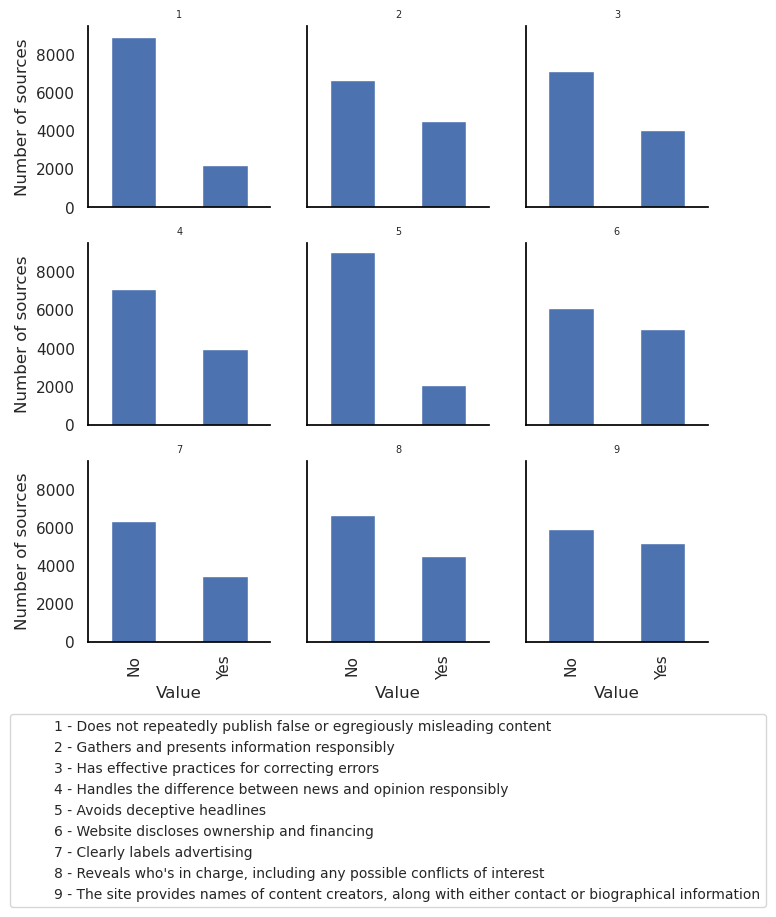

In [95]:
def plot_yesno(df):
    fig, axs = plt.subplots(nrows=3, 
                            ncols=3, 
                            sharex=True,
                            sharey=True,
                            figsize=(8, 8))

    for i, col in enumerate(df.columns):
        row = i // 3 
        col_in_row = i % 3 
        df[col] = df[col].replace("nan", np.nan)
        df[col]\
            .value_counts()\
            .plot(kind="bar",
                  ax=axs[row, col_in_row])
        axs[row, col_in_row].set_xlabel("Value")
        axs[row, col_in_row].set_ylabel("Number of sources")
        axs[row, col_in_row].set_title(f"{col}", fontsize=7)
        custom_plots(ax=axs[row, col_in_row])

    handles = [plt.Line2D([0,1],[0,1], 
                          linestyle="none", 
                          marker = " ", 
                          color="black") for _ in criteria_recent_list_numbers]
    labels = criteria_recent_list_numbers
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.23), 
               fontsize="small")
        
    plt.show()

plot_yesno(df_criteria_recent)

In [96]:
df_recent_critera = pd.melt(df_criteria_recent, 
                      value_vars=df_criteria_recent, 
                      var_name="Criteria", 
                      value_name="Label")
criteria_counts = df_recent_critera\
                    .groupby(["Criteria", "Label"])\
                    .size()\
                    .unstack(fill_value=0)\
                    .reset_index()

criteria_counts["Total"] = criteria_counts["Yes"] + criteria_counts["No"]
criteria_counts["Yes%"] = criteria_counts["Yes"] / criteria_counts["Total"] * 100
criteria_counts["No%"] = criteria_counts["No"] / criteria_counts["Total"] * 100

criteria_counts.sort_values(by="Yes", ascending=False)

Label  Criteria    No   Yes  Total       Yes%        No%
4             5  2088  9033  11121  81.224710  18.775290
0             1  2230  8904  11134  79.971259  20.028741
3             4  3977  7090  11067  64.064335  35.935665
7             8  4487  6644  11131  59.689156  40.310844
1             2  4492  6642  11134  59.655110  40.344890
6             7  3470  6345   9815  64.645950  35.354050
8             9  5902  5196  11098  46.819247  53.180753
5             6  6110  5024  11134  45.123047  54.876953
2             3  7105  4028  11133  36.180724  63.819276

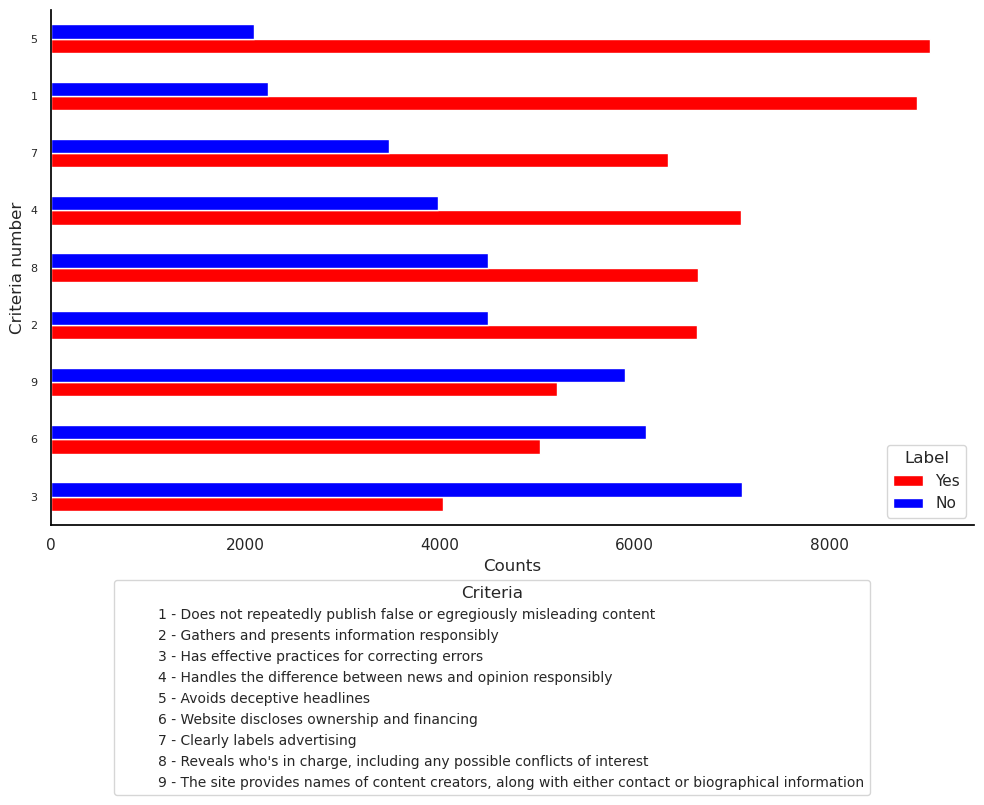

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
    
criteria_counts\
    .sort_values("No", ascending=False)\
    .plot(x="Criteria", 
              y=["Yes", "No"],
              kind="barh", 
              stacked=False,
              color=["red", "blue"], 
              ax=ax)
    
ax.set_xlabel("Counts")
ax.set_ylabel("Criteria number")
ax.tick_params(axis='y', labelsize=8)
ax.legend(title="Label", loc="lower right")

handles = [plt.Line2D([0], [0], color='black', lw=0) for _ in criteria_recent_list_numbers]
labels = criteria_recent_list_numbers
fig.legend(handles, labels, title="Criteria", 
           loc="lower center", bbox_to_anchor=(0.5, -0.35), fontsize="small")

plt.tight_layout()
custom_plots()

plt.show()

In [98]:
df_criteria_recent = \
    df_criteria_recent\
        .replace({"Yes": 1, "No": 0})\
        .fillna(0)

cooccurrence = \
    df_criteria_recent\
        .T\
        .dot(df_criteria_recent)
cooccurrence

1       2       3       4       5       6       7       8       9
1  8904.0  6642.0  4024.0  6617.0  8745.0  4746.0  5643.0  5663.0  4852.0
2  6642.0  6642.0  3831.0  6139.0  6629.0  4465.0  4982.0  5302.0  4524.0
3  4024.0  3831.0  4028.0  3720.0  4012.0  2937.0  3384.0  3182.0  3219.0
4  6617.0  6139.0  3720.0  7090.0  6771.0  4486.0  5226.0  5308.0  4548.0
5  8745.0  6629.0  4012.0  6771.0  9033.0  4778.0  5723.0  5726.0  4916.0
6  4746.0  4465.0  2937.0  4486.0  4778.0  5024.0  3912.0  4153.0  3330.0
7  5643.0  4982.0  3384.0  5226.0  5723.0  3912.0  6345.0  4399.0  3830.0
8  5663.0  5302.0  3182.0  5308.0  5726.0  4153.0  4399.0  6644.0  4259.0
9  4852.0  4524.0  3219.0  4548.0  4916.0  3330.0  3830.0  4259.0  5196.0

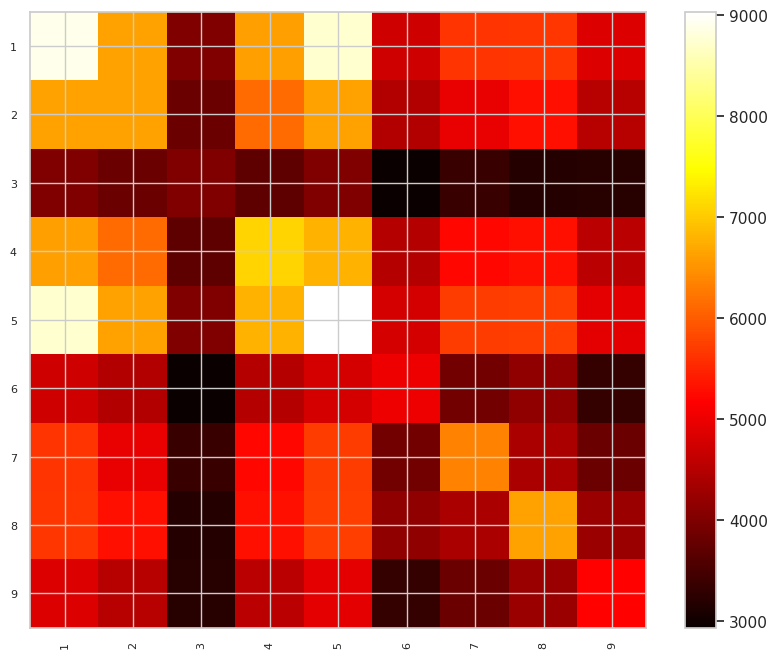

In [99]:
plt.figure(figsize=(10, 8))
plt.imshow(cooccurrence, 
           cmap="hot", 
           interpolation="nearest")

plt.xticks(range(len(cooccurrence)), 
           cooccurrence.columns, 
           rotation=90, 
           fontsize=8)
plt.yticks(range(len(cooccurrence)), 
           cooccurrence.index, 
           fontsize=8)
plt.colorbar()
#for i in range(len(cooccurrence)):
#    for j in range(len(cooccurrence)):
#        plt.text(j, i, cooccurrence.iloc[i, j], 
#        ha="center", va="center", color="grey")
plt.show()

In [100]:
#correlation matrix
corr = df_criteria_recent.corr()
corr.style.background_gradient(cmap="coolwarm")

In [101]:
#save as latex table
corr.to_latex(join(tables_path, "criteria_correlation_recent.tex"))

/tmp/ipykernel_2136231/1938248488.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  corr.to_latex(join(tables_path, "criteria_correlation_recent.tex"))


In [102]:
#exploratory factor analysis of criteria
chi_square_value,p_value=calculate_bartlett_sphericity(df_criteria_recent)
chi_square_value, p_value # there is a significant correlation among the variables

(64543.24329419499, 0.0)

In [103]:
#squared partial correlations
kmo_all,kmo_model=calculate_kmo(df_criteria_recent)
kmo_model #adequate sample size (larger than 0.5)

/home/jluehring/miniconda3/envs/twarcing/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8568023086569925

In [104]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df_criteria_recent, 25)
ev, v = fa.get_eigenvalues()
ev #2 factors have eigenvalues > 1

array([4.85102262, 1.08520758, 0.73377159, 0.66152529, 0.5314239 ,
       0.42162817, 0.40941369, 0.21453588, 0.09147128])

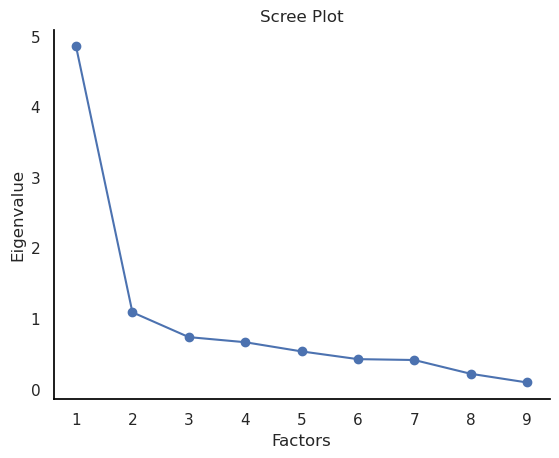

In [105]:
#screeplot
plt.scatter(range(1,df_criteria_recent.shape[1]+1),ev)
plt.plot(range(1,df_criteria_recent.shape[1]+1),ev)
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
custom_plots()
plt.show()

In [106]:
fa = FactorAnalyzer(n_factors=2, 
                    rotation="oblimin")
fa.fit(df_criteria_recent)
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, 
                           index=df_criteria_recent.columns)
loadings_df

0         1
1  0.010508  0.945797
2  0.758080  0.191288
3  0.656276  0.007774
4  0.720243  0.114603
5  0.023381  0.929720
6  0.698124 -0.042885
7  0.577799  0.013926
8  0.728562 -0.175485
9  0.703356 -0.053549

In [107]:
#variance explained
fa.get_factor_variance()[0]

array([3.37153091, 1.84439218])

In [108]:
#in percentage
fa.get_factor_variance()[2]*100

array([37.4614546 , 57.95470107])

### Trustworthiness

In [109]:
#regression: which criteria are most important for the overall score?
for criteria in criteria_recent_list:
    df_recent = df_recent.replace({criteria: {"Yes": 1, "No": 0}})
    df_recent = df_recent.dropna(subset=[criteria])
    df_recent = df_recent.dropna(subset=["Score"])
    X = df_recent[criteria]
    y = df_recent["Score"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(f'Criteria: {criteria}')
    print(f'Coefficient: {model.params[criteria]}')
    print(f'P-value: {model.pvalues[criteria]}')

Criteria: Does not repeatedly publish false or egregiously misleading content
Coefficient: 62.77651451053194
P-value: 0.0
Criteria: Gathers and presents information responsibly
Coefficient: 60.80880185001405
P-value: 0.0
Criteria: Has effective practices for correcting errors
Coefficient: 47.69816705300835
P-value: 0.0
Criteria: Handles the difference between news and opinion responsibly
Coefficient: 54.85138990229054
P-value: 0.0
Criteria: Avoids deceptive headlines
Coefficient: 62.738142191199174
P-value: 0.0
Criteria: Website discloses ownership and financing
Coefficient: 42.81792703429185
P-value: 0.0
Criteria: Clearly labels advertising
Coefficient: 36.650172905140224
P-value: 0.0
Criteria: Reveals who's in charge, including any possible conflicts of interest
Coefficient: 30.936072349344496
P-value: 0.0
Criteria: The site provides names of content creators, along with either contact or biographical information
Coefficient: 40.2810786423029
P-value: 0.0


In [110]:
#multiple combinations of criteria
combinations = df_criteria_recent\
                .groupby(df_criteria_recent.columns\
                         .tolist())\
                .size()\
                .reset_index(name="Counts")

combinations["Percentage"] = \
    combinations["Counts"]/(df_recent["Score"].count())*100

combinations\
    .sort_values("Counts", ascending=False)\
    .head(10)

1    2    3    4    5    6    7    8    9  Counts  Percentage
209  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0    1525   15.628203
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1419   14.541914
69   1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0    1308   13.404386
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     549    5.626153
176  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     489    5.011273
201  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0     475    4.867801
175  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0     443    4.539865
164  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0     389    3.986473
208  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     350    3.586801
207  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0     340    3.484321

### Criteria changes over time

In [111]:
criteria_all_list = [
       "Does not repeatedly publish false content",
       "Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Has effective practices for correcting errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information"]

In [112]:
counts_data = []

for column in criteria_all_list:
    column_counts = df_15\
                        .groupby("file_date")[column]\
                        .count()\
                        .reset_index()
    column_counts = column_counts\
                        .rename(columns={column: "count"})
    column_counts["criteria"] = column
    counts_data.append(column_counts)

counts_table = pd.concat(counts_data, ignore_index=True)

counts_table = counts_table[["file_date", "criteria", "count"]]

first_ratings = counts_table[counts_table["count"] > 0]

first_ratings = first_ratings\
    .groupby("criteria")\
        .agg(
            min_date=("file_date", "min"),
            max_date=("file_date", "max"))\
    .reset_index()

first_ratings

criteria            min_date  \
0                          Avoids deceptive headlines 2019-03-15 01:00:00   
1                          Clearly labels advertising 2019-03-15 01:00:00   
2           Does not repeatedly publish false content 2019-03-15 01:00:00   
3   Does not repeatedly publish false or egregious... 2023-12-15 01:00:00   
4        Gathers and presents information responsibly 2019-03-15 01:00:00   
5   Handles the difference between news and opinio... 2019-03-15 01:00:00   
6       Has effective practices for correcting errors 2023-12-15 01:00:00   
7              Regularly corrects or clarifies errors 2019-03-15 01:00:00   
8   Reveals who's in charge, including any possibl... 2019-03-15 01:00:00   
9   The site provides names of content creators, a... 2019-03-15 01:00:00   
10          Website discloses ownership and financing 2019-03-15 01:00:00   

              max_date  
0  2024-06-15 01:00:00  
1  2024-06-15 01:00:00  
2  2023-11-15 01:00:00  
3  2024-06-15 01:00:00  
4  2024-06-15 01:00:00  
5  2024-06-15 01:00:00  
6  2024-06-15 01:00:00  
7  2023-11-15 01:00:00  
8  2024-06-15 01:00:00  
9  2024-06-15 01:00:00  
10 2024-06-15 01:00:00

In [113]:
df_criteria_15 = df_15[
       ["Does not repeatedly publish false content",
       "Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Has effective practices for correcting errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information"]
       ]

In [114]:
#criteria changes over time 
df_15 = df_15\
        .replace({"Yes": 1, 
                  "No": 0})

criteria_avg = df_15\
    .groupby("file_date")[criteria_all_list]\
    .sum()

#collapse two columns and calculate mean
criteria_avg["Does not repeatedly publish false or egregiously misleading content"] = \
    criteria_avg[[
        "Does not repeatedly publish false content", 
        "Does not repeatedly publish false or egregiously misleading content"]]\
    .mean(axis=1)

criteria_avg["Has effective practices for correcting errors"] = \
    criteria_avg[[
        "Regularly corrects or clarifies errors", 
        "Has effective practices for correcting errors"]]\
    .mean(axis=1)

criteria_avg = \
    criteria_avg.drop(columns=[
        "Does not repeatedly publish false content",
        "Regularly corrects or clarifies errors"])

criteria_avg.columns = \
    [f"{i + 1} - {col}" for i, col in enumerate(criteria_avg.columns)]

In [115]:
#calculate the total number per year
criteria_sum = criteria_avg\
    .reset_index()\
    .melt(id_vars="file_date", 
          value_vars=criteria_avg.columns, 
          var_name="Criteria", 
          value_name="Count")

criteria_sum = criteria_sum\
    .groupby("file_date")["Count"]\
    .sum()\
    .reset_index(name="Total")

#merge 
criteria_avg = criteria_avg\
    .merge(criteria_sum, 
           on="file_date")

In [116]:
#standardize by number of sources per month 
n_sources_month = df_15\
    .groupby("file_date")\
    .size()\
    .reset_index(name="N")

#merge
criteria_avg = criteria_avg\
    .merge(n_sources_month, 
           on="file_date")

#standardize criteria columns by number of sources 
for column in criteria_avg.columns[1:11]:
    criteria_avg[column] = criteria_avg[column] / criteria_avg["N"] * 100

criteria_avg.head(3)

file_date  \
0 2019-03-15 01:00:00   
1 2019-04-15 01:00:00   
2 2019-05-15 01:00:00   

   1 - Does not repeatedly publish false or egregiously misleading content  \
0                                          39.516434                         
1                                          39.127219                         
2                                          39.990154                         

   2 - Gathers and presents information responsibly  \
0                                         71.212694   
1                                         69.970414   
2                                         71.808336   

   3 - Has effective practices for correcting errors  \
0                                          26.917265   
1                                          26.497781   
2                                          26.206104   

   4 - Handles the difference between news and opinion responsibly  \
0                                          67.434832                 
1                                          66.124260                 
2                                          68.231047                 

   5 - Avoids deceptive headlines  \
0                       73.517189   
1                       72.226331   
2                       74.236954   

   6 - Website discloses ownership and financing  \
0                                      57.725727   
1                                      56.360947   
2                                      57.630456   

   7 - Clearly labels advertising  \
0                       80.204005   
1                       79.326923   
2                       80.275681   

   8 - Reveals who's in charge, including any possible conflicts of interest  \
0                                          66.981488                           
1                                          66.715976                           
2                                          67.804398                           

   9 - The site provides names of content creators, along with either contact or biographical information  \
0                                          64.185871                                                        
1                                          63.054734                                                        
2                                          60.846734                                                        

        Total     N  
0  547.695504  2647  
1  539.404586  2704  
2  547.029865  3047

<Figure size 1000x800 with 0 Axes>

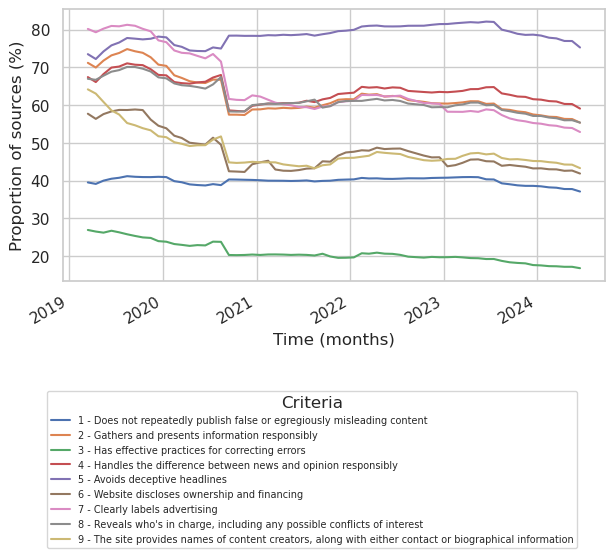

In [117]:
plt.figure(figsize=(10,8))
criteria_avg.iloc[:, :-2].plot(
         kind="line",
         x="file_date"
         #stacked=True
         )

#add line with total
#criteria_avg["Total"]\
#    .plot(
#        color="black", 
#        linestyle="--", 
#        linewidth=2)

plt.xlabel("Time (months)")
plt.ylabel("Proportion of sources (%)")
plt.legend(title="Criteria",
           fontsize=7,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.17),
            bbox_transform=plt.gcf().transFigure,
            ncol=1)
plt.tight_layout()
plt.show()

In [118]:
#turn into year fomat
criteria_avg["file_year"] = criteria_avg["file_date"].dt.year

#aggregate per year
criteria_avg_year = criteria_avg\
    .groupby("file_year")\
    .mean()

criteria_avg_year

/tmp/ipykernel_2136231/2750868677.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  criteria_avg_year = criteria_avg\


1 - Does not repeatedly publish false or egregiously misleading content  \
file_year                                                                            
2019                                               40.494189                         
2020                                               39.646235                         
2021                                               40.004910                         
2022                                               40.572612                         
2023                                               39.943600                         
2024                                               37.908547                         

           2 - Gathers and presents information responsibly  \
file_year                                                     
2019                                              72.646755   
2020                                              64.036724   
2021                                              59.776122   
2022                                              61.862501   
2023                                              59.683151   
2024                                              56.520617   

           3 - Has effective practices for correcting errors  \
file_year                                                      
2019                                               25.745466   
2020                                               22.266910   
2021                                               20.190487   
2022                                               20.214641   
2023                                               18.949857   
2024                                               17.207321   

           4 - Handles the difference between news and opinion responsibly  \
file_year                                                                    
2019                                               69.192883                 
2020                                               64.025721                 
2021                                               61.182020                 
2022                                               64.129406                 
2023                                               63.396739                 
2024                                               60.535674                 

           5 - Avoids deceptive headlines  \
file_year                                   
2019                            76.104560   
2020                            76.367077   
2021                            78.816205   
2022                            80.948647   
2023                            80.742492   
2024                            77.219531   

           6 - Website discloses ownership and financing  \
file_year                                                  
2019                                           57.577744   
2020                                           48.235201   
2021                                           44.308445   
2022                                           47.680464   
2023                                           44.409517   
2024                                           42.730132   

           7 - Clearly labels advertising  \
file_year                                   
2019                            80.100355   
2020                            69.692691   
2021                            60.305352   
2022                            61.769662   
2023                            57.480321   
2024                            54.194503   

           8 - Reveals who's in charge, including any possible conflicts of interest  \
file_year                                                                              
2019                                               68.585957                           
2020                                               63.366285                           
2021                                               60.503352                           
2022                                

<Figure size 1000x800 with 0 Axes>

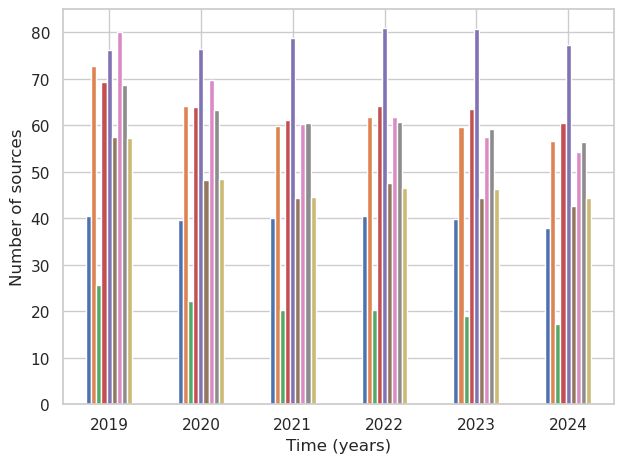

In [119]:
#plot as stacked bar chart
plt.figure(figsize=(10, 8))
#plot except for last column
criteria_avg_year.iloc[:, :-2]\
    .plot(
         kind="bar",
         #marker="o"
         #stacked=True
         )


plt.xlabel("Time (years)")
plt.xticks(rotation=0)
plt.ylabel("Number of sources")
plt.legend().remove()
plt.tight_layout()
plt.show()

### Updates

In [120]:
#subset the first entry and the updates only
df_15_criteria_updates = \
    df_15_sorted[df_15_sorted["Added"] | df_15_sorted["Updated"]]

#recode criteria columns recent to 1 and 0
df_15_criteria_updates = df_15_criteria_updates\
    .replace({"Yes": 1, "No": 0})

In [121]:
#collapse the two columns
df_15_criteria_updates["Does not repeatedly publish false or egregiously misleading content"] = \
    df_15_criteria_updates[["Does not repeatedly publish false content", 
                "Does not repeatedly publish false or egregiously misleading content"]]\
    .max(axis=1)

df_15_criteria_updates["Has effective practices for correcting errors"] = \
    df_15_criteria_updates[["Regularly corrects or clarifies errors", 
                "Has effective practices for correcting errors"]]\
    .max(axis=1)

df_15_criteria_updates = \
    df_15_criteria_updates.drop(columns=[
        "Does not repeatedly publish false content",
        "Regularly corrects or clarifies errors"])

In [122]:
for criterion in criteria_recent_list:
    df_15_criteria_updates[f'Diff_{criterion}'] = \
        df_15_criteria_updates\
            .groupby(["Domain", "Country", "Language"])[criterion]\
            .diff()
    df_15_criteria_updates[f'Diff_{criterion}'] = \
        df_15_criteria_updates[f'Diff_{criterion}']
    
    df_15_criteria_updates.head(10)

In [123]:
df_15_criteria_updates["Updated_Any_Criterion"] = \
    df_15_criteria_updates\
        .apply(lambda row: 
               any(row[f'Diff_{c}'] != 0 and 
                   not pd.isna(row[f'Diff_{c}']) 
                   for c in criteria_recent_list),
                axis=1)

In [124]:
#per domain, count the number of times the criteria have changed
criteria_domain_changes = df_15_criteria_updates\
    .groupby(["Domain", "Country", "Language"])["Updated_Any_Criterion"]\
    .sum()\
    .reset_index()\
    .rename(columns={"Updated_Any_Criterion": "Criteria_changes_count"})

#how many zeros?
criteria_domain_changes["Criteria_changes_count"]\
    .value_counts(
        normalize=True)

0    0.608594
1    0.229553
2    0.104876
3    0.042968
4    0.011818
5    0.001957
6    0.000157
7    0.000078
Name: Criteria_changes_count, dtype: float64

In [125]:
df_15_criteria_diffs = df_15_criteria_updates[
    [col for col in df_15_criteria_updates.columns 
     if col.startswith("Diff_")]]

In [126]:
criteria_change = \
    df_15_criteria_diffs\
        .mean()\
        .reset_index()\
        .rename(columns={"index": "Criteria", 
                         0: "Avg Change"})

total_change = df_15_criteria_diffs\
                    .astype(bool)\
                    .sum()

negative_changes = (df_15_criteria_diffs < 0).sum()
positive_changes = (df_15_criteria_diffs > 0).sum()

negative_changes_percentage = \
    (negative_changes / df_15_criteria_updates.Domain.nunique() * 100)\
    .round(2)


positive_changes_percentage = \
    (positive_changes / df_15_criteria_updates.Domain.nunique() * 100)\
    .round(2)

criteria_changes = pd.DataFrame({
    "Criteria": criteria_change["Criteria"],
    "Total Change": total_change.values,
    "Avg. Change": criteria_change["Avg Change"],
    "Negative Changes": negative_changes_percentage.values,
    "Positive Changes": positive_changes_percentage.values}
    )

criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .str.replace("Diff_", "")

criteria_changes.sort_values(by="Total Change")

Criteria  Total Change  \
0  Does not repeatedly publish false or egregious...         13547   
1       Gathers and presents information responsibly         13700   
4                         Avoids deceptive headlines         13738   
3  Handles the difference between news and opinio...         14289   
7  Reveals who's in charge, including any possibl...         14567   
8  The site provides names of content creators, a...         15038   
2      Has effective practices for correcting errors         15419   
5          Website discloses ownership and financing         15884   
6                         Clearly labels advertising         18800   

   Avg. Change  Negative Changes  Positive Changes  
0     0.001122              0.94              1.45  
1    -0.000787              2.06              1.70  
4     0.002088              1.40              2.35  
3     0.004194              2.44              4.34  
7    -0.000256              5.80              5.69  
8     0.004869              6.41              8.62  
2     0.001811              9.13              9.95  
5    -0.003839             12.49             10.74  
6    -0.013643             10.14              4.42

In [127]:
df_15_criteria_updates\
    [df_15_criteria_updates["Diff_Website discloses ownership and financing"] == -1]\
    ["Domain"].unique()

array(['1011now.com', '12thmanrising.com', '13abc.com', ...,
       'yournewswire.com', 'zeit.de', 'zonazealots.com'], dtype=object)

In [128]:
#bar chart with change percentages
#change the label of one of the criteria
criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .replace({"Does not repeatedly publish false or egregiously misleading content": 
                   "1",
                   "Gathers and presents information responsibly":
                    "2",
                    "Has effective practices for correcting errors":
                    "3",
                   "Handles the difference between news and opinion responsibly":
                   "4",
                   "Avoids deceptive headlines":
                    "5",
                    "Website discloses ownership and financing":
                    "6",
                    "Clearly labels advertising":
                    "7",
                    "Reveals who's in charge, including any possible conflicts of interest":
                    "8",
                   "The site provides names of content creators, along with either contact or biographical information":
                   "9"
                   })

#reshape negative and positive change to long format
criteria_changes = \
    criteria_changes.melt(
        id_vars=["Criteria"],
        value_vars=["Negative Changes", "Positive Changes"],
        var_name="Change",
        value_name="Value")


criteria_changes =\
    criteria_changes.sort_values(
        by="Value", 
        ascending=False)

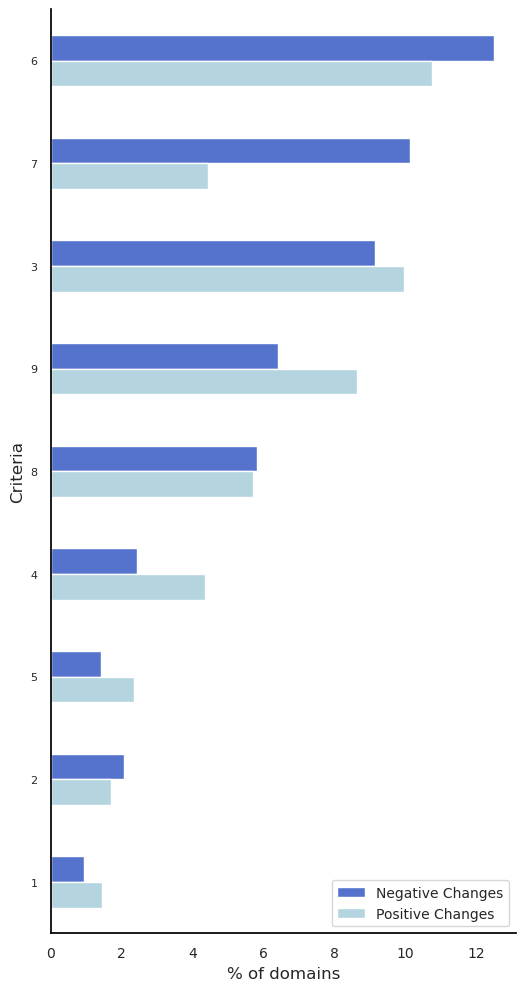

In [129]:
plt.figure(figsize=(6, 12))
sns.barplot(data=criteria_changes, 
            x="Value", 
            y="Criteria", 
            hue="Change",
            palette={"Negative Changes": year_colors[3], 
                     "Positive Changes": year_colors[2]},
            width=0.5)

plt.xlabel("% of domains")
plt.ylabel("Criteria")
plt.yticks(fontsize=8)
plt.xticks(fontsize=10)
plt.legend(prop={"size": 10})
custom_plots()
plt.show()

/tmp/ipykernel_2136231/1903331156.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)


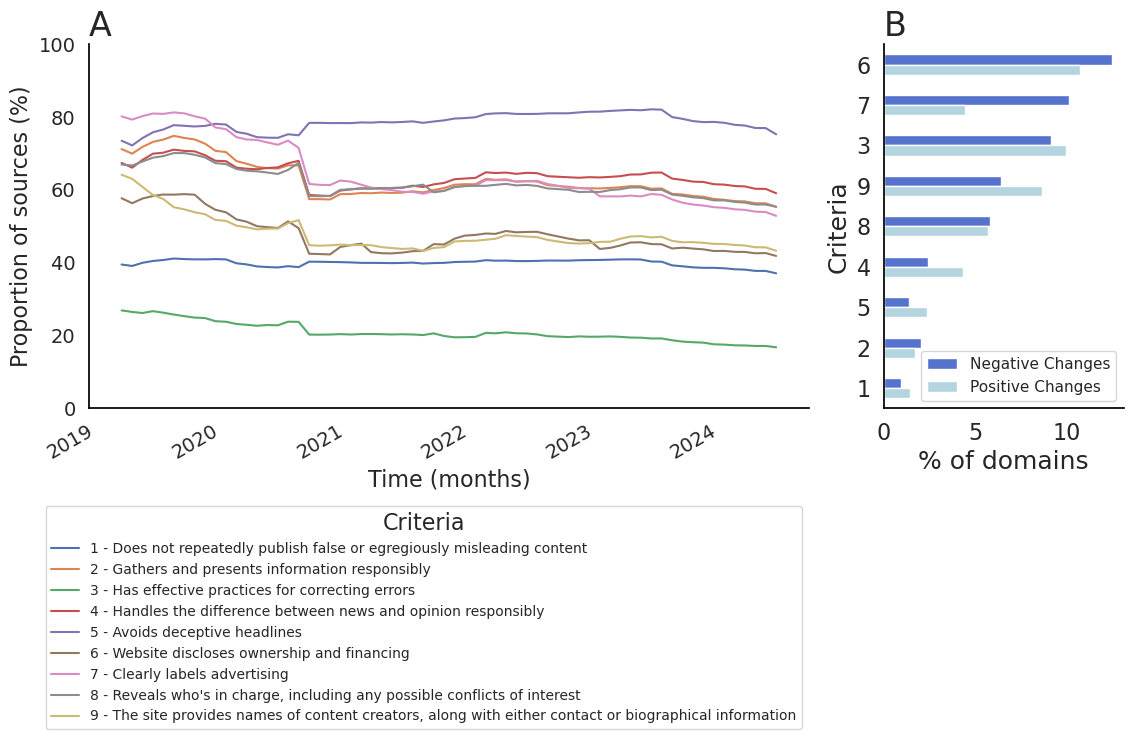

In [226]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8),
                        gridspec_kw={'width_ratios': [3,1]}
                        )

#change order of criteria
criteria_avg.sort_values(by=[])

criteria_avg.iloc[:, :-3].plot(
    kind="line",
    x="file_date",
    ax=axs[0]
)
axs[0].set_xlabel("Time (months)", fontsize=16)
axs[0].set_ylabel("Proportion of sources (%)", fontsize=16)
axs[0].tick_params(axis="both", labelsize=14)
axs[0].set_ylim(0,100)
axs[0].set_title("A", fontsize=24, loc="left")
axs[0].legend(loc=0, 
              bbox_to_anchor=(1, -0.25),
              fontsize=10,
              title_fontsize=16,
              ncol=1,
              title="Criteria"
)
custom_plots(ax=axs[0])

# plot 2 
sns.barplot(data=criteria_changes, 
            x="Value", 
            y="Criteria", 
            hue="Change",
            palette={"Negative Changes": year_colors[3], 
                     "Positive Changes": year_colors[2]},
            width=0.5,
            ax=axs[1])

axs[1].set_xlabel("% of domains", fontsize=18)
axs[1].set_ylabel("Criteria", fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
axs[1].legend(prop={"size": 11})
axs[1].set_title("B", fontsize=24, loc="left")
custom_plots(ax=axs[1])

plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.savefig(join(figures_path, "f2-panel"), dpi=300)
plt.show()

## Countries

In [131]:
lang = df_recent\
    .groupby("Language")\
    .size()\
    .reset_index()

lang\
    .columns = ["Language", "n"]

lang["%"] = \
    (lang["n"] / lang["n"].sum()) * 100

lang

Language     n          %
0       de   347   3.556057
1       en  8586  87.989342
2       fr   361   3.699529
3       it   464   4.755073

In [132]:
countries_lang = df_recent\
    .groupby(["Country", "Language"])\
    .size()\
    .reset_index()

countries_lang\
    .columns = ["Country", "Language", "n"]

countries_lang["\%"] = \
    round((countries_lang["n"] / len(df_recent)) *100, 1)

countries_lang

Country Language     n    \%
0      ALL       en  1168  12.0
1       AT       de    40   0.4
2       AU       en   138   1.4
3       CA       en   393   4.0
4       CA       fr    47   0.5
5       DE       de   307   3.1
6       FR       fr   314   3.2
7       GB       en   469   4.8
8       IT       it   464   4.8
9       NZ       en    19   0.2
10      US       en  6399  65.6

In [133]:
#save table as latex >turn into function for later tables?
countries_lang_latex = countries_lang \
    .sort_values("n", ascending=False) \
    .to_latex(
        index=False, 
        escape=False,
        caption="\\textbf{Country Descriptives.}",
        label="table:table1", 
        position='H',
        column_format=' X c c c c',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
countries_lang_latex = \
    countries_lang_latex\
    .replace("\\end{tabular}", "\\end{tabularx}")

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\bottomrule", "\\bottomrule\n\\textit{Note.} As of December 15th, 2023.")

with open(join(tables_path, 
               "countries_language.tex"), 'w') as f:
    f.write(countries_lang_latex)

/tmp/ipykernel_2136231/4229850507.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  countries_lang_latex = countries_lang \


In [134]:
country_means = \
    df_recent\
        .groupby("Country")\
        .agg({"Score": ["mean", "std", "size"]})\
        .reset_index()\
        .round(1)

country_means\
    .columns = ["Country", "Score_mean", "Score_std", "n"]

country_means["Trustworthiness (SD)"] = \
    country_means\
        .apply(lambda row: f'{row["Score_mean"]} ({row["Score_std"]})', 
               axis=1)

country_means = \
    country_means\
        .drop(["Score_mean", "Score_std"], 
              axis=1)

#percentage
country_means["%"] = \
    (country_means["n"] / len(df_recent) * 100)\
        .round(1)

#order
country_means = \
    country_means\
        .sort_values("n", ascending=False)\
        .reset_index(drop=True)

country_means["n (\%)"] = \
    country_means\
        .apply(lambda row: f'{row["n"]} ({row["%"]})', 
               axis=1)

country_means = \
    country_means\
        .drop("%", 
              axis=1)

#reorder columns
country_means = \
    country_means[["Country", "n (\%)", 
                   "Trustworthiness (SD)"]]

country_means

Country       n (\%) Trustworthiness (SD)
0      US  6399 (65.6)          58.8 (33.9)
1     ALL  1168 (12.0)          75.0 (25.0)
2      GB    469 (4.8)          84.0 (17.1)
3      IT    464 (4.8)          74.1 (21.1)
4      CA    440 (4.5)          88.3 (14.4)
5      FR    314 (3.2)          70.9 (25.7)
6      DE    307 (3.1)          79.8 (29.2)
7      AU    138 (1.4)          74.1 (22.9)
8      AT     40 (0.4)          77.2 (29.6)
9      NZ     19 (0.2)          79.7 (21.2)

In [135]:
df_recent\
    .groupby("Language")["Score"]\
    .mean()\
    .sort_values(ascending=False)

Language
de    79.507205
it    74.074353
fr    71.882271
en    64.087817
Name: Score, dtype: float64

In [136]:
country_score_time = df_15\
    .groupby(["Country","file_date"])\
    .agg({"Score": ["mean", "std"]})\
    .reset_index()
country_score_time.columns = ["Country", "file_date", "Score", "SD"]

In [137]:
country_score_count = df_15\
    .groupby(["file_date", "Country"])\
    .size()\
    .reset_index(name="Count")

country_score_time = country_score_time\
    .merge(country_score_count, 
           on=["Country", "file_date"])

country_score_time

Country           file_date      Score         SD  Count
0       ALL 2019-05-15 01:00:00  80.255319  19.311920     95
1       ALL 2019-06-15 01:00:00  82.393701  20.395364    258
2       ALL 2019-07-15 01:00:00  81.885294  20.598961    344
3       ALL 2019-08-15 01:00:00  81.072917  20.561403    485
4       ALL 2019-09-15 01:00:00  79.387387  22.296076    560
..      ...                 ...        ...        ...    ...
457      US 2024-02-15 01:00:00  58.608671  33.592911   7637
458      US 2024-03-15 01:00:00  58.628518  33.600791   7682
459      US 2024-04-15 01:00:00  58.146648  33.798455   7802
460      US 2024-05-15 01:00:00  58.161771  33.798273   7813
461      US 2024-06-15 01:00:00  56.606808  34.420013   8064

[462 rows x 5 columns]

In [138]:
country_score_time.groupby("Country").Score\
                .mean()\
                .sort_values(ascending=False)

Country
CA     86.704664
GB     79.752039
NZ     79.304823
DE     78.017024
AT     73.226992
IT     72.918530
ALL    72.344192
AU     71.792411
FR     66.336118
US     61.938162
Name: Score, dtype: float64

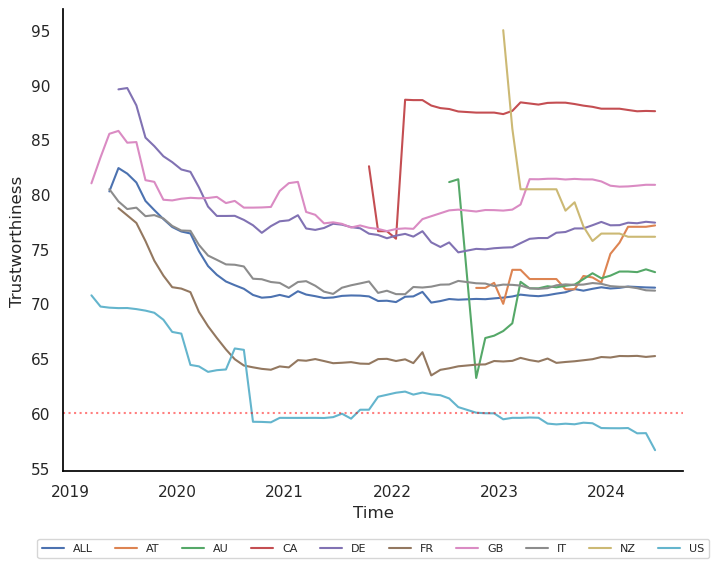

In [139]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=country_score_time, 
             x="file_date", 
             y="Score", 
             hue="Country", 
             estimator="mean")

plt.axhline(y=60, 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Trustworthiness")
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=10, 
           fontsize=8)
custom_plots()
plt.show()

<Axes: xlabel='Score', ylabel='Country'>

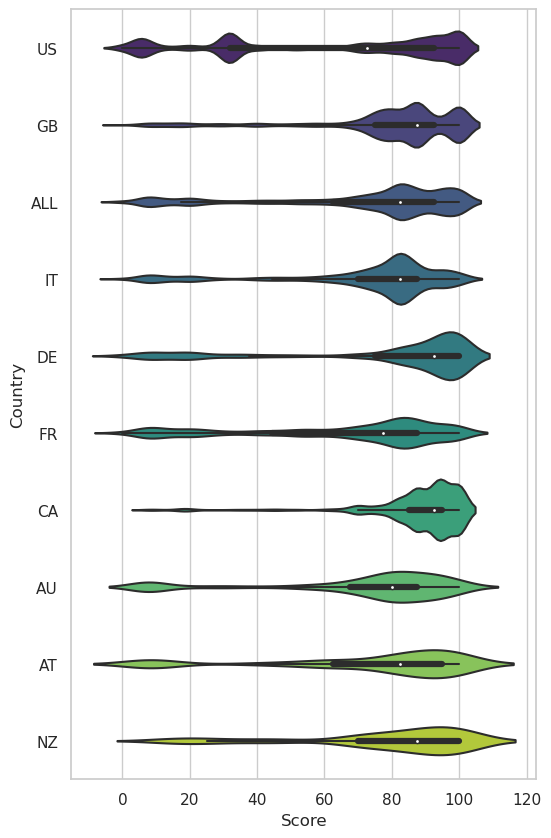

In [155]:
#trustworthiness by country 
plt.figure(figsize=(6, 10))

#errorbars
sns.violinplot(data=df_15, 
            x="Score", 
            y="Country", 
            #show mean
            showmeans=True,
            #not median
            showmedians=False,
            palette="viridis")

# CONTINUE HERE WITH MAKING A GRID!

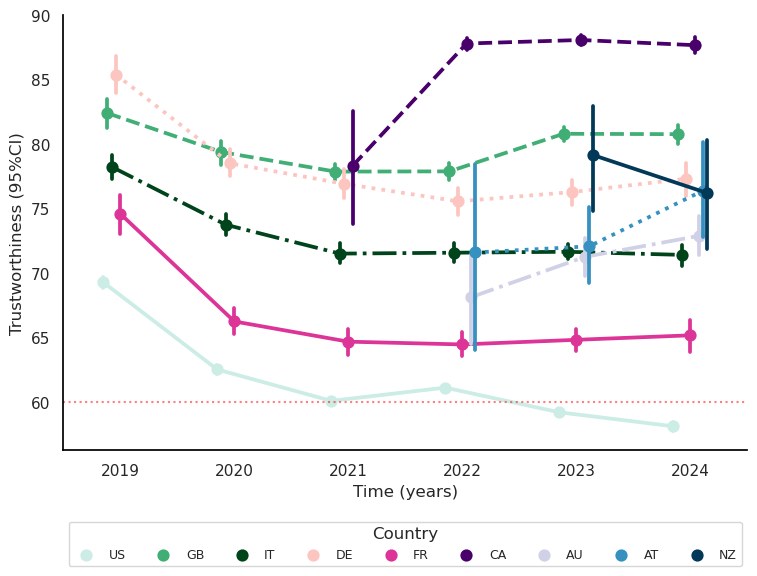

In [173]:
plt.figure(figsize=(8, 6))

country_markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]
country_linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--"]
country_palette = ['#ccece6','#41ae76','#00441b', '#fcc5c0','#dd3497','#49006a', '#d0d1e6','#3690c0','#023858']
#sns.color_palette("tab10", 10)

#remove ALL
df_15_ALL = df_15[df_15["Country"] != "ALL"]

sns.pointplot(data=df_15_ALL,
              x="file_year", 
              y="Score", 
              hue="Country",
              estimator="mean",
              dodge=0.3,
              errorbar="ci",
              palette=country_palette,
              linestyles=country_linestyles
              )

plt.axhline(y=60, 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Time (years)")
plt.ylabel("Trustworthiness (95%CI)")

#handles, labels = pointplot.get_legend_handles_labels()
plt.legend(
    #handles, labels,
    title="Country",
    loc="lower center", 
    bbox_to_anchor=(0.5, -0.28), 
    ncol=10, 
    fontsize=9)
plt.tight_layout()
custom_plots()

plt.savefig(join(
    figures_path, 
    "scores_over_time_per_country.png"), 
    dpi=300)

plt.show()

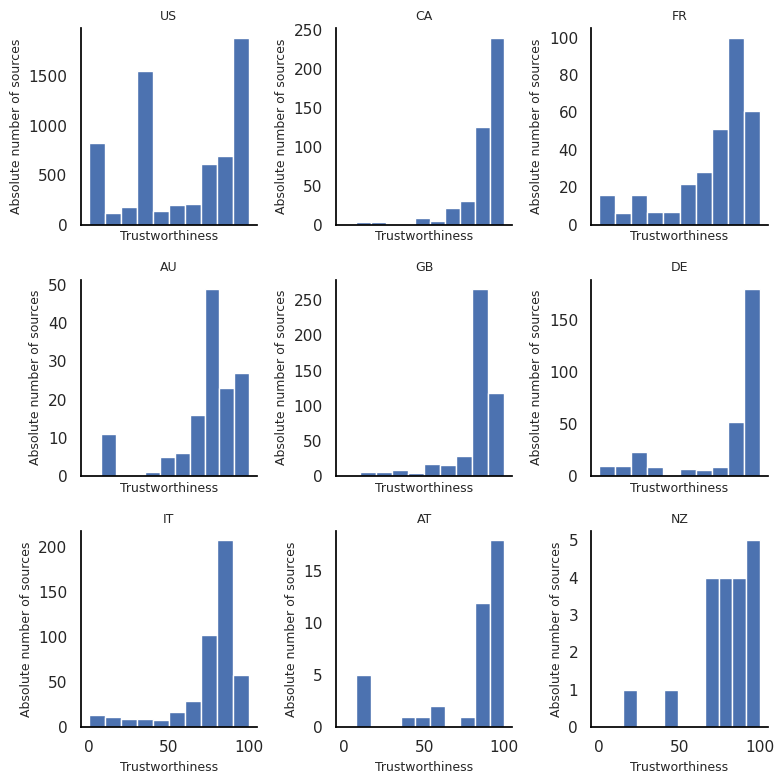

In [181]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
country_df = df_recent[df_recent["Country"] != "ALL"]
 

for i, country in enumerate(country_df["Country"].unique()):
    row = i // 3 
    col_in_row = i % 3  
    df = country_df[country_df["Country"] == country]
    df["Score"].hist(ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Trustworthiness", fontsize=9)
    axs[row, col_in_row].set_ylabel("Absolute number of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    custom_plots(ax=axs[row, col_in_row])

plt.tight_layout()


plt.savefig(join(figures_path,"scores_per_country_recent.png"), dpi=300)
plt.show()

In [175]:
#do the same with the number of domains over time
country_domains = df_15\
    .groupby(["Country","file_date"])\
    .size()\
    .reset_index(name="Count")

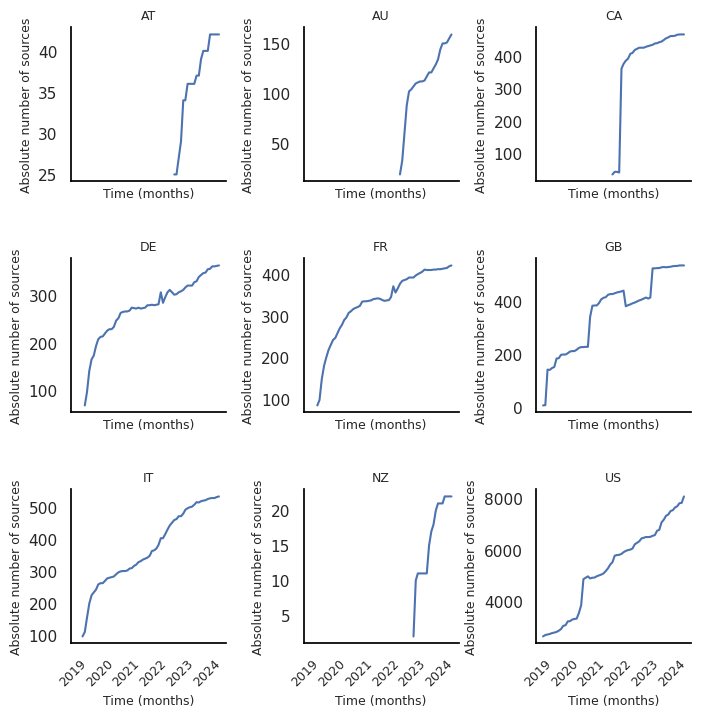

In [182]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

filtered_countries = country_domains[country_domains["Country"] != "ALL"]["Country"].unique()

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_domains[country_domains["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Count"], label=country)
    axs[row, col_in_row].set_xlabel("Time (months)", fontsize=9)
    axs[row, col_in_row].set_ylabel("Absolute number of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=9, rotation=45)
    custom_plots(ax=axs[row, col_in_row])

plt.savefig(join(figures_path,"n_sources_per_country_over_time.png"), dpi=300)
plt.show()

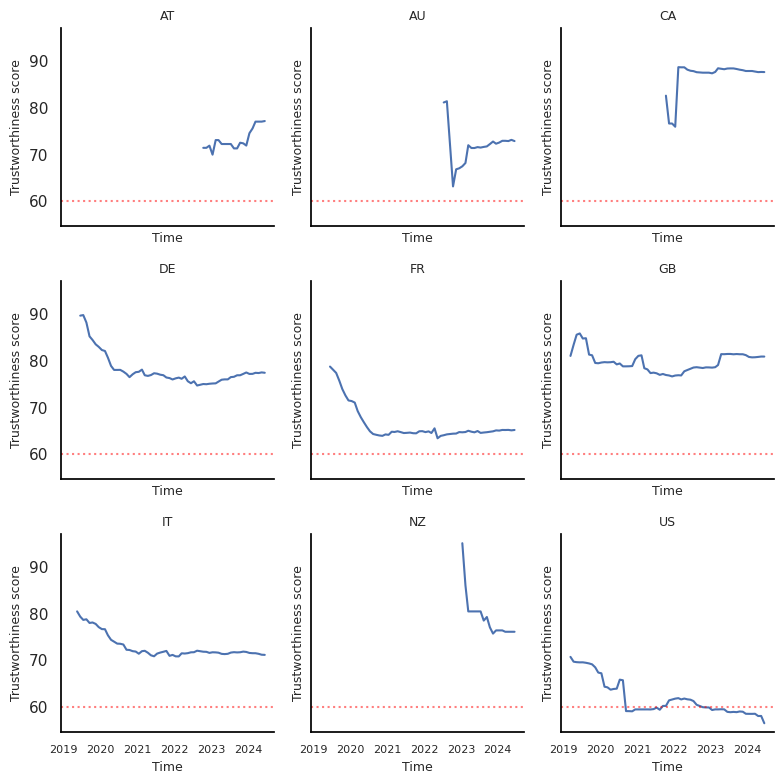

In [183]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_score_time[country_score_time["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Score"], 
                              label=country)
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("Trustworthiness score", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=8)
    axs[row, col_in_row].axhline(y=60, color="red", linestyle="dotted", 
                                 alpha=0.5, label="Trustworthiness threshold")
    custom_plots(ax=axs[row, col_in_row])

plt.tight_layout()
plt.savefig(join(figures_path,"scores_per_country_over_time.png"), dpi=300)
plt.show()

### Updates

In [189]:
updated_df_15.head(3)

Domain        Parent Domain Country Language           file_date  \
17  100fedup.com  100percentfedup.com      US       en 2019-10-15 01:00:00   
20  100fedup.com  100percentfedup.com      US       en 2020-01-15 01:00:00   
22  100fedup.com  100percentfedup.com      US       en 2020-03-15 01:00:00   

              Last Updated  Score Does not repeatedly publish false content  \
17 2019-10-04 23:22:52.632    7.5                                        No   
20 2019-12-27 19:08:32.749    7.5                                        No   
22 2020-02-28 19:59:19.811   44.5                                       Yes   

   Does not repeatedly publish false or egregiously misleading content  \
17                                                NaN                    
20                                                NaN                    
22                                                NaN                    

   Gathers and presents information responsibly  ...  \
17                                           No  ...   
20                                           No  ...   
22                                           No  ...   

   Avoids deceptive headlines Website discloses ownership and financing  \
17                         No                                        No   
20                         No                                        No   
22                        Yes                                        No   

   Clearly labels advertising  \
17                        Yes   
20                        Yes   
22                         No   

   Reveals who's in charge, including any possible conflicts of interest  \
17                                                 No                      
20                                                 No                      
22                                                 No                      

   The site provides names of content creators, along with either contact or biographical information  \
17                                                 No                                                   
20                                                 No                                                   
22                                                 No                                                   

   Score_diff             Updated_diff  Added  Updated Changed  
17        0.0 391 days 00:56:19.427000  False     True   False  
20        0.0  83 days 19:45:40.117000  False     True   False  
22       37.0  63 days 00:50:47.062000  False     True    True  

[3 rows x 23 columns]

In [206]:
#take average per domain
updated_country = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Updated_diff"]\
    .mean()\
    .reset_index()

#average per country
updated_country\
    .groupby("Country")["Updated_diff"]\
    .mean()\
    .reset_index()

Country                Updated_diff
0     ALL 306 days 13:01:44.460224880
1      AT 338 days 11:34:19.300577956
2      AU 331 days 09:09:20.373608492
3      CA 306 days 03:34:19.658711524
4      DE 306 days 02:29:26.744587964
5      FR 318 days 01:08:58.140807460
6      GB 224 days 03:51:11.891243928
7      IT 288 days 10:57:48.053016348
8      NZ 278 days 01:51:41.185071428
9      US 225 days 15:22:50.400634564

In [194]:
changed_df_15.head(5)

Domain        Parent Domain Country Language  \
22          100fedup.com  100percentfedup.com      US       en   
41          100fedup.com  100percentfedup.com      US       en   
63          100fedup.com  100percentfedup.com      US       en   
161  100percentfedup.com  100percentfedup.com      US       en   
180  100percentfedup.com  100percentfedup.com      US       en   

              file_date            Last Updated  Score  \
22  2020-03-15 01:00:00 2020-02-28 19:59:19.811   44.5   
41  2021-10-15 01:00:00 2021-09-22 16:41:11.632   12.5   
63  2023-09-15 01:00:00 2023-09-12 18:48:16.342    0.0   
161 2020-03-15 01:00:00 2020-02-28 19:59:19.632   44.5   
180 2021-10-15 01:00:00 2021-09-22 16:41:11.510   12.5   

    Does not repeatedly publish false content  \
22                                        Yes   
41                                         No   
63                                         No   
161                                       Yes   
180                                        No   

    Does not repeatedly publish false or egregiously misleading content  \
22                                                 NaN                    
41                                                 NaN                    
63                                                 NaN                    
161                                                NaN                    
180                                                NaN                    

    Gathers and presents information responsibly  ...  \
22                                            No  ...   
41                                            No  ...   
63                                            No  ...   
161                                           No  ...   
180                                           No  ...   

    Avoids deceptive headlines Website discloses ownership and financing  \
22                         Yes                                        No   
41                          No                                        No   
63                          No                                        No   
161                        Yes                                        No   
180                         No                                        No   

    Clearly labels advertising  \
22                          No   
41                          No   
63                          No   
161                         No   
180                         No   

    Reveals who's in charge, including any possible conflicts of interest  \
22                                                  No                      
41                                                  No                      
63                                                  No                      
161                                                 No                      
180                                                 No                      

    The site provides names of content creators, along with either contact or biographical information  \
22                                                  No                                                   
41                                                  No                                                   
63                                                  No                                                   
161                                                 No                                                   
180                                                 No                                                   

    Score_diff             Updated_diff  Added  Updated Changed  
22        37.0  63 days 00:50:47.062000  False     True    True  
41       -32.0 327 days 00:57:02.004000  False     True    True  
63       -12.5 372 days 16:59:18.398000  False     True    True  
161       37.0  63 days 00:50:46.976000  False     True    True  
180      -32.0 327 days 00:57:02.083000  False     True    True  

[5 rows x 23 columns]

In [227]:
changed_country = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Actual_Updated_diff"]\
    .mean()\
    .reset_index()

#changed_country per country
changed_country\
    .groupby("Country")["Actual_Updated_diff"]\
    .mean()\
    .reset_index()

Country         Actual_Updated_diff
0     ALL 638 days 23:28:33.153436408
1      AT 375 days 20:52:12.545666668
2      AU 358 days 15:42:25.399641024
3      CA 421 days 13:19:16.486866664
4      DE 661 days 16:39:32.122483960
5      FR 631 days 21:38:44.528322032
6      GB 470 days 13:55:31.641027744
7      IT 645 days 01:54:15.996689968
8      NZ    292 days 07:12:25.152000
9      US 562 days 11:53:48.277862400

In [231]:
#subset AT
actual_changes[actual_changes["Country"] == "AU"].tail(10)

Domain                 Parent Domain Country  \
437113             truthmed.social  australiannationalreview.com      AU   
454644                vogue.com.au                           NaN      AU   
458276  wangarattachronicle.com.au                           NaN      AU   
461064              watoday.com.au                           NaN      AU   
468171      westernadvocate.com.au                           NaN      AU   
468181      westernadvocate.com.au                           NaN      AU   
468710     westernweekender.com.au                           NaN      AU   
479743         womensagenda.com.au                           NaN      AU   
479754         womensagenda.com.au                           NaN      AU   
487462                  xyz.net.au                           NaN      AU   

       Language           file_date            Last Updated  Score  \
437113       en 2022-10-15 01:00:00 2022-09-30 18:56:25.246    7.5   
454644       en 2023-01-15 01:00:00 2022-12-20 12:48:47.661   62.5   
458276       en 2024-05-15 01:00:00 2024-04-18 12:38:47.223   82.5   
461064       en 2022-08-15 01:00:00 2022-08-03 15:21:31.848   80.0   
468171       en 2022-11-15 01:00:00 2022-10-27 11:58:05.766   87.5   
468181       en 2023-09-15 01:00:00 2023-09-12 22:05:58.208   95.0   
468710       en 2022-10-15 01:00:00 2022-09-05 08:36:33.352   87.5   
479743       en 2022-12-15 01:00:00 2022-12-08 14:08:31.557   67.5   
479754       en 2023-11-15 01:00:00 2023-11-06 21:45:16.847   80.0   
487462       en 2023-04-15 01:00:00 2023-03-31 16:43:30.912    7.5   

       Does not repeatedly publish false content  \
437113                                        No   
454644                                       Yes   
458276                                       NaN   
461064                                       Yes   
468171                                       Yes   
468181                                       Yes   
468710                                       Yes   
479743                                       Yes   
479754                                       Yes   
487462                                        No   

       Does not repeatedly publish false or egregiously misleading content  \
437113                                                NaN                    
454644                                                NaN                    
458276                                                Yes                    
461064                                                NaN                    
468171                                                NaN                    
468181                                                NaN                    
468710                                                NaN                    
479743                                                NaN                    
479754                                                NaN                    
487462                                                NaN                    

       Gathers and presents information responsibly  ...  \
437113                                           No  ...   
454644                                          Yes  ...   
458276                                          Yes  ...   
461064                                          Yes  ...   
468171                                          Yes  ...   
468181                                          Yes  ...   
468710                                          Yes  ...   
479743                                          Yes  ...   
479754                                          Yes  ...   
487462                                           No  ...   

       Website discloses ownership and financing Clearly labels advertising  \
437113                                        No                        Yes   
454644                                       Yes                         No   
458276                                       Yes                        Yes   
461064     

In [184]:
country_updates_sorted = df_15_sorted\
                            [["Country", "Domain", "Language", "Last Updated", "Score"]]\
                            .sort_values(
                                by=["Country", "Domain", "Last Updated"])\
                            .reset_index(drop=True)

In [185]:
country_updates_sorted["Time_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Last Updated"]\
                            .diff()

country_updates_sorted["Score_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Score"]\
                            .diff()
country_updates_sorted.head(3)

Country               Domain Language            Last Updated  Score  \
0     ALL  100giornidaleoni.it       en 2022-05-23 10:23:51.210   30.0   
1     ALL  100giornidaleoni.it       en 2022-05-23 10:23:51.210   30.0   
2     ALL  100giornidaleoni.it       en 2022-05-23 10:23:51.210   30.0   

  Time_Diff  Score_Diff  
0       NaT         NaN  
1    0 days         0.0  
2    0 days         0.0

In [186]:
time_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Time_Diff"]\
                                    .mean()\
                                    .reset_index()

time_diff_country = time_diff_per_domain.groupby("Country")["Time_Diff"]\
                        .mean()\
                        .reset_index()


#turn into days
time_diff_country["Updates"] = \
    time_diff_country["Time_Diff"]\
        .dt.days.astype(str) + " days"

time_diff_country.drop(columns=["Time_Diff"],
                       inplace=True)

time_diff_country

Country  Updates
0     ALL  22 days
1      AT  19 days
2      AU  13 days
3      CA  16 days
4      DE  20 days
5      FR  22 days
6      GB  17 days
7      IT  23 days
8      NZ   6 days
9      US  20 days

In [114]:
score_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Score_Diff"]\
                                    .mean()\
                                    .reset_index()

score_diff_per_domain.groupby("Country")["Score_Diff"]\
                        .mean()\
                        .reset_index()

Country  Score_Diff
0     ALL    0.634753
1      AT   -0.380952
2      AU    0.019663
3      CA    0.849685
4      DE    1.212532
5      FR    0.606437
6      GB   -0.341657
7      IT    0.345701
8      NZ   -4.000000
9      US   -0.285082

In [115]:
country_updates = df_15_UUID\
                    .groupby("Country")["Last Updated"]\
                    .describe(#datetime_is_numeric=True
                    )\
                    .sort_values("count", ascending=False)
country_updates

/tmp/ipykernel_2478860/7169581.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df_15_UUID\
/tmp/ipykernel_2478860/7169581.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df_15_UUID\
/tmp/ipykernel_2478860/7169581.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df_15_UUID\
/tmp/ipykernel_2478860/7169581.py:1: FutureWarning: 

count unique                         top  freq  \
Country                                                   
US       37839  32368  2023-09-05 12:35:58.675000  1073   
ALL       5217   4951  2023-03-03 14:35:17.835000    54   
GB        2171   1955  2023-04-13 02:16:22.067000   146   
IT        2148   2021  2023-03-03 14:36:25.074000    54   
FR        1591   1548  2023-11-29 18:01:29.414000     5   
DE        1306   1268  2023-09-27 13:22:00.720000    11   
CA        1104    850  2023-03-07 17:52:14.615000    71   
AU         251    240  2023-02-24 16:13:47.868000     9   
AT          66     57  2022-08-25 05:30:11.578000     5   
NZ          26     26  2023-01-09 16:53:12.474000     1   

                              first                        last  
Country                                                          
US       2018-07-20 14:03:17.020000  2023-12-15 03:35:11.655000  
ALL      2019-05-13 13:59:57.635000  2023-12-14 21:38:37.013000  
GB       2019-01-22 20:08:15.039000  2023-12-15 03:39:54.338000  
IT       2019-05-13 13:01:34.990000  2023-12-14 16:46:30.021000  
FR       2019-05-22 13:00:05.234000  2023-12-14 21:38:41.307000  
DE       2019-05-21 13:00:27.025000  2023-12-13 10:26:08.487000  
CA       2021-09-28 14:46:52.465000  2023-12-11 16:58:11.809000  
AU       2022-07-01 14:57:02.861000  2023-12-14 06:33:30.642000  
AT       2022-08-24 06:43:10.210000  2023-12-13 10:33:04.632000  
NZ       2023-01-09 14:50:54.347000  2023-11-15 14:00:43.692000

In [116]:
#turn Last Updated into year
df_15_UUID["update_year"] = df_15_UUID["Last Updated"].dt.year
year_updates = df_15_UUID\
                .groupby(["Country", "update_year"])\
                .size()\
                .reset_index(name="Update Count")

year_updates.groupby("Country")["Update Count"]\
            .describe()

count    mean          std     min      25%     50%      75%      max
Country                                                                       
ALL        5.0  1043.4   323.691674   599.0   891.00  1012.0  1351.00   1364.0
AT         2.0    33.0     1.414214    32.0    32.50    33.0    33.50     34.0
AU         2.0   125.5    13.435029   116.0   120.75   125.5   130.25    135.0
CA         3.0   368.0   302.044699    22.0   262.50   503.0   541.00    579.0
DE         5.0   261.2    46.644399   212.0   235.00   261.0   262.00    336.0
FR         5.0   318.2    85.954639   206.0   282.00   327.0   334.00    442.0
GB         5.0   434.2   177.357548   270.0   284.00   453.0   455.00    709.0
IT         5.0   429.6   183.776495   176.0   359.00   415.0   535.00    663.0
NZ         1.0    26.0          NaN    26.0    26.00    26.0    26.00     26.0
US         6.0  6306.5  3272.607936  1953.0  3793.00  7315.5  8057.75  10331.0

In [117]:
filtered_df = country_updates[~country_updates\
                              .index.isin(["US", "ALL"])]
filtered_df["unique"].mean()

995.625

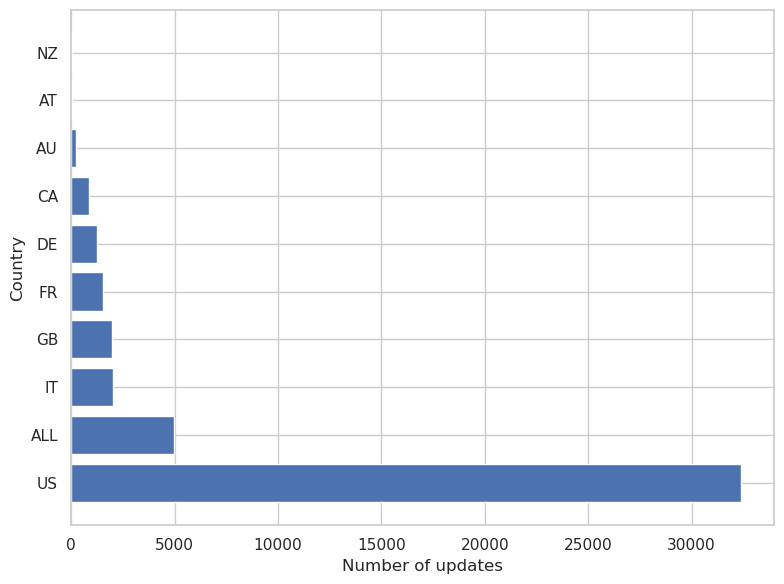

In [118]:
plt.figure(figsize=(8, 6))
country_updates = country_updates\
                    .sort_values("unique", 
                                 ascending=False)

plt.barh(country_updates.index, 
         country_updates["unique"])
plt.xlabel("Number of updates") 
plt.ylabel("Country")
custom_plots()

plt.show()

In [119]:
unique_updates = df_15_UUID\
                    .groupby(["Country", "file_year"])["Last Updated"]\
                    .nunique()\
                    .reset_index()
unique_updates.columns = ["Country", "Year", "Update intervals"]
unique_updates["Year"] = unique_updates["Year"]\
                            .astype(str)

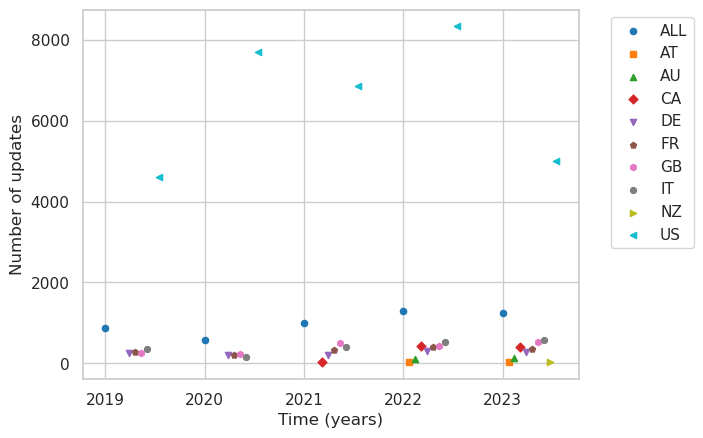

In [120]:
dodge = 0.06
unique_updates["Year"] = pd.to_numeric(
                                unique_updates["Year"], 
                                errors="coerce")

for i, country in enumerate(unique_updates["Country"].unique()):
    country_df = unique_updates[\
                    unique_updates["Country"] == country]
    plt.scatter(
            country_df["Year"] + i * dodge, 
            country_df["Update intervals"], 
            label=country, 
            marker=country_markers[i % len(country_markers)],  
            color=country_palette[i % len(country_palette)],
            s=20)
plt.xlabel("Time (years)")
plt.ylabel("Number of updates")
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc="upper left")
custom_plots()
plt.savefig(join(figures_path, 
                 "updates_per_country_over_time.png"), 
                 dpi=300)
plt.show()

In [121]:
#merge time_diff_per_country with country_means
country_means = country_means\
                    .merge(time_diff_country, 
                           on="Country")

country_means


Country        n (\%) Trustworthiness (SD)   Updates
0      US  6286 (65.77)        59.08 (33.81)  262 days
1     ALL  1136 (11.89)         74.8 (25.29)  357 days
2      GB    470 (4.92)        83.86 (17.31)  245 days
3      IT     459 (4.8)        74.09 (21.43)  310 days
4      CA    435 (4.55)        88.81 (13.79)  303 days
5      FR    308 (3.22)        70.65 (26.15)  391 days
6      DE    292 (3.06)        79.92 (29.11)  399 days
7      AU    116 (1.21)        73.59 (24.83)  299 days
8      AT      38 (0.4)        71.92 (30.01)  269 days
9      NZ     18 (0.19)        80.28 (21.66)  235 days

In [122]:
table2_latex = country_means\
    .sort_values("Country", ascending=False)\
    .to_latex(
        index=False, 
        escape=False,
        caption="Country Descriptives.",
        label="table:table2", 
        position='H',
        column_format=' X c c c c ',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

table2_latex = \
    table2_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")

table2_latex = \
    table2_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

table2_latex = \
    table2_latex \
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of December 15th, 2023. Sorted by size.}"
                 )

with open(join(tables_path, "t2_countries.tex"), 'w') as f:
    f.write(table2_latex)

/tmp/ipykernel_2478860/599855534.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table2_latex = country_means\


In [123]:
#per country i want to see the number of sources that have 1 in a criterion
criteria_country = df_recent\
    .groupby("Country")\
    [criteria_columns_recent.columns]\
    .sum()\
    .reset_index()

sources_counry = \
    df_recent\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

criteria_country = \
    criteria_country\
        .merge(sources_counry, 
               on="Country")

for col in criteria_columns_recent.columns:
    criteria_country[col] = \
        criteria_country["Total"] - criteria_country[col] 
    
for col in criteria_columns_recent.columns:
    criteria_country[col] = \
        round(criteria_country[col] / criteria_country["Total"] * 100, 2)

criteria_country\
    .drop(columns="Total", 
          inplace=True)

criteria_country.columns = \
    [col.replace("\n", " ") for col in 
     criteria_country.columns]

criteria_country

Country  \
0     ALL   
1      AT   
2      AU   
3      CA   
4      DE   
5      FR   
6      GB   
7      IT   
8      NZ   
9      US   

   Does not repeatedly publish false or egregiously misleading content  \
0                                              11.71                     
1                                              13.16                     
2                                              10.34                     
3                                               1.84                     
4                                              15.75                     
5                                              13.64                     
6                                               3.62                     
7                                               8.50                     
8                                              11.11                     
9                                              18.80                     

   Gathers and presents information responsibly  \
0                                         20.51   
1                                         23.68   
2                                         15.52   
3                                          4.60   
4                                         21.23   
5                                         27.60   
6                                         10.00   
7                                         16.56   
8                                         11.11   
9                                         47.50   

   Handles the difference between news and opinion responsibly  \
0                                              18.40             
1                                              23.68             
2                                              19.83             
3                                               3.45             
4                                              17.12             
5                                              20.13             
6                                               8.94             
7                                              19.17             
8                                               5.56             
9                                              42.38             

   Avoids deceptive headlines  Website discloses ownership and financing  \
0                       11.62                                      32.04   
1                       13.16                                      47.37   
2                       11.21                                      43.97   
3                        1.84                                      46.67   
4                       15.41                                      25.68   
5                       13.64                                      39.94   
6                        3.40                                      17.66   
7                        8.28                                      28.76   
8                        0.00                                      38.89   
9                       17.96                                      64.60   

   Clearly labels advertising  \
0                       14.96   
1                       15.79   
2                       40.52   
3                        5.75   
4                        6.85   
5                       23.38   
6                        6.17   
7                       12.42   
8                       16.67   
9                       46.07   

   Reveals who's in charge,  including any possible conflicts of interest  \
0                                              16.90                        
1                                              39.47                        
2                                              46.55                        
3                                              34.94                        
4                                               7.88                        
5                                              18.51                        
6             

In [124]:
table3_latex = criteria_country\
    .to_latex(
        index=False, 
        escape=False,
        caption="Criteria per country.",
        label="table:table3", 
        position='H',
        column_format=' l X X X X X X X X X ',
        longtable=False,
        header=True,
        na_rep='---',
        bold_rows=True)

table3_latex = \
    table3_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
table3_latex = \
    table3_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

table3_latex = \
    table3_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of December 15th, 2023.}"
                 )

with open(join(tables_path, "t3_criteria_country.tex"), 'w') as f:
    f.write(table3_latex)

/tmp/ipykernel_2478860/2490467276.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table3_latex = criteria_country\


## Overlap with other lists

In [125]:
gond = pd.read_csv("../GONDv1_domains.csv")
gond_de = (gond[gond["language"] == "de"]
           .drop_duplicates(
               subset="domain", 
               keep="first")
)
gond_de.head(3)

domain                      type language  in_list_chatgpt  \
1    20min.ch              legacy press       de            False   
7  24rhein.de  digital-born news outlet       de             True   
8   24vest.de              legacy press       de            False   

   in_list_hbi  in_list_scharkow  in_list_stier  in_list_w3news  
1        False             False           True           False  
7        False             False          False           False  
8         True             False          False           False

In [126]:
gond["type"]\
    .value_counts(
        normalize=True)

legacy press                0.489102
digital-born news outlet    0.179599
commercial broadcaster      0.101133
hyperpartisan news          0.081953
public broadcaster          0.080209
tabloid newspaper           0.068003
Name: type, dtype: float64

In [127]:
#overlap between gond and newsguard
df15_de = (df_15[df_15["Language"] == "de"]
           .drop_duplicates(
               subset="Domain", 
               keep="first")
)
overlap_de = pd.merge(gond_de, df15_de, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")
len(overlap_de)

237

In [128]:
overlap_de_type = overlap_de\
    .groupby("type")\
    .size()\
    .reset_index(name="Count")

overlap_de_type

type  Count
0    commercial broadcaster      4
1  digital-born news outlet     19
2        hyperpartisan news     24
3              legacy press    157
4        public broadcaster     18
5         tabloid newspaper     15

In [129]:
df15_unique = \
    df_15\
    .drop_duplicates(
        subset="Domain", 
        keep="first")

gond_unqiue = \
    gond\
    .drop_duplicates(
        subset="domain", 
        keep="first")

overlap = pd.merge(gond, df15_unique, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")

len(overlap)

543

In [130]:
#per type of source, what is the overlap?
overlap_type = overlap\
    .groupby("type")\
    .size()\
    .reset_index(name="Count")

overlap_type 

type  Count
0    commercial broadcaster     58
1  digital-born news outlet     65
2        hyperpartisan news     56
3              legacy press    285
4        public broadcaster     40
5         tabloid newspaper     39

In [131]:
overlap_lang = overlap\
    .groupby("language")\
    .size()\
    .reset_index(name="Count")

overlap_lang

language  Count
0        af      1
1        de    241
2        el      1
3        en    147
4        es      3
5        fr     47
6        it     56
7        ja      1
8        ka      1
9        no      1
10       pl      1
11       pt      1
12       ru      2
13       vi      1

In [132]:
#what are the sources in de that dont overlap?
df15_de_unique = df15_de[~df15_de["Domain"].isin(overlap_de["Domain"])]
df15_de_unique["Domain"]

2696                    dw.com
2736                    web.de
2757                   gmx.net
2815          handelsblatt.com
3180            deutsch.rt.com
                 ...          
357                    5min.at
741               telepolis.de
753      nachrichten-heute.net
5186          de.news-front.su
10762              gesund24.at
Name: Domain, Length: 165, dtype: object

In [133]:
overlap_de[overlap_de["type"] == "hyperpartisan news"]

domain                type language  \
5                             achgut.com  hyperpartisan news       de   
9                      anonymousnews.org  hyperpartisan news       de   
10                      anonymousnews.ru  hyperpartisan news       de   
12                       anti-spiegel.ru  hyperpartisan news       de   
37                       corona-blog.net  hyperpartisan news       de   
44   deutsche-wirtschafts-nachrichten.de  hyperpartisan news       de   
53                         epochtimes.de  hyperpartisan news       de   
56                           exxpress.at  hyperpartisan news       de   
62                         freiewelt.net  hyperpartisan news       de   
87                 journalistenwatch.com  hyperpartisan news       de   
89                      jungefreiheit.de  hyperpartisan news       de   
90                          jungewelt.de  hyperpartisan news       de   
93                        kopp-report.de  hyperpartisan news       de   
122                    nachdenkseiten.de  hyperpartisan news       de   
126                        neopresse.com  hyperpartisan news       de   
148                          pi-news.net  hyperpartisan news       de   
149                      pleiteticker.de  hyperpartisan news       de   
152                     politikstube.com  hyperpartisan news       de   
153                  politikversagen.net  hyperpartisan news       de   
157                      reitschuster.de  hyperpartisan news       de   
159                        report24.news  hyperpartisan news       de   
205                    tichyseinblick.de  hyperpartisan news       de   
210                         uncutnews.ch  hyperpartisan news       de   
214                    volksverpetzer.de  hyperpartisan news       de   

     in_list_chatgpt  in_list_hbi  in_list_scharkow  in_list_stier  \
5              False        False             False           True   
9               True        False             False          False   
10             False        False             False           True   
12              True        False             False          False   
37              True        False             False          False   
44             False        False             False           True   
53             False        False             False           True   
56              True        False             False          False   
62             False        False             False           True   
87              True        False             False          False   
89             False        False             False           True   
90             False         True             False           True   
93             False        False             False           True   
122            False        False             False           True   
126            False        False             False           True   
148            False        False             False           True   
149             True        False             False          False   
152            False        False             False           True   
153            False        False             False           True   
157            False        False             False           True   
159             True        False             False          False   
205            False        False             False           True   
210             True        False             False          False   
214            False        False             False           True   

     in_list_w3news                                  UUID  \
5             False  8d254403-389a-4ee6-96e2-ae96ce0b8fa3   
9             False  29e6284a-fbb5-49b7-8f71-cac2dff799be   
10            False  6522c342-6f9b-460a-b589-cba52978e7a1   
12            False  22e39de9-9b77-4b36-9230-f43841866963   
37            False  feaf8a6d-d78e-47a7-ad41-e1c2ecd5176c   
44            False  cdec7db3-677e-467a-a5f0-971a5911461a   
53             True  5ca37cc0-

## Political Orientation

In [134]:
print(f'Out of {len(df_15)} rows, '
      f'{df_15["Orientation"].isnull().sum()} '
      'have no rating for orientation.')
print(f'Out of {len(df_15_UUID)} unique ratings, '
      f'{df_15_UUID["Orientation"].isnull().sum()} '
      'have no rating for orientation.')
print(f'This is {round(df_15_UUID["Orientation"].isnull().sum()/len(df_15_UUID)*100,2)}% '
      'of the unique ratings.')

Out of 421870 rows, 283907 have no rating for orientation.
Out of 51719 unique ratings, 29913 have no rating for orientation.
This is 57.84% of the unique ratings.


In [135]:
print(f'In the most recent database, '
      f'{df_recent["Orientation"].isnull().sum()} '
      'have no rating for orientation.\n'
      f'Out of {len(df_recent)} rows, '
      f'{df_recent["Orientation"].notnull().sum()} have a rating.\n'
      f'This is {round(df_recent["Orientation"].notnull().sum()/len(df_recent)*100,2)}% '
      'of the unique ratings.')

In the most recent database, 6578 have no rating for orientation.
Out of 9558 rows, 2980 have a rating.
This is 31.18% of the unique ratings.


In [136]:
total_per_country = \
    df_recent\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

orientation_count = \
    df_recent[df_recent["Orientation"].notnull()]\
        .groupby("Country")\
        .size()\
        .reset_index(name="Orientation")

country_counts = \
    total_per_country\
        .merge(orientation_count, 
               on="Country", 
               how="left")

country_counts["Percentage"] = \
    round((country_counts["Orientation"] / country_counts["Total"]) * 100,2)

country_counts

Country  Total  Orientation  Percentage
0     ALL   1136          153       13.47
1      AT     38           10       26.32
2      AU    116           21       18.10
3      CA    435           14        3.22
4      DE    292           47       16.10
5      FR    308           47       15.26
6      GB    470           46        9.79
7      IT    459           53       11.55
8      NZ     18            3       16.67
9      US   6286         2586       41.14

In [137]:
#count orientation per country
orientation_countries = \
    df_recent\
        .groupby("Country")["Orientation"]\
        .value_counts()\
        .unstack(fill_value=1)

#add number of orientation ratings per country
orientation_countries["Total"] = \
    df_recent\
        .groupby("Country")["Orientation"]\
        .count()
        

orientation_countries["% right"] = \
    (orientation_countries["Right"]/orientation_countries["Total"]*100)\
        .round(2)


orientation_countries["Right"] = \
    orientation_countries["Right"].astype(str) + \
    " (" + orientation_countries["% right"].astype(str) + ")"

orientation_countries["% left"] = \
    (orientation_countries["Left"]/orientation_countries["Total"]*100)\
        .round(2)

orientation_countries["Left"] = \
    orientation_countries["Left"].astype(str) + \
    " (" + orientation_countries["% left"].astype(str) + ")"

#drop columns
orientation_countries = \
    orientation_countries\
        .drop(["% right", "% left"], axis=1)\
        .rename(columns={"Left":"Left (%)", "Right":"Right (%)"})

orientation_countries

Orientation     Left (%)     Right (%)  Total
Country                                      
ALL           36 (23.53)   117 (76.47)    153
AT              2 (20.0)      8 (80.0)     10
AU              8 (38.1)     13 (61.9)     21
CA             4 (28.57)    10 (71.43)     14
DE             9 (19.15)    38 (80.85)     47
FR            16 (34.04)    31 (65.96)     47
GB            22 (47.83)    24 (52.17)     46
IT            11 (20.75)    42 (79.25)     53
NZ             1 (33.33)     2 (66.67)      3
US           314 (12.14)  2272 (87.86)   2586

In [138]:
#latex table
table4_latex = \
    orientation_countries\
        .to_latex(index=True, 
                  escape=False,
                  caption="\\textbf{Orientation per country.}",
                  label="table:table4", 
                  position='H',
                  column_format=' X c c c',
                  longtable=False, 
                  header=True, 
                  na_rep='---', 
                  bold_rows=True)

table4_latex = \
    table4_latex\
        .replace("\\begin{tabular}{", 
                 "\\begin{tabularx}{\\textwidth}{")
table4_latex = \
    table4_latex\
        .replace("\\end{tabular}", 
                 "\\end{tabularx}")

table4_latex = \
    table4_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n"
                 "\\multicolumn{5}{l}{\\textit{Note.} As of December 15h, 2023.}")

#replace all % with \%
table4_latex = \
    table4_latex\
        .replace("%", "\%")

with open(join(tables_path, 
               "t4_orientation_countries.tex"), 
               'w') as f:
    f.write(table4_latex)

/tmp/ipykernel_2478860/3297875217.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  orientation_countries\


### Over time

<Axes: xlabel='file_month'>

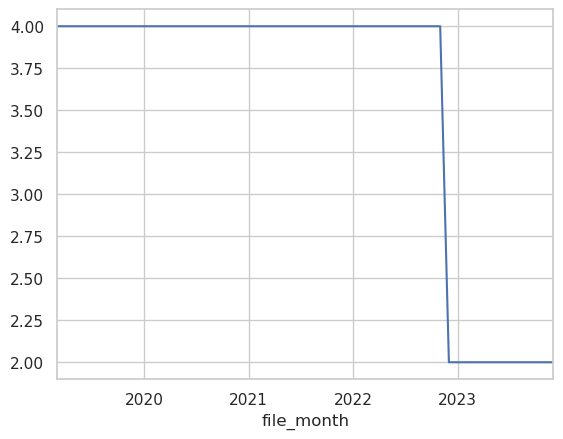

In [139]:
df_15\
    .groupby("file_month")["Orientation"]\
    .nunique()\
    .plot(kind="line")

In [140]:
orientation_palette = {"Far Left": "darkorchid", 
                       "Slightly Left": "palevioletred", 
                       "Far Right": "royalblue", 
                       "Slightly Right": "steelblue",
                       "Left": "firebrick", 
                       "Right": "darkblue"}


orientation_order = ["Far Left", "Slightly Left", 
                     "Slightly Right", "Far Right", 
                     "Left", "Right"]
df_15["Orientation"] = pd.Categorical(df_15["Orientation"], categories=orientation_order, ordered=True)

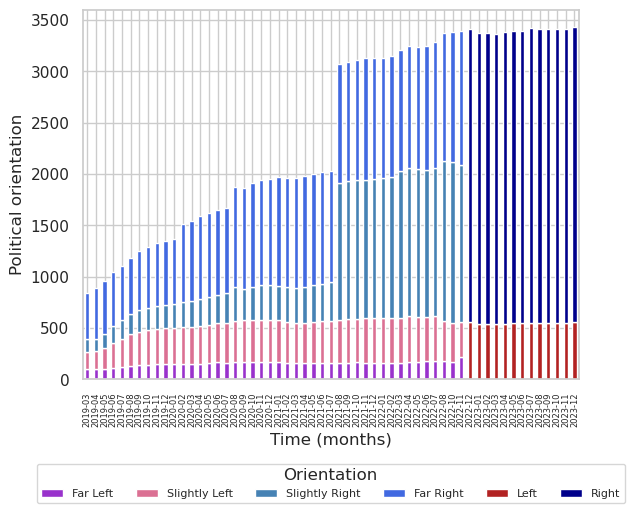

In [141]:
df_15\
    .groupby("file_month")["Orientation"]\
    .value_counts(normalize=False)\
    .unstack()\
    .plot(kind="bar", 
          stacked=True, 
          color=orientation_palette
          )

plt.xlabel("Time (months)")
plt.ylabel("Political orientation")
plt.xticks(fontsize=6)
plt.legend(title="Orientation", 
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.35), 
           ncol=6, fontsize=8
           )

plt.savefig(join(figures_path,"orientation_over_time.png"), 
            dpi=300)

### Per country

In [142]:
orientation_count = \
    df_15\
        .groupby(["Country", "file_month", "file_year"])["Orientation"]\
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_count = orientation_count\
    .melt(id_vars=["Country", "file_month", "file_year"], 
          value_vars=["Far Left", "Far Right", "Left", "Right", "Slightly Left", "Slightly Right"], 
          var_name="Orientation", 
          value_name="Count")

orientation_count = orientation_count[orientation_count["Country"] != "ALL"]

In [143]:
orientation_year = orientation_count\
    .groupby(["Country", "file_year", "file_month", "Orientation"])["Count"]\
    .agg("mean")\
    .reset_index()

unique_years = sorted(orientation_year["file_year"].unique())

orientation_year["Orientation"] = pd.Categorical(orientation_year["Orientation"], 
                                       categories=orientation_order, 
                                       ordered=True)

### Split after rating change

In [146]:
#copy the orientation column
df_15["Orientation_before"] = df_15["Orientation"].astype(str)
df_15["Orientation_after"] = df_15["Orientation"].astype(str)

#recode Left and Right in Orientation to NaN
df_15["Orientation_before"] = \
    df_15["Orientation_before"]\
        .replace({"Left": "NaN", 
                  "Right": "NaN"})

df_15["Orientation_after"] = \
    df_15["Orientation_after"]\
        .replace({"Far Left": "NaN",
                  "Slightly Left": "NaN",
                  "Far Right": "NaN",
                  "Slightly Right": "NaN"})

In [147]:
orientation_counts = \
    df_15\
        .groupby(["Country", "file_month", "file_year"])["Orientation_before", "Orientation_after"]\
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_counts = orientation_counts[orientation_counts["Country"] != "ALL"]

/tmp/ipykernel_2478860/497487864.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_15\


In [148]:
orientation_before = \
    df_15\
        .groupby(["Country", "file_month", "file_year"])["Orientation_before"]\
        .value_counts(normalize=False)\     
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_before = \
 orientation_before\
    .melt(id_vars=["Country", "file_month", "file_year"], 
          value_vars=["Far Left", "Far Right", "Slightly Left", "Slightly Right"], 
          var_name="Orientation_before", 
          value_name="Count_before")

orientation_before = orientation_before[orientation_before["Country"] != "ALL"]

orientation_year_before = orientation_before\
    .groupby(["Country", "file_year", "Orientation_before"])["Count_before"]\
    .agg("mean")\
    .reset_index()

orientation_year_before

Country file_year Orientation_before  Count_before
0        AT      2022           Far Left      0.000000
1        AT      2022          Far Right      2.000000
2        AT      2022      Slightly Left      1.333333
3        AT      2022     Slightly Right      0.666667
4        AT      2023           Far Left      0.000000
..      ...       ...                ...           ...
127      US      2022     Slightly Right   1148.090909
128      US      2023           Far Left      0.000000
129      US      2023          Far Right      0.000000
130      US      2023      Slightly Left      0.000000
131      US      2023     Slightly Right      0.000000

[132 rows x 4 columns]

In [149]:
orientation_after = \
    df_15\
        .groupby(["Country", "file_month", "file_year"])["Orientation_after"]\
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_after = \
 orientation_after\
    .melt(id_vars=["Country", "file_month", "file_year"], 
          value_vars=["Left", "Right"], 
          var_name="Orientation_after", 
          value_name="Count_after")

orientation_after = orientation_after[orientation_after["Country"] != "ALL"]

#calculate average per year
orientation_year_after = orientation_after\
    .groupby(["Country", "file_year", "Orientation_after"])["Count_after"]\
    .agg("mean")\
    .reset_index()

orientation_year_after

Country file_year Orientation_after  Count_after
0       AT      2022              Left     0.666667
1       AT      2022             Right     1.666667
2       AT      2023              Left     2.583333
3       AT      2023             Right     7.333333
4       AU      2022              Left     1.400000
..     ...       ...               ...          ...
61      US      2021             Right     0.000000
62      US      2022              Left    33.272727
63      US      2022             Right   220.909091
64      US      2023              Left   369.416667
65      US      2023             Right  2441.333333

[66 rows x 4 columns]

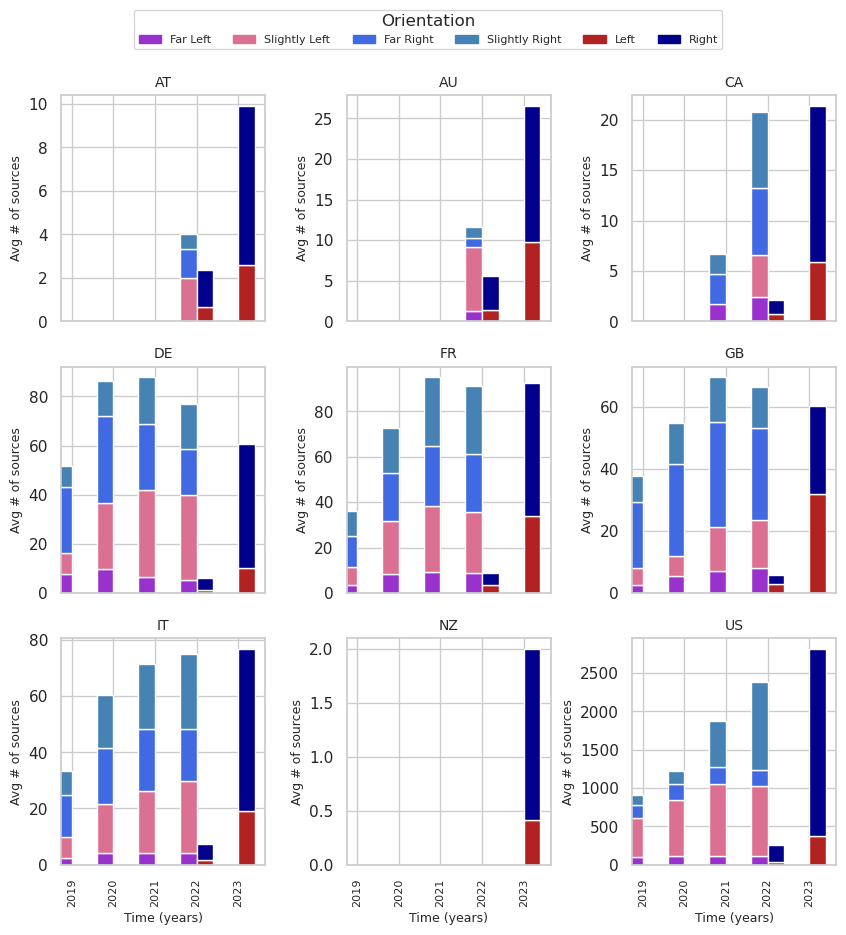

In [150]:
#plot with two variables on the y-axis
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.2, wspace=0.4)

orientation_palette_before = {"Far Left": "darkorchid",
                                "Slightly Left": "palevioletred",
                                "Far Right": "royalblue",
                                "Slightly Right": "steelblue"}

orientation_palette_after = {"Left": "firebrick",
                                "Right": "darkblue"}


unique_years = sorted(orientation_year_after["file_year"].unique())

for i, country in enumerate(orientation_year_before["Country"].unique()):
    row = i // 3
    col_in_row = i % 3

    orientation_year_country_before = orientation_year_before[orientation_year_before["Country"] == country]
    orientation_counts_before = orientation_year_country_before.pivot(index="file_year",
                                                                      columns="Orientation_before",
                                                                      values="Count_before")
    orientation_counts_before = orientation_counts_before.reindex(unique_years, fill_value=0)
    orientation_counts_before.plot(kind="bar",
                                   stacked=True,
                                   ax=axs[row, col_in_row],
                                   width=0.4,
                                   position=1,
                                   legend=False,
                                   color=orientation_palette_before.values())


    orientation_year_country_after = orientation_year_after[orientation_year_after["Country"] == country]
    orientation_counts_after = orientation_year_country_after.pivot(index="file_year",
                                                                    columns="Orientation_after",
                                                                    values="Count_after")
    orientation_counts_after = orientation_counts_after.reindex(unique_years, fill_value=0)
    orientation_counts_after.plot(kind="bar",
                                  stacked=True,
                                  ax=axs[row, col_in_row],
                                  width=0.4,
                                  position=0,
                                  legend=False,
                                  color=orientation_palette_after.values())

    axs[row, col_in_row].set_xlabel("Time (years)", fontsize=9)
    axs[row, col_in_row].set_ylabel("Avg # of sources", fontsize=9)
    axs[row, col_in_row].set_title(f"{country}", fontsize=10)
    axs[row, col_in_row].tick_params(axis="x", labelsize=8)

# add shared legend
handles = [mpatches.Patch(color=color, label=label) 
           for label, color in orientation_palette_before.items()]
handles += [mpatches.Patch(color=color, label=label) 
            for label, color in orientation_palette_after.items()]

axs[2, 2].legend(handles=handles, 
                 title="Orientation", 
                 loc="upper center", 
                 bbox_to_anchor=(-1, 3.8), 
                 ncol=6, 
                 fontsize=8)

plt.savefig(join(figures_path, "orientation_over_time_per_country_before_after.png"),
            dpi=300)
plt.show()

### Collapsed

In [151]:
for df in [df_15, df_15_UUID]:
    df["Orientation_binary"] = df["Orientation"]\
        .replace(
        {"Far Left": "Left", "Slightly Left": "Left", 
         "Slightly Right": "Right", 
         "Far Right": "Right"})

left_right_count = df_15["Orientation_binary"]\
    .value_counts()\
    .reset_index()

left_right_count["%"] = \
    (left_right_count["Orientation_binary"] / left_right_count["Orientation_binary"].sum() * 100)\
        .round(2)

left_right_count

index  Orientation_binary      %
0  Right              107575  77.97
1   Left               30388  22.03

In [174]:
score_x_orientation_time = df_15\
    .groupby(["file_date", "Orientation"])["Score"]\
    .agg(["mean", "std"])

In [165]:
score_x_orientation_time_bi = df_15\
    .groupby(["file_date", "Orientation_binary"])["Score"]\
    .agg(["mean", "std"])\
    .reset_index()

score_x_orientation_time_bi\
    .groupby("Orientation_binary")["mean"]\
    .mean() 

Orientation_binary
Left     71.089262
Right    28.007480
Name: mean, dtype: float64

In [166]:
score_x_orientation_time_bi\
    .groupby("Orientation_binary")["std"]\
    .mean()

Orientation_binary
Left     25.212816
Right    26.564160
Name: std, dtype: float64

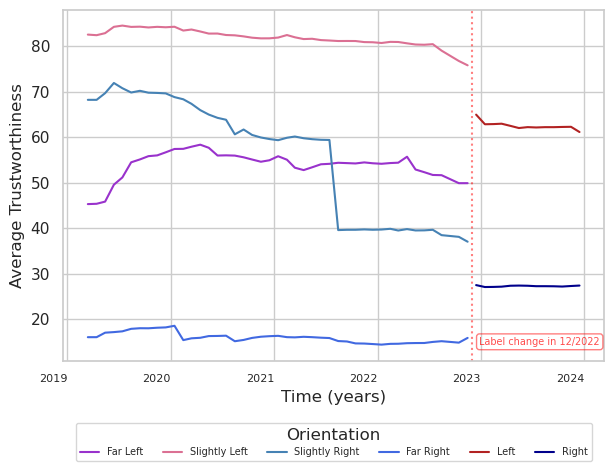

In [189]:
ax = score_x_orientation_time["mean"]\
    .unstack()\
    .plot(kind="line", 
          color=orientation_palette)

plt.xlabel("Time (years)")
plt.ylabel("Average Trustworthiness")
plt.xticks(fontsize=8)
plt.axvline(x="2022-12", 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

xmin, xmax = ax.get_xlim()

#add text to axvline
ax.text(xmax - 440, 15, "Label change in 12/2022", 
        fontsize=7, 
        color="red",
        alpha=0.7,
        verticalalignment="center", 
        bbox=dict(facecolor="none", edgecolor="red",
                  boxstyle="round,pad=0.3",
                  alpha=0.5))

ax.legend(title="Orientation", 
          loc="lower center", 
          bbox_to_anchor=(0.5, -0.3), 
          ncol=6, 
          fontsize=7)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(join(figures_path,
                 "f6-scores_orientation_over_time.png"),
            dpi=300)

### Trustworthiness over time per country


In [190]:
score_x_orientation_time\
    .loc["2021-06":"2021-08"]

mean        std
file_date           Orientation                         
2021-06-15 01:00:00 Far Left        54.022876  27.760272
                    Slightly Left   81.323821  18.353697
                    Slightly Right  59.407563  30.834733
                    Far Right       15.903256  20.758654
                    Left                  NaN        NaN
                    Right                 NaN        NaN
2021-07-15 01:00:00 Far Left        54.123377  27.659420
                    Slightly Left   81.230488  18.446345
                    Slightly Right  59.368493  30.881606
                    Far Right       15.826350  20.701533
                    Left                  NaN        NaN
                    Right                 NaN        NaN
2021-08-15 01:00:00 Far Left        54.353896  27.642733
                    Slightly Left   81.118644  18.406131
                    Slightly Right  39.556597  20.297690
                    Far Right       15.164336  19.691632
                    Left                  NaN        NaN
                    Right                 NaN        NaN

In [191]:
score_x_orientation_time\
    .groupby("Orientation")["mean"]\
    .describe()

count       mean        std        min        25%        50%  \
Orientation                                                                    
Far Left         44.0  53.824213   3.076220  45.268421  52.841395  54.362483   
Slightly Left    44.0  81.876337   1.836099  75.776119  80.925754  81.864086   
Slightly Right   44.0  56.128234  12.813416  37.000328  39.665662  59.883686   
Far Right        44.0  15.937800   1.131637  14.377902  15.044728  15.892768   
Left             13.0  62.484190   0.872396  61.113514  62.181319  62.229358   
Right            13.0  27.240150   0.125276  27.039936  27.146089  27.223841   

                      75%        max  
Orientation                           
Far Left        55.795686  58.331081  
Slightly Left   82.940109  84.511070  
Slightly Right  68.188914  71.892638  
Far Right       16.291120  18.518341  
Left            62.821229  64.938757  
Right           27.323509  27.462526

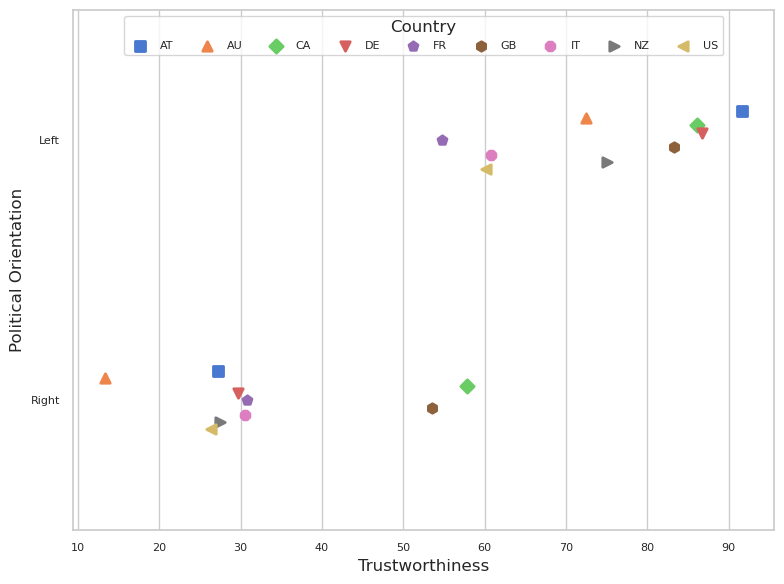

In [192]:
plt.figure(figsize=(8, 6))

country_markers = ["s", "^", "D", "v", "p", "h", "8", ">", "<"]

sns.pointplot(x="Score", y="Orientation", 
               hue="Country", 
               data=df_15[df_15["Country"] != 'ALL'], 
               markers=country_markers,
               order=["Left", "Right"],
               hue_order=sorted(df_15[df_15["Country"] != 'ALL']["Country"].unique()),
               palette="muted", 
               errorbar=None,
               #split=False,
               #width=0.8
               dodge=True,
               join=False)

plt.xlabel("Trustworthiness")
plt.xticks(fontsize=8)
plt.ylabel("Political Orientation")
plt.yticks(fontsize=8)
plt.legend(title="Country", 
           loc="upper center", 
           ncol=9, 
           fontsize=8)
plt.tight_layout()
plt.savefig(join(figures_path, 
                 "scores_orientation_country.png"), 
            dpi=300)
plt.show()

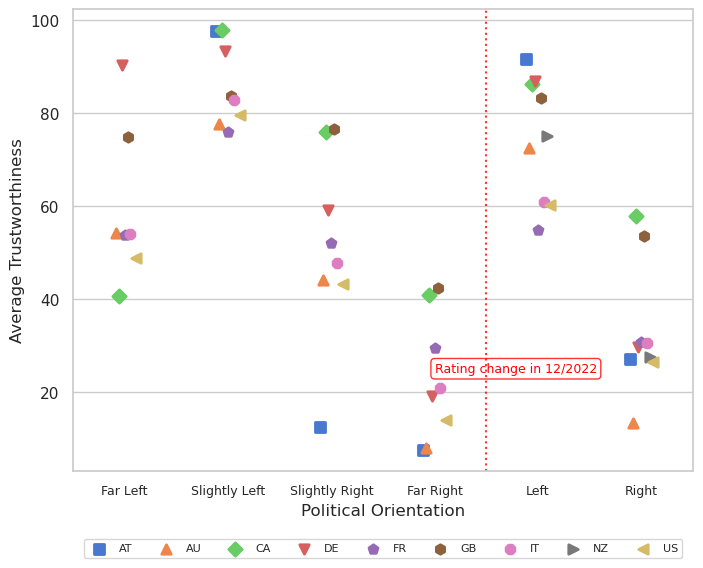

In [193]:
plt.figure(figsize=(8, 6))

country_markers = ["s", "^", "D", "v", "p", "h", "8", ">", "<"]

sns.pointplot(x="Orientation", y="Score", 
               hue="Country", 
               data=df_15[df_15["Country"] != 'ALL'], 
               markers=country_markers,
               order=["Far Left", "Slightly Left", 
                      "Slightly Right", "Far Right", 
                      "Left", "Right"],
               hue_order=sorted(df_15[df_15["Country"] != 'ALL']["Country"].unique()),
               palette="muted", 
               errorbar=None,
               #split=False,
               #width=0.8
               dodge=True,
               join=False)

plt.axvline(x=3.5,
            color="red", 
            linestyle="dotted", 
            alpha=0.8)
plt.xlabel("Political Orientation")
plt.xticks(fontsize=9)
plt.ylabel("Average Trustworthiness")

#add a text box to line
plt.text(3, 25, "Rating change in 12/2022", 
         fontsize=9, 
         color="red",
         verticalalignment="center", 
         bbox=dict(facecolor="none", edgecolor="red",
                   boxstyle="round,pad=0.3",
                   alpha=0.8))

#legend below
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=9, fontsize=8)

plt.savefig(join(figures_path,
                 "scores_orientation_per_country-time.png"),
                 dpi=300)

plt.show()

In [195]:
#country average score per orientation over time
score_x_orientation_time_country = df_15\
    .groupby(["Country", "file_date", "Orientation_binary"])["Score"]\
    .agg(['mean', 'std'])\
    .reset_index()
score_x_orientation_time_country.head()

Country           file_date Orientation_binary       mean        std
0     ALL 2019-03-15 01:00:00               Left        NaN        NaN
1     ALL 2019-03-15 01:00:00              Right        NaN        NaN
2     ALL 2019-04-15 01:00:00               Left        NaN        NaN
3     ALL 2019-04-15 01:00:00              Right        NaN        NaN
4     ALL 2019-05-15 01:00:00               Left  89.285714  10.676521

In [196]:
countries = \
    score_x_orientation_time_country['Country']\
    .unique()
filtered_countries = countries[countries != "ALL"]

In [197]:
score_x_orientation_time_country

Country           file_date Orientation_binary       mean        std
0        ALL 2019-03-15 01:00:00               Left        NaN        NaN
1        ALL 2019-03-15 01:00:00              Right        NaN        NaN
2        ALL 2019-04-15 01:00:00               Left        NaN        NaN
3        ALL 2019-04-15 01:00:00              Right        NaN        NaN
4        ALL 2019-05-15 01:00:00               Left  89.285714  10.676521
...      ...                 ...                ...        ...        ...
1135      US 2023-10-15 01:00:00              Right  26.472052  19.131685
1136      US 2023-11-15 01:00:00               Left  60.146739  22.831427
1137      US 2023-11-15 01:00:00              Right  26.551871  19.219462
1138      US 2023-12-15 01:00:00               Left  58.368074  23.556327
1139      US 2023-12-15 01:00:00              Right  26.556389  19.197164

[1140 rows x 5 columns]

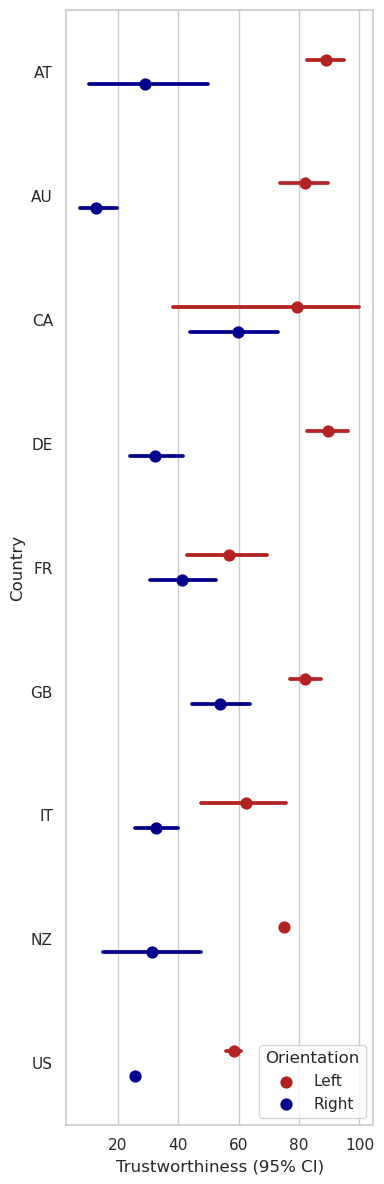

In [216]:
plt.figure(figsize=(4, 12))
country_diff = df_recent[df_recent["Country"] != "ALL"]

sns.pointplot(
    data=country_diff, 
    y="Country", 
    x="Score", 
    hue="Orientation", 
    hue_order=["Left", "Right"],
    order=sorted(country_diff["Country"].unique()),
    errorbar=("ci", 95),
    palette=orientation_palette,
    join=False,
    dodge=0.2)

plt.xlabel("Trustworthiness (95% CI)")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig(join(figures_path,
                    "f7-scores_orientation_per_country_95.png"),
                    dpi=300)
plt.show()

In [317]:
score_x_orientation = df_recent\
    .groupby(["Country", "Orientation"])["Score"]\
    .agg(["mean", "std"])\
    .reset_index()

score_x_orientation_sizes = df_recent\
    .groupby(["Country", "Orientation"])\
    .size()\
    .reset_index(name="size")

score_x_orientation = \
    score_x_orientation.merge(score_x_orientation_sizes, 
    on=["Country", "Orientation"])

score_x_orientation

Country Orientation       mean        std  size
0      ALL        Left  64.791667  28.318186    36
1      ALL       Right  33.576923  27.176991   117
2       AT        Left  88.750000   8.838835     2
3       AT       Right  29.000000  30.386792     8
4       AU        Left  81.875000  12.008182     8
5       AU       Right  12.846154  13.193093    13
6       CA        Left  79.375000  41.250000     4
7       CA       Right  59.900000  26.173354    10
8       DE        Left  89.444444  11.023964     9
9       DE       Right  32.342105  27.994716    38
10      FR        Left  56.875000  28.321076    16
11      FR       Right  41.306452  33.065258    31
12      GB        Left  81.977273  13.627246    22
13      GB       Right  53.812500  24.099347    24
14      IT        Left  62.500000  26.339134    11
15      IT       Right  32.547619  23.301526    42
16      NZ        Left  75.000000        NaN     1
17      NZ       Right  31.250000  22.980970     2
18      US        Left  58.361465  21.582313   314
19      US       Right  25.527509  18.636226  2272

In [335]:
#add to score_x_orientation
score_x_orientation = \
    score_x_orientation.merge(
        country_counts,
        on="Country"
    )

Country Orientation       mean        std  size   prop  Count
0       AT        Left  88.750000   8.838835     2   0.46     38
1       AT       Right  29.000000  30.386792     8   2.74     38
2       AU        Left  81.875000  12.008182     8   2.60    116
3       AU       Right  12.846154  13.193093    13   2.77    116
4       CA        Left  79.375000  41.250000     4   0.87    435
5       CA       Right  59.900000  26.173354    10  55.56    435
6       DE        Left  89.444444  11.023964     9   0.14    292
7       DE       Right  32.342105  27.994716    38    NaN    292
8       FR        Left  56.875000  28.321076    16    NaN    308
9       FR       Right  41.306452  33.065258    31    NaN    308
10      GB        Left  81.977273  13.627246    22    NaN    470
11      GB       Right  53.812500  24.099347    24    NaN    470
12      IT        Left  62.500000  26.339134    11    NaN    459
13      IT       Right  32.547619  23.301526    42    NaN    459
14      NZ        Left  75.000000        NaN     1    NaN     18
15      NZ       Right  31.250000  22.980970     2    NaN     18
16      US        Left  58.361465  21.582313   314    NaN   6286
17      US       Right  25.527509  18.636226  2272    NaN   6286

In [336]:
#standardize size by total number of sources per country
score_x_orientation["prop"] = \
    round(score_x_orientation["size"] / score_x_orientation["Count"] * 100, 2)
score_x_orientation

Country Orientation       mean        std  size   prop  Count
0       AT        Left  88.750000   8.838835     2   5.26     38
1       AT       Right  29.000000  30.386792     8  21.05     38
2       AU        Left  81.875000  12.008182     8   6.90    116
3       AU       Right  12.846154  13.193093    13  11.21    116
4       CA        Left  79.375000  41.250000     4   0.92    435
5       CA       Right  59.900000  26.173354    10   2.30    435
6       DE        Left  89.444444  11.023964     9   3.08    292
7       DE       Right  32.342105  27.994716    38  13.01    292
8       FR        Left  56.875000  28.321076    16   5.19    308
9       FR       Right  41.306452  33.065258    31  10.06    308
10      GB        Left  81.977273  13.627246    22   4.68    470
11      GB       Right  53.812500  24.099347    24   5.11    470
12      IT        Left  62.500000  26.339134    11   2.40    459
13      IT       Right  32.547619  23.301526    42   9.15    459
14      NZ        Left  75.000000        NaN     1   5.56     18
15      NZ       Right  31.250000  22.980970     2  11.11     18
16      US        Left  58.361465  21.582313   314   5.00   6286
17      US       Right  25.527509  18.636226  2272  36.14   6286

In [ ]:
plt.figure(figsize=(4, 12))
dodge_amount = 0.2

# Iterate over each row in the DataFrame
for i, row in enumerate(score_x_orientation.iterrows()):
    country = row[1]["Country"]
    orientation = row[1]["Orientation"]
    mean = row[1]["mean"]
    std = row[1]["std"]
    size = row[1]["size"]
    ci = stats.norm.interval(0.95, loc=mean, scale=stats.sem(mean))
    ci_low, ci_high = ci[0], ci[1]
    y = i // 2
    dodge_offset = y % 2 * dodge_amount - dodge_amount / 2
    x=mean+dodge_offset
    
    plt.errorbar(
        y=y,  
        x=x,  # Apply dodge offset to the x-coordinate
        xerr=std, #plot with 95% ci instead
        fmt="o",
        capsize=5,
        color=orientation_palette[orientation],
        label=orientation if i == 0 else None  # Add label for the first occurrence of each orientation
    )

plt.yticks(range(len(score_x_orientation) // 2), score_x_orientation["Country"].unique())
plt.ylabel("Country")
plt.xlabel("Trustworthiness (SD)")
plt.legend().remove()
plt.tight_layout()
plt.show()

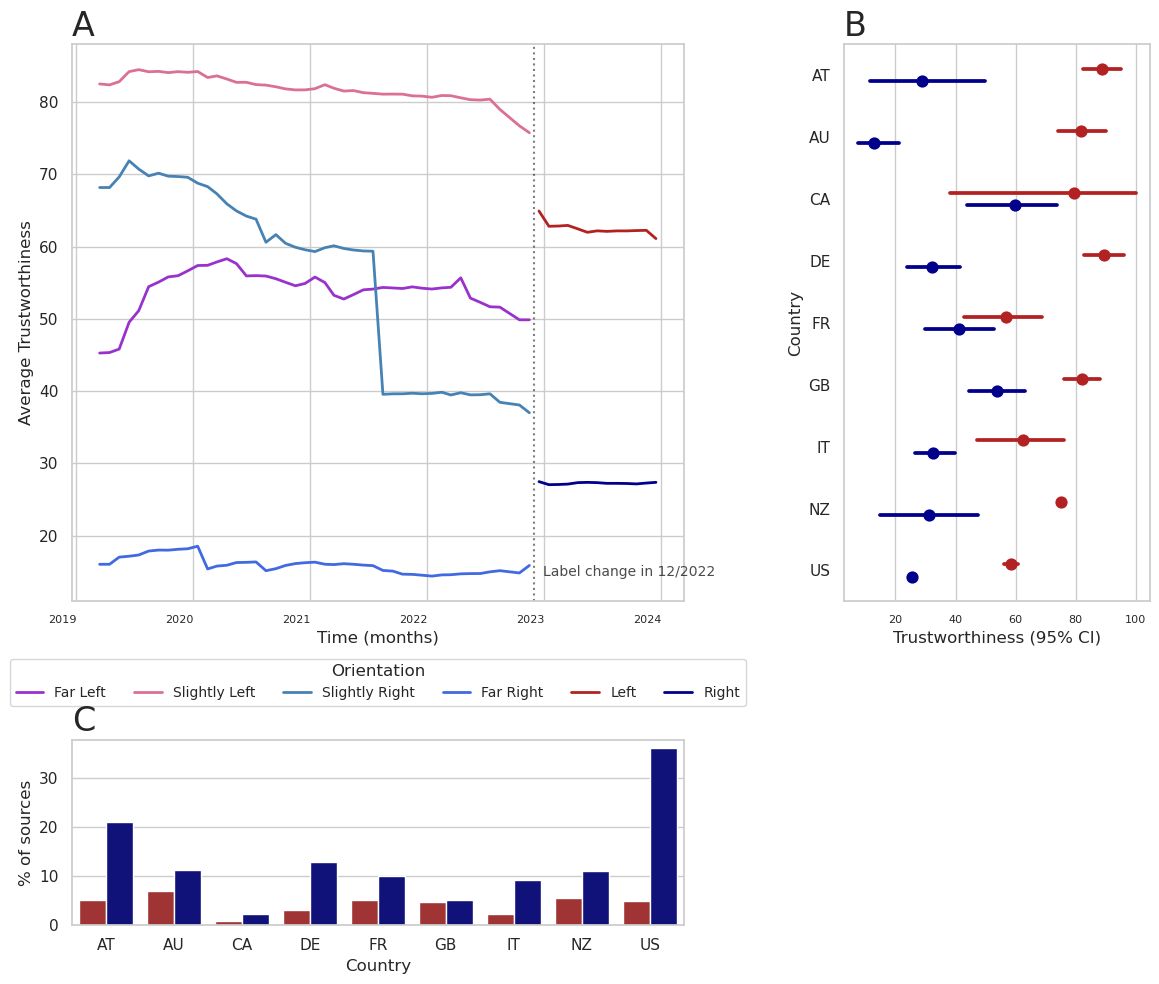

In [357]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10),
                        gridspec_kw={"width_ratios": [2, 1],
                                     "height_ratios": [3, 1]})

ax1 = axs[0,0]
score_x_orientation_time["mean"]\
    .unstack()\
    .plot(kind="line", 
          color=orientation_palette, 
          #make line bigger
          linewidth=2,
          ax=ax1)

ax1.set_xlabel("Time (months)")
ax1.set_ylabel("Average Trustworthiness")
ax1.set_title("A", fontsize=24, loc="left")

ax1.tick_params(axis='x', 
                labelsize=8, 
                rotation=0)

ax1.axvline(x="2022-12", 
            color="black", 
            linestyle="dotted", 
            alpha=0.5)
xmin, xmax = ax1.get_xlim()

ax1.text(xmax - 440, 15, 
         "Label change in 12/2022", 
         fontsize=10, 
         color="black",
         alpha=0.7, 
         verticalalignment="center", 
         bbox=dict(facecolor="none", 
                   edgecolor="none",
                   #boxstyle="round,pad=0.3", 
                   alpha=0.5))

ax1.legend(title="Orientation", 
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=6, 
           fontsize=10)

ax2 = axs[0,1]

orientation_palette_binary = {"Left": "firebrick",
                              "Right": "darkblue"}
sns.pointplot(
    data=country_diff, 
    y="Country", 
    x="Score", 
    hue="Orientation", 
    hue_order=["Left", "Right"],
    order=sorted(country_diff["Country"].unique()),
    errorbar=("ci",95),
    palette=orientation_palette_binary,
    join=False,
    dodge=0.2,
    ax=ax2)

#sns.scatterplot(data=score_x_orientation, 
#                x="mean", 
#                y="Country",
#                hue="Orientation",
#                size="size",
#                palette=orientation_palette_binary,
#                sizes=(50, 200),
#                #dodge=0.1,
#                alpha=1,
#                ax=ax2
#                )



ax2.set_xlabel("Trustworthiness (95% CI)")
ax2.set_ylabel("Country")
ax2.legend().remove()
ax2.tick_params(axis="x", 
                labelsize=8, 
                rotation=0)
ax2.set_title("B", fontsize=24, loc="left")

#add a count plot with dodged bars for each country and the size
ax3=axs[1,0]
sns.barplot(data=score_x_orientation, 
            x="Country", 
            y="prop", 
            hue="Orientation", 
            hue_order=["Left", "Right"],
            order=sorted(score_x_orientation["Country"].unique()),
            palette=orientation_palette_binary,
            dodge=True,
            ax=ax3)

ax3.set_xlabel("Country")
ax3.set_ylabel("% of sources")
ax3.legend().remove()
ax3.set_title("C", fontsize=24, loc="left")

#remove plot 4
ax4 = axs[1,1]
ax4.axis("off")

plt.tight_layout()

plt.savefig(join(figures_path,
                    "f7-orientation_country.png"),
                    dpi=300)
plt.show()

<Axes: xlabel='Country', ylabel='mean'>

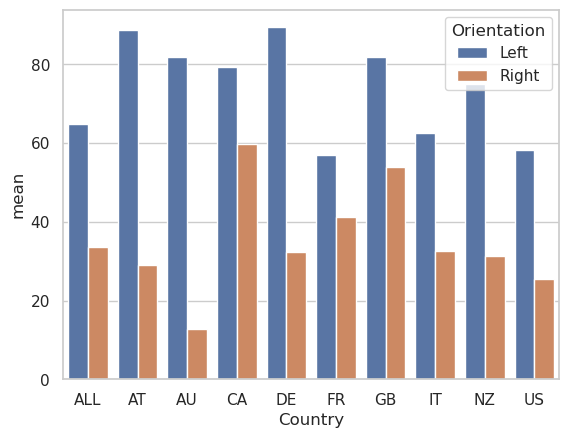

In [303]:
sns.barplot(data=score_x_orientation, x="Country", y="mean", hue="Orientation", dodge=True)

In [ ]:
df_recent\
    .groupby("Orientation")["Score"]\
    .describe()

count       mean        std  min   25%   50%   75%    max
Orientation                                                            
Left          423.0  61.676123  23.357774  7.5  39.5  62.5  80.0  100.0
Right        2557.0  26.654478  20.134820  0.0   7.5  32.0  32.0  100.0

In [ ]:
ttest_recent = \
    stats\
        .ttest_ind(
            df_recent[df_recent["Orientation"] == "Left"]["Score"], 
            df_recent[df_recent["Orientation"] == "Right"]["Score"],
            nan_policy="omit")

ttest_recent

TtestResult(statistic=32.35409531400827, pvalue=4.6620855020667373e-197, df=2978.0)

## Topics

In [ ]:
print(
    f'Out of {len(df_recent)} ratings, '
    f'there are {df_recent["Topics"].isnull().sum()} without topic. ')

print(
    f'This makes up {round(df_recent["Topics"].isnull().sum()/len(df_recent)*100,2)}% ')

Out of 9558 ratings, there are 161 without topic. 
This makes up 1.68% 


<Axes: xlabel='file_date'>

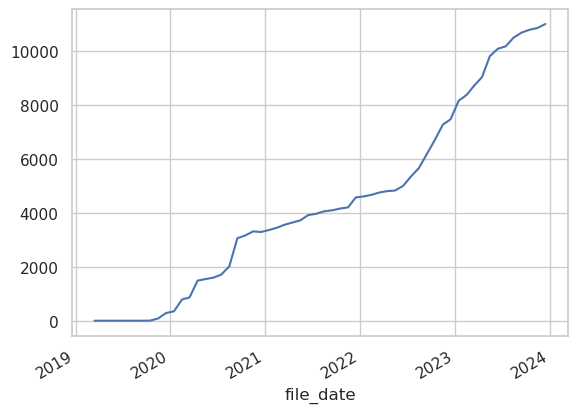

In [ ]:
df_15\
    .groupby("file_date")["Topics"]\
    .count()\
    .plot(kind="line")

In [ ]:
recent_topics_df = \
    df_recent[[
        "Domain", "Country", "Topics",
        "Orientation", "Score", "Rating"]]

recent_topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

recent_topics_df["Topics"] = \
    df_recent["Topics"]\
        .str.split(",")  #split topics into lists

recent_topics_df.head(3)

/tmp/ipykernel_1727229/3048149922.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_topics_df["Topics"] = \


Domain Country                      Topics Orientation  \
0  peterboroughtoday.co.uk      GB  [Local News, General News]         NaN   
1           mycharisma.com      US                  [Religion]         NaN   
2          charismamag.com      US                  [Religion]         NaN   

   Score Rating  
0   82.5      T  
1   49.5      N  
2   49.5      N

In [ ]:
recent_topics_df = \
    recent_topics_df\
        .explode("Topics")\
        .reset_index(drop=True)

recent_topics_df.head(3)

Domain Country        Topics Orientation  Score Rating
0  peterboroughtoday.co.uk      GB    Local News         NaN   82.5      T
1  peterboroughtoday.co.uk      GB  General News         NaN   82.5      T
2           mycharisma.com      US      Religion         NaN   49.5      N

In [ ]:
recent_topic_count = \
    recent_topics_df\
        .groupby("Topics")\
        .size()\
        .reset_index()

recent_topic_count["%"] = \
    (recent_topic_count[0] / len(df_recent) * 100)\
        .round(2)

recent_topic_count\
    .columns = ["Topics", "Count", "%"]

recent_topic_avg = \
    recent_topics_df\
        .groupby("Topics")["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

recent_topic_avg\
    .columns = ["Topics", "Score", "SD"]

recent_topic_desc = \
    pd.merge(recent_topic_count,
             recent_topic_avg,
            on="Topics")

recent_topic_desc

Topics  Count      %  Score     SD
0    Business or Personal Finance    393   4.11  76.44  27.89
1                  Celebrity news    212   2.22  74.28  30.86
2   Conspiracy theories or hoaxes    909   9.51  68.27  31.42
3                Criminal justice     20   0.21  73.25  24.62
4                       Education     20   0.21  73.75  29.71
5                   Entertainment    281   2.94  73.65  30.34
6                     Environment     53   0.55  64.89  29.83
7                         Fashion     78   0.82  74.12  31.26
8                    General News   1900  19.88  68.08  30.29
9   Health or medical information   1006  10.53  67.75  31.48
10                      Lifestyle    211   2.21  70.51  31.81
11                     Local News   3734  39.07  63.03  30.72
12           Military and Defense     46   0.48  58.25  39.64
13                      Parenting     40   0.42  72.66  30.33
14   Political news or commentary   3621  37.88  61.45  30.92
15                       Religion     87   0.91  66.20  33.50
16                        Science     91   0.95  73.97  28.27
17           Sports and athletics    316   3.31  83.09  22.29
18                     Technology    116   1.21  74.56  29.27
19                  Viral content    170   1.78  73.16  29.22

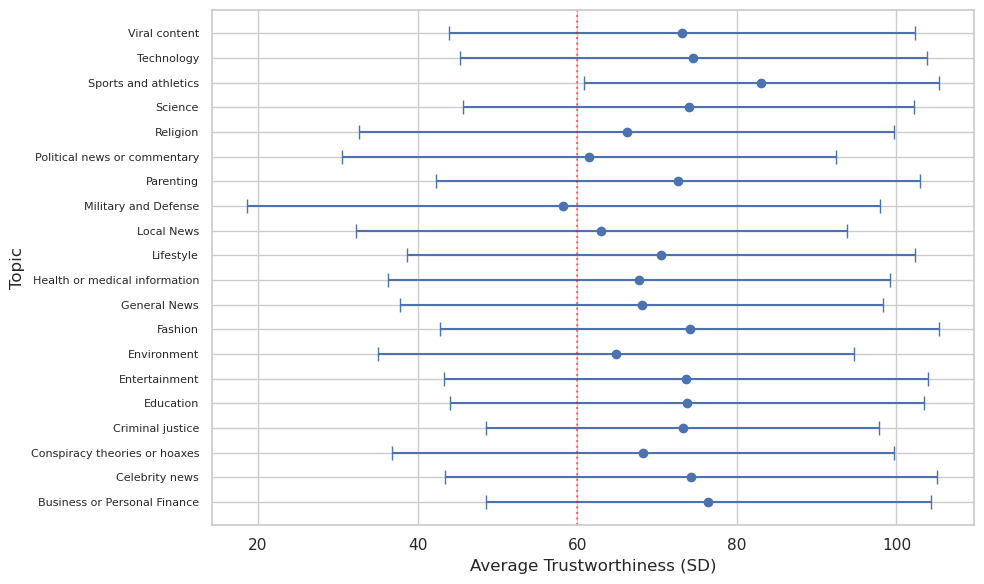

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(y=recent_topic_desc["Topics"],
            x=recent_topic_desc["Score"],
            xerr=recent_topic_desc["SD"],
            fmt="o", capsize=5)

plt.axvline(x=60, 
            color="red", 
            linestyle="dotted", 
            label="Trustworthiness threshold", 
            alpha=0.5)

plt.xlabel("Average Trustworthiness (SD)")
plt.ylabel("Topic")
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(join(figures_path, 
                 "f7-topics_score_recent.png"), 
                 dpi=300)
plt.show()

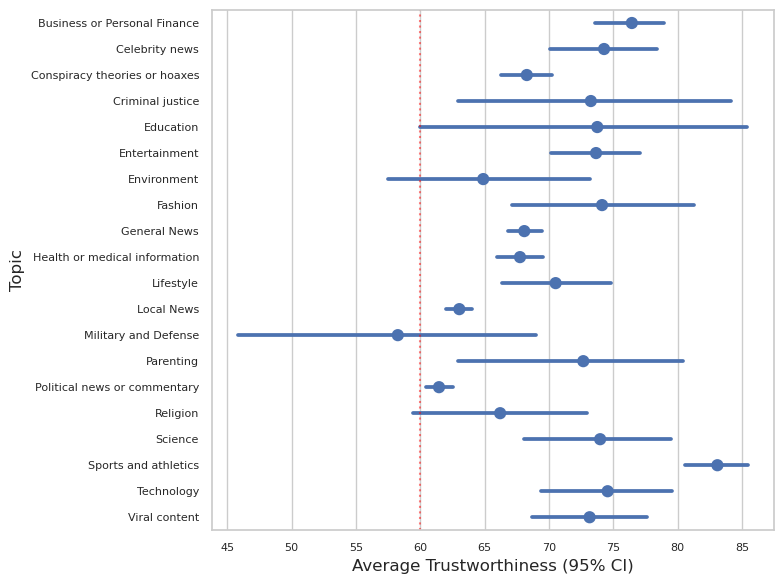

In [ ]:
#turn into sns plot with 95% ci
plt.figure(figsize=(8, 6))
sns.pointplot(data=recent_topics_df, 
            y="Topics", 
            x="Score",
            join=False,
            #can i order according to the mean?
            order=recent_topic_desc["Topics"],
            errorbar="ci")

plt.axvline(x=60, 
            color="red", 
            linestyle="dotted", 
            label="Trustworthiness threshold", 
            alpha=0.5)

plt.xlabel("Average Trustworthiness (95% CI)")
plt.ylabel("Topic")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.tight_layout()

plt.savefig(join(figures_path, 
                 "f7-topics_score_recent-95ci.png"), 
                 dpi=300)

In [ ]:
#get list of domains with rating N
bad_domains = recent_topics_df\
    [recent_topics_df["Rating"] == "N"]\
    ["Domain"].unique()

len(bad_domains)

3209

In [ ]:
topics_bad = recent_topics_df\
        .groupby(["Topics", "Rating"])["Domain"]\
        .nunique()\
        .unstack(fill_value=0)\
        .reset_index()\
        .sort_values(by="N", ascending=False)

#add percentage of good vs bad
topics_bad["% N"] = \
    (topics_bad["N"] / len(bad_domains) * 100)\
        .round(2)

topics_bad

Rating                         Topics     N     T    % N
14       Political news or commentary  1592  1726  49.61
11                         Local News  1463  1971  45.59
8                        General News   534  1243  16.64
9       Health or medical information   345   583  10.75
2       Conspiracy theories or hoaxes   301   530   9.38
0        Business or Personal Finance    67   287   2.09
5                       Entertainment    64   205   1.99
10                          Lifestyle    56   149   1.75
1                      Celebrity news    45   160   1.40
19                      Viral content    39   122   1.22
15                           Religion    31    54   0.97
17               Sports and athletics    30   285   0.93
16                            Science    25    64   0.78
18                         Technology    24    87   0.75
6                         Environment    19    33   0.59
12               Military and Defense    19    25   0.59
7                             Fashion    18    59   0.56
13                          Parenting     9    31   0.28
3                    Criminal justice     6    13   0.19
4                           Education     3    17   0.09

In [ ]:
#how many of bad domains cover each topic?
bad_domains_topics = recent_topics_df\
    [recent_topics_df["Domain"].isin(bad_domains)]\
    .groupby("Topics")["Domain"]\
    .nunique()\
    .reset_index()

bad_domains_topics["%"] = \
    (bad_domains_topics["Domain"] / len(bad_domains) * 100)\
        .round(2)

bad_topics = bad_domains_topics\
    .sort_values(by="Domain", ascending=False)\
    .head(5)

bad_topics

Topics  Domain      %
14   Political news or commentary    1592  49.61
11                     Local News    1463  45.59
8                    General News     534  16.64
9   Health or medical information     345  10.75
2   Conspiracy theories or hoaxes     301   9.38

### Over time

In [ ]:
topics_df = \
    df_15[[
        "file_date", "UUID",
        "Domain", "Country", "Topics",
        "Orientation", "Score", "Rating"]]

topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

topics_df["Topic"] = \
    topics_df["Topics"]\
        .str.split(",")  #split topics into lists

topics_df = \
    topics_df\
        .explode("Topic")\
        .reset_index(drop=True)
topics_df.tail(3)

/tmp/ipykernel_1727229/805052536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_df["Topic"] = \


file_date                                  UUID  \
578180 2023-11-15 01:00:00  38ffb203-ebe5-4cac-8b5a-f84dd3697faf   
578181 2023-11-15 01:00:00  954dfb48-6052-4e16-baaf-3f12dfb2ccce   
578182 2023-11-15 01:00:00  954dfb48-6052-4e16-baaf-3f12dfb2ccce   

                     Domain Country  \
578180  blog.halle-leaks.de      DE   
578181  blog.halle-leaks.de     ALL   
578182  blog.halle-leaks.de     ALL   

                                                   Topics Orientation  Score  \
578180  Conspiracy theories or hoaxes,Political news o...       Right   37.5   
578181  Conspiracy theories or hoaxes,Political news o...       Right   37.5   
578182  Conspiracy theories or hoaxes,Political news o...       Right   37.5   

       Rating                          Topic  
578180      N   Political news or commentary  
578181      N  Conspiracy theories or hoaxes  
578182      N   Political news or commentary

In [ ]:
#topic frequency over time
topic_freq = topics_df\
    .groupby(["file_date", "Topic"])\
    .size()\
    .reset_index(name="Count")

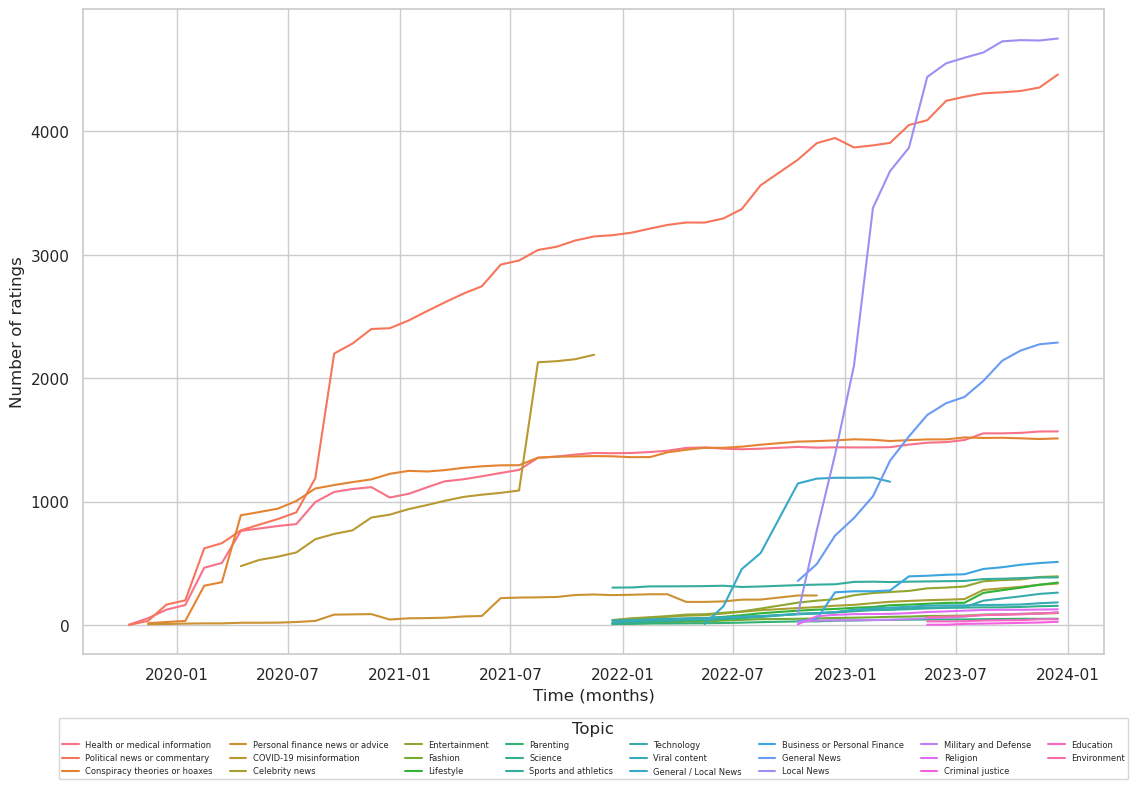

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(x="file_date", 
             y="Count", 
             hue="Topic", 
             data=topic_freq)
plt.xlabel("Time (months)")
plt.ylabel("Number of ratings")
plt.legend(title="Topic",
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=8, 
           fontsize=6)
plt.tight_layout()

plt.savefig(join(figures_path, 
                "fa3-topics_over_time.png"),
                dpi=300)
plt.show()

In [ ]:
#show me the max count for health misinformation
topic_freq[topic_freq["Topic"] == "COVID-19 misinformation"]\
    .sort_values("Count", ascending=False)\
    .head(5)

file_date                    Topic  Count
117 2021-11-15 01:00:00  COVID-19 misinformation   2190
112 2021-10-15 01:00:00  COVID-19 misinformation   2154
107 2021-09-15 01:00:00  COVID-19 misinformation   2138
102 2021-08-15 01:00:00  COVID-19 misinformation   2129
97  2021-07-15 01:00:00  COVID-19 misinformation   1090

### By Country

In [ ]:
country_topics = recent_topics_df\
    .groupby(["Country", "Topics"])\
    .size()\
    .reset_index(name="Count")

country_topics["Percentage"] = \
    (country_topics["Count"] / recent_topics_df["Domain"].nunique() * 100)\
        .round(2)

country_topics

Country                         Topics  Count  Percentage
0       ALL   Business or Personal Finance     54        0.64
1       ALL                 Celebrity news     29        0.34
2       ALL  Conspiracy theories or hoaxes    112        1.33
3       ALL               Criminal justice      2        0.02
4       ALL                      Education      2        0.02
..      ...                            ...    ...         ...
156      US                       Religion     58        0.69
157      US                        Science     58        0.69
158      US           Sports and athletics    292        3.47
159      US                     Technology     59        0.70
160      US                  Viral content    106        1.26

[161 rows x 4 columns]

In [ ]:
topic_avg = \
    recent_topics_df\
        .groupby(["Country", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

topic_avg.columns = \
    ["Country", "Topics", "Score", "SD"]

topic_descriptives = \
    pd.merge(
        country_topics, 
        topic_avg, 
        on=["Country", "Topics"])

topic_descriptives =\
    topic_descriptives\
    .sort_values(["Country", "Count"], 
                ascending=[True, False])

topic_descriptives.head(2)

Country                        Topics  Count  Percentage  Score     SD
11     ALL                    Local News    447        5.31  75.63  24.02
14     ALL  Political news or commentary    412        4.90  73.05  25.52

In [ ]:
#which topic has the highest variance?
topics_df\
    .groupby("Topic")["Score"]\
    .var()\
    .reset_index()\
    .sort_values("Score", ascending=False)\
    .head(5)

Topic        Score
14           Military and Defense  1305.223702
11  Health or medical information  1267.191526
17   Political news or commentary  1011.767216
19                        Science   725.881681
18                       Religion   722.208965

In [ ]:
#show for topic health information
topic_descriptives[topic_descriptives["Topics"] == "Health or medical information"]

Country                         Topics  Count  Percentage  Score     SD
9       ALL  Health or medical information    124        1.47  77.84  23.07
24       AT  Health or medical information      1        0.01  77.50    NaN
36       AU  Health or medical information     14        0.17  80.46  16.85
53       CA  Health or medical information     36        0.43  91.29   8.51
71       DE  Health or medical information     34        0.40  73.56  33.01
89       FR  Health or medical information     30        0.36  72.07  22.15
108      GB  Health or medical information     38        0.45  89.00  11.25
127      IT  Health or medical information     57        0.68  73.76  21.18
150      US  Health or medical information    672        7.98  62.14  33.81

In [ ]:
topic_descriptives[topic_descriptives["Topics"] == "Political news or commentary"]

Country                        Topics  Count  Percentage  Score     SD
14      ALL  Political news or commentary    412        4.90  73.05  25.52
26       AT  Political news or commentary     16        0.19  70.38  31.59
40       AU  Political news or commentary     46        0.55  77.11  19.00
56       CA  Political news or commentary    201        2.39  90.20  13.48
76       DE  Political news or commentary     87        1.03  77.04  29.73
94       FR  Political news or commentary     94        1.12  69.55  23.90
113      GB  Political news or commentary    139        1.65  83.37  18.08
131      IT  Political news or commentary    202        2.40  74.10  20.48
140      NZ  Political news or commentary     11        0.13  87.05  16.04
155      US  Political news or commentary   2413       28.67  53.40  31.15

In [ ]:
topic_descriptives[topic_descriptives["Topics"] == "Military and Defense"]

Country                Topics  Count  Percentage   Score     SD
12      ALL  Military and Defense      7        0.08   66.71  34.26
74       DE  Military and Defense      2        0.02  100.00   0.00
92       FR  Military and Defense      3        0.04   40.00  42.06
111      GB  Military and Defense      2        0.02   81.00   9.19
153      US  Military and Defense     32        0.38   54.08  41.53

In [ ]:
result_countries = topic_descriptives[topic_descriptives["Country"] != "ALL"]\
        .sort_values("Score", ascending=False)

In [ ]:
result_countries

Country                        Topics  Count  Percentage   Score     SD
106      GB                       Fashion      1        0.01  100.00    NaN
74       DE          Military and Defense      2        0.02  100.00   0.00
20       AT  Business or Personal Finance      4        0.05   98.75   2.50
29       AT                    Technology      1        0.01   95.00    NaN
75       DE                     Parenting      3        0.04   94.17  10.10
..      ...                           ...    ...         ...     ...    ...
31       AU                Celebrity news      6        0.07   38.33  47.77
77       DE                      Religion      2        0.02   25.00  17.68
65       DE              Criminal justice      1        0.01   20.00    NaN
66       DE                     Education      1        0.01   20.00    NaN
41       AU                      Religion      1        0.01    7.50    NaN

[141 rows x 6 columns]

In [ ]:
#from result_countries take only bad_topics
bad_topics_countries = result_countries[
    result_countries["Topics"].isin(bad_topics["Topics"])]

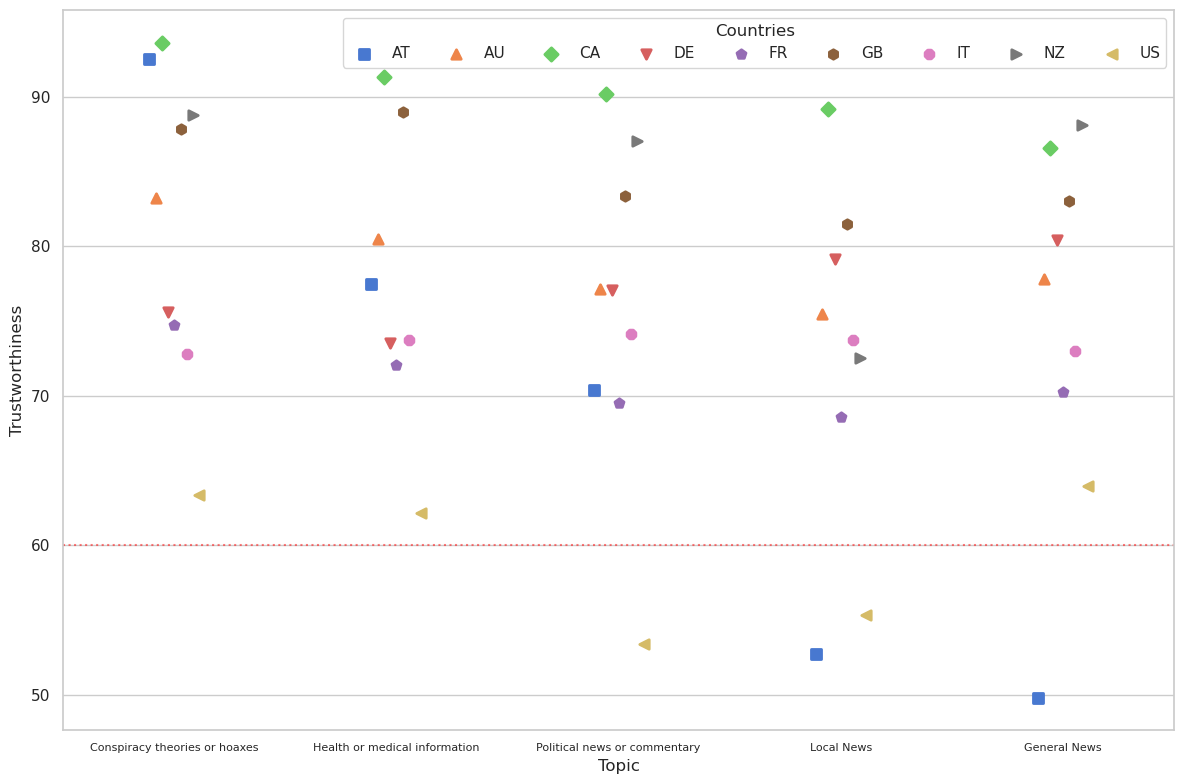

In [ ]:
plt.figure(figsize=(12, 8))
sns.pointplot(x="Topics", 
            y="Score",
            hue="Country",
            hue_order=sorted(bad_topics_countries["Country"].unique()),
            data=bad_topics_countries, 
            dodge=True,
            markers = country_markers,
            join=False,
            palette="muted",
            #order=bad_topics["Topic"].unique()
            )

plt.axhline(y=60,
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Topic")
plt.xticks(fontsize=8)
plt.ylabel("Trustworthiness")
plt.legend(title="Countries",
           loc="upper right", 
           ncol=9)
plt.tight_layout()
plt.savefig(join(figures_path, "f8-topics_score_per_country.png"),
            dpi=300)
plt.show()

### By orientation

In [ ]:
#topics and orientation overlap
topics_orientation = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])\
        .size()\
        .reset_index(name="Count")

Orientation                         Topics  Count
0         Left   Business or Personal Finance     13
1         Left                 Celebrity news      7
2         Left  Conspiracy theories or hoaxes     31
3         Left               Criminal justice      3
4         Left                  Entertainment     11
5         Left                    Environment      5
6         Left                        Fashion      2
7         Left                   General News    107
8         Left  Health or medical information     52
9         Left                      Lifestyle      4
10        Left                     Local News    145
11        Left           Military and Defense      1
12        Left   Political news or commentary    151
13        Left                       Religion      3
14        Left                        Science      2
15        Left           Sports and athletics      4
16        Left                     Technology      7
17        Left                  Viral content      8
18       Right   Business or Personal Finance     50
19       Right                 Celebrity news     36
20       Right  Conspiracy theories or hoaxes    130
21       Right               Criminal justice      1
22       Right                      Education      2
23       Right                  Entertainment     54
24       Right                    Environment     14
25       Right                        Fashion     11
26       Right                   General News    405
27       Right  Health or medical information    131
28       Right                      Lifestyle     45
29       Right                     Local News   1271
30       Right           Military and Defense     19
31       Right                      Parenting      8
32       Right   Political news or commentary   1159
33       Right                       Religion     23
34       Right                        Science     18
35       Right           Sports and athletics     26
36       Right                     Technology     24
37       Right                  Viral content     34

In [ ]:
mean_scores = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

mean_scores.columns = \
    ["Orientation", "Topics", "Score", "SD"]

topic_orientation_scores = pd.merge(
    topics_orientation, 
    mean_scores, 
    on=["Orientation", "Topics"])

heatmap_count = \
    topic_orientation_scores\
        .pivot_table(
            values="Count", 
            index="Topics", 
            columns="Orientation",
            fill_value=0)

heatmap_score = \
    topic_orientation_scores\
        .pivot_table(
            values="Score", 
            index="Topics", 
            columns="Orientation")

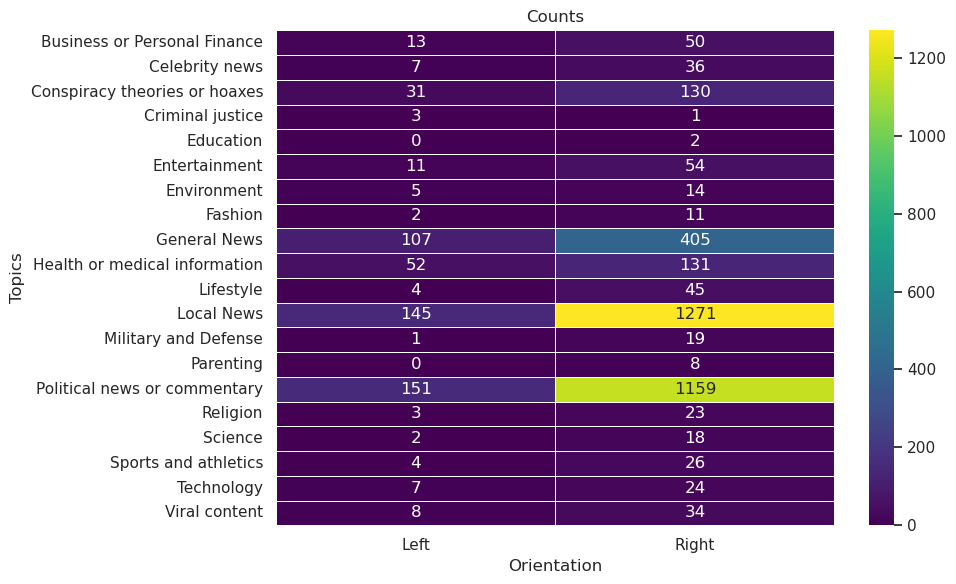

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_count, 
            annot=True, 
            cmap="viridis", 
            fmt="g", 
            linewidths=.5)
plt.title("Counts")
plt.xlabel("Orientation")
plt.ylabel("Topics")

plt.tight_layout()
plt.show()

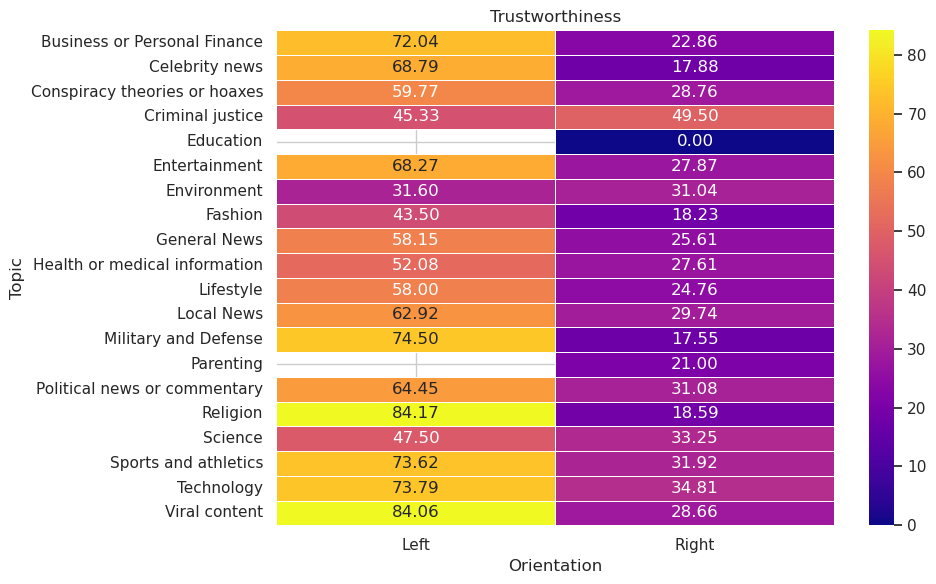

In [ ]:
plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_score, 
            annot=True, 
            cmap="plasma", 
            fmt=".2f", 
            linewidths=.5)
plt.title("Trustworthiness")
plt.xlabel("Orientation")
plt.ylabel("Topic")
plt.tight_layout()
plt.savefig(join(figures_path,
                "f9-topics_orientation.png"),
                dpi=300)
plt.show()

## Other variables

In [ ]:
df_recent.Flags.value_counts().head(10)

hideParty,covid,vacc,hlth,PartisanLocal          1073
covid,abortion,hlth,ukraine,elec,vacc,climate     458
dead                                              166
plag,dead                                         154
ukraine                                           152
elec,covid                                        136
plag                                              111
covid,hlth,vacc                                    76
hideParty                                          72
dead,hoax                                          65
Name: Flags, dtype: int64

<Axes: xlabel='file_date'>

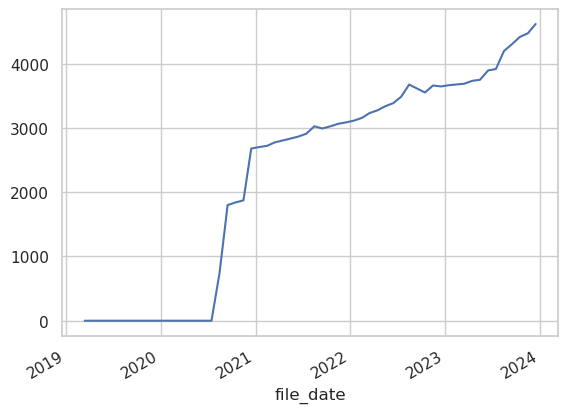

In [ ]:
#create variable with 0 or 1
df15["flags_int"] = \
    df15["Flags"]\
        .notnull()\
        .astype(int)

df15\
    .groupby("file_date")["flags_int"]\
    .sum()\
    .plot(kind="line")

In [ ]:
df15[df15["flags_int"] == 1]\
    .groupby("file_date")["flags_int"]\
    .sum()\
    .head(3)

file_date
2020-08-15 01:00:00     743
2020-09-15 01:00:00    1800
2020-10-15 01:00:00    1841
Name: flags_int, dtype: int64

In [ ]:
df_total["myths"].value_counts()

102431f3-d621-4ba4-ae4b-ab7da59d74d5,7e61e4a4-8409-4290-9ef6-3f54753ec548,33180d69-cfb3-46cb-af1a-3354fb13e887,d7567bf3-d02a-4593-95d8-846c181fe588,79f635e6-94ed-44ed-b7b9-61c35536291c,ef447576-c02b-426c-a961-012c1e14fc80,ef447576-c02b-426c-a961-012c1e14fc80,b5c5d618-dd52-4158-a01e-a3c37c38b35a,d964d1c0-69c5-4ecb-af17-7d513a2aca17,4dc054b4-638c-4932-9ab1-ca1017ef0ade,1d4dda2b-e34e-47d4-88d1-fcf397dab19c,26a6eb22-ec3d-46e2-a99b-7c94ae7c9b6a,59898e32-65cf-46af-9f2c-29d245458bbf,8b42cdd8-7a88-4976-88e3-82e071e6c195,c75fc59a-0358-4fe4-86fe-677d4b8eb493,c75fc59a-0358-4fe4-86fe-677d4b8eb493,70a5b27b-fd14-47b1-809e-a15056900e2a,cf3b4ff0-2264-4c59-b671-0cc00d5b5cfb,bb578c95-03d4-4669-a52c-0d5dff6bda08,bb578c95-03d4-4669-a52c-0d5dff6bda08,0c5b2d3c-f464-478f-a350-4bae0d7427e7,0c5b2d3c-f464-478f-a350-4bae0d7427e7,dad1391e-d967-4812-b417-cabc6e461d39,09320776-1191-4b4e-8c86-3862878e7dca,09320776-1191-4b4e-8c86-3862878e7dca,09320776-1191-4b4e-8c86-3862878e7dca,db6818e3-17ea-4496-af97-d9ed45af792f,e

In [ ]:
df_total["False Narratives"].value_counts()

c008863c-50c8-4800-b18d-afbacc663d82,f0a66c5e-c7f9-4577-a375-26e2d6f5fc65                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
df_recent_unique = df_recent.drop_duplicates(subset=["Domain"])
df_recent_unique["Rating"].value_counts(normalize=True)

T    0.618702
N    0.381298
Name: Rating, dtype: float64